# Data Preparation for POMMES
This notebook contains the major routines used to prepare and provide input data for the fundamental power market model _POMMES_ <br>(<b>Po</b>wer <b>M</b>arket <b>M</b>odel <b>E</b>nergy and re<b>S</b>ources).

It provides input data for (oemof.solph components used for modeling given in brackets)
* conventional power plants (Transformers)
* interconnectors (Transformers; formerly Links)
* storages (GenericStorages)
* commodity sources (Sources)
* renewable generators (Sources / Transformers)
* power demand (Sinks)

Output:
* A `pommesdispatch` data set for any year between 2017 and 2030 can be created.
* Also, a `pommesinvest` data set is created, spanning the time horizon from 2020 to 2050.

Time-related information:
* For future years, power plant commissionings and decommissionings are taken into account and RES are expanded by a given pathway.
* Note that so far, we have included **time series information only for 2017**. For any other year, 2017 time series are used and simply reindexed. To have a comparable simulation year with 8760 hours, for leap years, the last day is simply neglected.
* Also, UTC time stamps are used thus ignoring time shift.

Overview on the document:
> **Outline:** The correspondend elements, named components, used in the framework [oemof.solph](https://github.com/oemof/oemof-solph) determine the outline of the given notebook.
> _NOTE: It is recommended to run the notebook sequentially since variables declared earlier may be needed later on, even in later sections._

> **Raw data sources:** The raw data is taken from different sources, mostly [OPSD](https://open-power-system-data.org/) and [ENTSO-E](https://transparency.entsoe.eu/). The major sources and assumptions are documented for the respective power system elements (components) in the following. For power plant projections, data from the lastest approved network development plan for electricity for Germany [NEP Strom 2030 as of 2019](https://www.netzentwicklungsplan.de/de/netzentwicklungsplaene/netzentwicklungsplan-2030-2019) as well as data from the [TYNDP 2018](https://tyndp.entsoe.eu/maps-data) of ENTSO-E for are used.<br>
An overview on the data licensing information can be found in the repository.

> **Tasks:** Besides extraction, cleaning and combination of data from the sources and assumptions, significant parts of the notebooks are routines for transferring the data to a data format that can be handled by the framework [oemof.solph](https://github.com/oemof/oemof-solph) which serves as a basis for the model _POMMES_.

> **Authors:** Corresponding authors: Yannick Werner, Johannes Kochems<br>Contributors: Leticia Encinas Rosa, Carla Spiller, Sophie Westphal, Julian Endres, Julien Faist, Timona Ghosh, Johannes Giehl, Christian Fraatz, Robin Claus, Daniel Peschel, Conrad Nicklisch, Benjamin Grosse, Joachim Müller-Kirchenbauer

# Package imports and settings

## Imports

User defined modules used:
* `tools`: a set of functions holding assisting routines; comprises functions for calculating (shortest) distances based on given GPS coordinates, for loading bidding zone shapes as well as ENTSO-E data, for assigning efficiencies as well as gradients and minimum loads and for setting NTC values
* `eeg_transformers`: functions for modeling RES clusters bidding at the negative market premium (routines for reading in data, data aggregation, clustering and assigning market values)
* `transformers_aggregation`: functions for clustering conventional power plants
* `hydro`: functions to load, preprocess and upsample hydro generation and filling rate data

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from re import search, IGNORECASE
from os import listdir
from os.path import isfile, join

import data_prep.tools as tools
import data_prep.eeg_transformers as eeg
import data_prep.transformer_aggregation as tf_agg
import data_prep.hydro as hydro

In [340]:
# Paths to input files
main_path = {
    'inputs': '../raw_data_input/',
    'outputs': '../prepared_data/'
}

sub_path = {
    'interconnectors': 'interconnectors/',
    'pp_public': 'powerplants_public/',
    'pp_er': 'powerplants_er/',
    'timeseries': 'timeseries/',
    'hydro': 'hydro/',
    'renewables': 'renewables/',
    'marketzones': 'market_zones_scandinavia/',
    'costs': 'costs/',
    'assumptions': 'assumptions/'
}

# Filenames of input files
input_file = {
    'opsd_de': 'KWlisteDE_OPSD_20191002.csv',
    'opsd_de_new': 'conventional_power_plants_DE.csv',
    'ppmatching_eu': 'powerplants_conventional_eu.csv',
    'ppmatching_eu_new': 'powerplants_conventional_eu_20210105.csv',
    'tyndp_eu': 'ENTSO Scenario 2018 Generation Capacities.xlsm',
    'nep_de': 'KWliste_NEP2030_20191022.xlsx',
    'techs_de': 'Technologies_ManRes_20170212.csv',
    'peschel': 'KWliste_DP_20160304.csv',
    'eff_de': 'Efficiencies_ManRes_20180918.csv',
    'comm': 'transformers_commissioning.xlsx',
    'decomm': 'transformers_decommissioning.csv',
    'comm_decomm_BNetzA': 'BNetzA_Veroeff_ZuUndRueckbau_20200404.xlsx',
    'KWSAL': 'KWSAL_20200415.csv',
    'decomm_hardcoal': 'transformers_decommissioning_hardcoal.csv',
    'decomm_lignite': 'transformers_decommissioning_lignite.csv',
    'hardcoal_tender_1': 'Liiste_Zuschlaege_01092020_1.xlsx',
    'hardcoal_tender_2': 'Liste_Zuschlaege_Jan2021.xlsx',
    'hardcoal_tender_3': 'Liste_Zuschlaege_April2021.xlsx',
    'hardcoal_tender_4': 'Liste_Zuschlaege_Oktober2021.xlsx',
    'hardcoal_tender_5': 'ListeZuschlaegeMaerz2022.xlsx',
    'availability': 'availability.csv',
    'gradients': 'max_gradient_assumptions.csv',
    'new_built': 'transformers_new-built.csv',
    'interconnectors_ttc': 'interconnectors_ttc.csv',
    'interconnectors_tech_profiles': 'interconnectors_tech_profiles.csv',
    'interconnectors_timeseries': 'Interconnectors_timeseries_20191028.csv',
    'renewables_nonfluctuating': 'capacity_factors_nonfluc_16082020.csv',
    'eeg_powerplants': 'ee_powerplants_29102021.csv',
    'market_values': 'netztransparenz_market_values_2017.csv',
    'REcap_eu': 'REcapacitiesEU_IRENA_20201120.csv',
    'REcap_DK': 'DK_capacities_20191120.csv',
    'RES_DE_Prognos': 'Prognos_et_al_2020_RES_data.csv',
    'RES_DE_EEG_2021': 'EEG_2021_RES_capacity_targets.csv',
    'RES_DE_EEG_2023': 'EEG_2023_RES_capacity_targets.csv',
    'onshore_tenders': 'Statistik_Onshore_20220107.xlsx',
    'solar_tenders': 'Statistik_Solar_20220107.xlsx',
    'solar_tenders2': 'Statistik_Solar2_20220107.xlsx',
    'common_tenders': 'Statistik_GemAV_20210716.xlsx',
    'PV_2021_01': 'PV_DegressionsVergSaetze_11-01_21.xlsx',
    'PV_2021_02': 'PV_DegressionsVergSaetze_02-04_21.xlsx',
    'PV_2021_03': 'PV_DegressionsVergSaetze_05-07_21.xlsx',
    'RES_cost_ISE': 'RES_cost_projections_ISE.csv',
    'RES_market_development' : 'RES_market_development.csv',
    'RES_costs_ISE21' : 'RES_cost_projections_ISE21.csv',
    'operation_costs_assumptions': 'operation_costs_assumptions.csv',
    'markup_assumptions': 'markup_assumptions.csv',
    'opsd_timeseries': 'Timeseries_OPSD_20191028.csv',
    'entsoe_generation_de': 'entsoe_generation_DE_22072020.csv',
    'efficiencies_el': 'efficiencies_el.csv',
    'phes_assumptions': 'phes_assumptions.csv',
    'tech_assumptions': 'tech_assumptions.csv',
    'emf': 'Emissionfactors_20200807.csv',
    'GHG_emissions': 'GHG_emissions.csv',
    'transformers_investment_options': 'transformers_investment_options.csv',
    'storages_el_investment_options': 'storages_el_investment_options.csv',
    'energiedaten': 'energiedaten-gesamt-xls-2022.xlsx',
    'transportation_costs': 'transportation_cost_assumptions.csv',
    'fuel_cost_assumptions': 'fuel_cost_assumptions.csv',
    'prices_iea_weo': 'prices_IEA_WEO_2021.xlsx',
    'prices_ewi': 'ewi_2022_Energiepreisszenarien.xlsx',
    'monthly_price_trends': 'energy-price-trends-xlsx-2022.xlsx',
    'emissions_costs': 'emission-spot-primary-market-auction-report',
    'emission_costs_projection': 'co2_prices.csv',
    'emission_costs_long-term_projection': 'co2_prices_pietzcker_et_al_2021.csv',
    'cost_projections_nicklisch': 'cost_projections_nicklisch.xlsx',
    'investment_costs_unseen': 'investment_cost_assumptions_UNSEEN_various_sources.csv',
    'costs_assumptions_pypsa_eur': 'PyPSA-EUR_costs.csv',
    'pietzcker_technology_assumptions': 'Pietzcker_et_al_2021_technology_assumptions.xlsx',
    'ise_technology_assumptions': 'ISE_2020_assumptions_technology_costs.xlsx',
    'dieterpy_data': 'dieterpy_data_input.xlsx',
    'flexmex_data': 'FlexMex_Scalars_ALL.csv',
    'unseen_data': 'investment_cost_assumptions_UNSEEN_various_sources.csv',
    'unseen_fixed_costs_data': 'fixed_cost_assumptions_UNSEEN_various_sources.csv',
    'unseen_variable_costs_data': 'variable_cost_assumptions_UNSEEN_various_sources.csv',
    'pypsa_eur': 'PyPSA-EUR_costs.csv',
    'wacc': 'wacc_polzin_2021.csv',
    'hurdle_rates': 'NERA_2015_hurdle_rates.xlsx'
}

# Filenames of output files (used as model input)
output_file = {
    "buses": "buses",
    "dh_gradients_ts": "dh_gradients_ts",
    "ipp_gradients_ts": "ipp_gradients_ts",
    "remaining_gradients_ts": "remaining_gradients_ts",
    "linking_transformers": "linking_transformers",
    "linking_transformers_ts": "linking_transformers_ts",
    "sources_fluc_res": "sources_fluc_res",
    "sources_commodity": "sources_commodity",
    "emission_limits": "emission_limits",
    "sources_shortage": "sources_shortage",
    "sources_shortage_el_add": "sources_shortage_el_add",
    "sources_renewables": "sources_renewables",
    "sources_renewables_ts": "sources_renewables_ts",
    "sinks_demand_el": "sinks_demand_el",
    "sinks_demand_el_ts": "sinks_demand_el_ts",
    "sinks_excess": "sinks_excess",
    "transformers": "transformers",
    "transformers_minload_ts": "transformers_minload_ts",
    "transformers_gradients": "transformers_gradients",
    "transformers_availability_ts": "transformers_availability_ts",
    "transformers_renewables": "transformers_renewables",
    "transformers_exogenous": "transformers_exogenous",
    "transformers_exogenous_max_ts": "transformers_exogenous_max_ts",
    "transformers_investment_options": "transformers_investment_options",
    "storages_el_investment_options": "storages_el_investment_options",
    "storages_el": "storages_el",
    "storages_el_exogenous": "storages_el_exogenous",
    "costs_operation": "costs_operation",
    "costs_fuel": "costs_fuel",
    "costs_emissions": "costs_emissions",
    "costs_emissions_ts": "costs_emissions_ts",
    "costs_operation_renewables": "costs_operation_renewables",
    "costs_operation_storages": "costs_operation_storages",
    "costs_market_values": "costs_market_values",
    "costs_fuel_ts": "costs_fuel_ts",
    "wacc": "wacc",
    "interest_rate": "interest_rate"
}

## Notebook workflow settings
- The variable `year` determines, for which target year the power plant status shall be evaluated. A value between 2017 and 2030 can be selected.
- Specify `inflation_rate` in order to calculate nominal cost values from it.
- `wacc_mode` defines the mode to be used for the weighted average costs of capital:
    - "technology_specific": introduces empirically derived technology-specific WACC values
    - "unique": Spreads a unique WACC assumption across all technologies
- For some plants appearing in the list(s) of power plants to be decommissioned, the decommissioning year is missing. This is defined by `shutdown_assumption`, which imposes a (single) decommissioning year for the respective plants.
- `eeg_clusters_per_technology` determines the amount of clusters per eeg technology to use.
- `res_capacity_projection` determines which estimate to use for RES capacity development for Germany until 2030 ("Prognos", "EEG_2021" or "EEG_2023")
- `cluster_transformers_DE` determines whether or not to cluster power plants for Germany by their efficiencies. Clustered data can be used to speed up POMMES computations coming at the expense of model result precision.

In [3]:
year = 2030  # between 2017 and 2030
inflation_rate = 1.02
wacc_mode = "technology_specific"  # "unique"
shutdown_assumption = 2022  # between 2017 and 2030
eeg_clusters_per_technology = 20
res_capacity_projection = "EEG_2023"  # "Prognos", "EEG_2021", "EEG_2023"; for investment model: choose "EEG_2023"
cluster_transformers_DE = True

In [4]:
if (year < 2017 or year > 2030):
    raise ValueError(f'year must be between 2017 and 2030. You chose {year}.')

# Initialze an ExcelWriter to store all data in an .xlsx file
writer = pd.ExcelWriter(
    main_path["outputs"] + 'input_data_complete_' + str(year) + '.xlsx', 
    engine='openpyxl'
)

# Transformers

In this section, **conventional power plant** data for Germany and Europe is put together.<br>
In [oemof.solph](https://github.com/oemof/oemof-solph) conventional power plants (in the most simple approach) can be represented through (generic) so called "transformers" which have one input and one or two ouputs (two outputs for CHP).

## Data Import and initial preparation

**Main data source**:<br>
German and European Data on conventional powerplants (PPs) is taken from [Open Power System Data](https://data.open-power-system-data.org/conventional_power_plants/)

* Plant status as of 2019:<br>

Open Power System Data. 2020. Data Package Conventional power plants. Version 2020-10-01, downloaded on 2021-01-04. https://doi.org/10.25832/conventional_power_plants/2020-10-01

* Plant status as of 2017:<br>

Open Power System Data. 2018. Data Package Conventional power plants. Version 2018-12-20, downloaded on 2019-10-02. https://doi.org/10.25832/conventional_power_plants/2018-12-20

### German Powerplants (OPSD)

#### Read in data and do renaming
Steps applied:
- Data from conventional power plants from OPSD is read in.
- Columns not needed are dropped.
- A new country index 'DE' is assigned for all power plants, including those that are positioned in the netherlands and austria but feed into the German grid.

In [5]:
# Data set with plant status as of 2019
if year > 2017:
    opsd_de = pd.read_csv(
        main_path["inputs"] + sub_path["pp_public"] + input_file["opsd_de_new"],
        index_col=0
    )

    opsd_de.drop(
        columns=['capacity_gross_uba',
                 'street', 'postcode', 'city', 'network_operator',
                 'energy_source_level_1', 'energy_source_level_2', 'energy_source_level_3',
                 'merge_comment', 'comment'], 
        inplace=True)

    opsd_de['country2'] = 'DE'
    opsd_de.rename(columns={'country': 'country_geographical', 
                            'country2': 'country',
                            'energy_source': 'fuel'}, 
                   inplace=True)
    eu_pp_feedin_de = opsd_de[opsd_de['country_geographical'] != 'DE'].index

# Older data set; only used to evaluate plant status as of 2017
else:
    opsd_de = pd.read_csv(
        main_path["inputs"] + sub_path["pp_public"] + input_file["opsd_de"],
        sep=";", decimal=",", index_col=0
    )

    opsd_de.drop(
        columns=['capacity_gross_uba',
                 'street', 'postcode', 'city', 'network_operator',
                 'energy_source_level_1', 'energy_source_level_2', 'energy_source_level_3',
                 'merge_comment', 'comment'], 
        inplace=True)

    opsd_de['country'] = 'DE'
    opsd_de.rename(columns={'country_code': 'country_geographical'}, inplace=True)
    eu_pp_feedin_de = opsd_de[opsd_de['country_geographical'] != 'DE'].index

> _NOTE: There are two duplicated BNetzA ids in the new OPSD data set which are obtained from the original BNetzA power plants list._
> * _For the respective power plants, one block (or a share of blocks) is shutdown while the other is still operational_
> * _The shutdown power blocks' BNetzA id is manipulated to account for that circumstance._

Approach:
* Append shutdown column to index to create a MultiIndex
* Identify duplicates at index level 0 (BNetzA ID) with shutdown being not NaN.
* Get the index location
* Get list of original indices, replace the index location and reassign indices, using the string '\_SD' to indicate plants for shutdown.

In [6]:
if year > 2017:
    duplicated_idx = {}
    
    opsd_multi = opsd_de.set_index('shutdown', append=True)
    
    duplicated = opsd_multi[(opsd_multi.index.get_level_values(0).duplicated(keep=False))
                             & (opsd_multi.index.get_level_values(1).notna())].index

    for el in duplicated:
        idx_el = opsd_multi.index.get_loc(el)
        duplicated_idx[el[0]] = idx_el
        
    as_list = opsd_de.index.tolist()
    for k, v in duplicated_idx.items():
        as_list[v] = k + '_SD'
    opsd_de.index = as_list

#### Prepare German conventional PP Raw Data

Steps applied:
- Exclude pumped storage, run-of-river and (other) storage technologies because they are specifically treated later on <br>&rarr; Create subsets for these technologies for later usage
- Exclude non EEG units (i.e. biomass power plants) because biomass within the EEG scheme are treated as EE source later on <br>&rarr; Create a subset for EEG technologies for later usage
- Replace fuel names from the OPSD list with the names used in _POMMES_ and rename some columns
- Assign last commissioning dates for units which had a retrofit (last commissioning date = retrofitting date)

In [7]:
conv_de = opsd_de[(~opsd_de['technology'].isin(['Pumped storage', 'Run-of-river', 
                                                'Storage technologies', 'RES', 'Reservoir'])) &
                  (opsd_de['eeg'] == 'no')].copy()

phes_de = opsd_de.loc[opsd_de['technology'] == 'Pumped storage']
ror_de = opsd_de.loc[opsd_de['technology'] == 'Run-of-river']
eeg_de = opsd_de.loc[(opsd_de['eeg'] == 'yes') & (opsd_de['technology'] != 'Run-of-river')]

In [8]:
dict_fuels = {'Hard coal': 'hardcoal',
              'Nuclear': 'uranium',
              'Mixed fossil fuels': 'mixedfuels',
              'Lignite': 'lignite',
              'Natural gas': 'natgas',
              'Oil': 'oil',
              'Biomass and biogas': 'biomass',
              'Other fossil fuels': 'otherfossil',
              'Other fuels': 'otherfossil',
              'Waste': 'waste'}

conv_de.loc[:,'fuel'].replace(dict_fuels, inplace=True)

conv_de.rename(columns={'capacity_net_bnetza': 'capacity',
                        'eic_code_plant': 'eic_code',
                        'name_bnetza': 'name'}, inplace=True)

conv_de.loc[~conv_de['retrofit'].isna(),
            'commissioned_last'] = conv_de.loc[~conv_de['retrofit'].isna(), 'retrofit']
conv_de.loc[conv_de['retrofit'].isna(), 
            'commissioned_last'] = conv_de.loc[conv_de['retrofit'].isna(), 'commissioned']
conv_de = conv_de.astype(dtype={'commissioned_last': 'object'})

### European Powerplants (PyPSA-EUR PP matching)

European power plants data is obtained from an existing [power plant matching tool](https://github.com/FRESNA/powerplantmatching) developped by the PyPSA developpers:

F. Gotzens, H. Heinrichs, J. Hörsch, and F. Hofmann, Performing energy modelling exercises in a transparent way - The issue of data quality in power plant databases, Energy Strategy Reviews, vol. 23, pp. 1–12, Jan. 2019. <br>[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.3358985.svg)](https://doi.org/10.5281/zenodo.3358985).<br>Copyright 2018-2020 Fabian Gotzens (FZ Jülich), Jonas Hörsch (KIT), Fabian Hofmann (FIAS)<br>
powerplantmatching is released as free software under the [GPLv3](http://www.gnu.org/licenses/gpl-3.0.en.html), see [LICENSE](https://github.com/FRESNA/powerplantmatching/blob/master/LICENSE) for further information.

Steps applied:
- Read in data set supplied as output of the power plant matching tool.
- Drop data for countries which are not within the scope of _POMMES_.
- Drop powerplants that feed into the German grid and are modeled in Germany.

**Update**: Use data set as of end of 2020-26-11.
* ids used are unique and consistent.
* Keep the naming from the older data set.

In [9]:
countries_eu = {'Netherlands': 'NL', 
                'Denmark': 'DK', 
                'France': 'FR', 
                'Poland': 'PL', 
                'Switzerland': 'CH',
                'Czech Republic': 'CZ', 
                'Norway': 'NO', 
                'Sweden': 'SE', 
                'Austria': 'AT', 
                'Belgium': 'BE'}

# Data set with plant status as of 2019
if year > 2017:
    pp_eu = pd.read_csv(
        main_path["inputs"] + sub_path["pp_public"] + input_file["ppmatching_eu_new"],
        index_col=0
    )
    
    columns_eu_old = {'DateIn': 'YearCommissioned',
                      'DateRetrofit': 'Retrofit'}
    
    pp_eu.rename(columns=columns_eu_old, inplace=True)
    pp_eu.drop(index=pp_eu[~pp_eu['Country'].isin(countries_eu.keys())].index, inplace=True)
    pp_eu['Country'].replace(countries_eu, inplace=True)

    pp_eu.drop(index=pp_eu[pp_eu['projectID'].str.contains('|'.join(eu_pp_feedin_de))].index, inplace=True)

# Older data set; only used to evaluate plant status as of 2017
else:
    pp_eu = pd.read_csv(
        main_path["inputs"] + sub_path["pp_public"] + input_file["ppmatching_eu"],
        sep=";", decimal=",", index_col = 0
    )

    pp_eu.drop(index=pp_eu[~pp_eu['Country'].isin(countries_eu.keys())].index, inplace=True)
    pp_eu['Country'].replace(countries_eu, inplace=True)

    pp_eu.drop(index=pp_eu[pp_eu['projectID'].str.contains('|'.join(eu_pp_feedin_de))].index, inplace=True)

#### Bidding Zone Allocation
For Sweden and Norway shape files are used, that contain the respective bidding zones. Those plants that are not in these multipolygons are allocated based on the bidding zone of their nearest neighbour. This happens quite often for Norwegian hydro power, where the fjords are not perfectly represented by the shapes.

Shape data is obtained from the electricity map of Tomorrow. See this [GitHub issue](https://github.com/tmrowco/electricitymap-contrib/pull/1383) for Norwegian and Swedish data.<br>
Copyright (c) 2020 Tomorrow<br>
License is [MIT License](https://opensource.org/licenses/MIT).

Steps applied:
- Assign bidding zones for DK based on longitude
- Assign bidding zones for Norway and Sweden based on geometry shape data
- Assign missing bidding zone information based on smallest geodesic distance to the next bidding zone for Norway and Sweden

In [10]:
pp_eu['bidding_zone'] = pp_eu['Country']

pp_eu.loc[pp_eu['Country'] == 'DK', 'bidding_zone'] = (
    np.where(pp_eu.loc[pp_eu['Country'] == 'DK', 'lon'] <= 10.9, 'DK1', 'DK2'))

country_dict = {'NO': 5, 'SE': 4}
for country in country_dict.keys():
    points = pp_eu.loc[(pp_eu['Country'] == country), ['lat','lon']]
    points_df = gpd.GeoDataFrame(points, 
                                 geometry=gpd.points_from_xy(points.lon, points.lat), 
                                 crs="epsg:4326")
    
    zones = pd.concat([tools.load_bidding_zone_shape(
        country, country + str(number),
        main_path["inputs"] + sub_path["marketzones"]) 
                       for number in range(1, country_dict[country] + 1)])
    
    points_df = gpd.sjoin(points_df, zones, how='left')
    pp_eu.loc[points_df.index, 'bidding_zone'] = points_df['id'].values
    
    for idx in pp_eu[(pp_eu['Country'] == country) & (pp_eu['bidding_zone'].isna())].index:
        lat_miss, lon_miss = pp_eu.loc[idx, ['lat', 'lon']]

        idx_min_dist = pp_eu.loc[(pp_eu['Country'] == country) &
                                   (~pp_eu['bidding_zone'].isna()), ['lat', 'lon']].apply(
            lambda x: tools.calc_dist(lat_miss, lon_miss, x.lat, x.lon), axis=1).idxmin()

        pp_eu.at[idx, 'bidding_zone'] = pp_eu.at[idx_min_dist, 'bidding_zone']

#### Prepare European conventional PP Raw Data
Steps applied:
- Rename columns and fuels such that they match the (oemof.solph) terminology used in _POMMES_
- Assign technology for hydro plants
    - _**Assumption made**: Plants under 10 kW are ROR, those above are hydro storages (reservoir)_
- Introduce subsets for some technologies (conventional and renewable ones)
- Assign last commissioning dates for units which had a retrofit (last commissioning date = retrofitting date)

In [11]:
pp_eu.rename(
    columns={'Name': 'name', 
             'Fueltype': 'fuel', 
             'Technology': 'technology', 
             'Country': 'country',
             'Capacity': 'capacity', 
             'Efficiency': 'efficiency_el', 
             'Duration': 'duration', 
             'Volume_Mm3':'volume_m3',
             'DamHeight_m': 'damheight_m', 
             'YearCommissioned': 'commissioned', 
             'Retrofit': 'retrofit'}, 
    inplace=True)

pp_eu.loc[(pp_eu['fuel'] == 'Hydro') & (pp_eu['technology'].isna()), 'technology'] = (
    np.where(pp_eu.loc[(pp_eu['fuel'] == 'Hydro') & (pp_eu['technology'].isna()), 'capacity'] < 10,
             'Run-Of-River',
             'Reservoir'))

conv_eu = pp_eu[(~pp_eu['fuel'].isin(['Wind', 'Solar', 'Hydro']))].copy()
pumpedstorage_eu = pp_eu.loc[pp_eu['technology'] == 'Pumped Storage']
reservoir_eu = pp_eu.loc[pp_eu['technology'] == 'Reservoir']

In [12]:
conv_eu['fuel'].replace(
    {'Hard Coal': 'hardcoal',
     'Nuclear': 'uranium',
     'Lignite': 'lignite',
     'Natural Gas': 'natgas',
     'Oil': 'oil',
     'Bioenergy': 'biomass',
     'Other': 'otherfossil'}, 
    inplace=True)

conv_eu.loc[~conv_eu['retrofit'].isna(), 
            'commissioned_last'] = conv_eu.loc[~conv_eu['retrofit'].isna(), 'retrofit']
conv_eu.loc[conv_eu['retrofit'].isna(), 
            'commissioned_last'] = conv_eu.loc[conv_eu['retrofit'].isna(), 'commissioned']

In [13]:
# Do some garbage collection
try:
    del (as_list, columns_eu_old, country, country_dict, dict_fuels,
         duplicated_idx, duplicated, el, eu_pp_feedin_de, idx, idx_el, idx_min_dist,
         k, lat_miss, lon_miss, opsd_de, opsd_multi, points, points_df, v, zones)
except:
    pass

## Add projection for near future power plant development

The future estimate for power plants in 2030 for Germany is depicted using the following sources
* NEP power plant list: ÜNB / BNetzA (2019): Kraftwerksliste zum ÜNB Entwurf des Szenariorahmens zum NEP 2030,  https://www.netzentwicklungsplan.de/sites/default/files/paragraphs-files/Kraftwerksliste_%C3%9CNB_Entwurf_Szenariorahmen_2030_V2019_2_0_0.pdf, downloaded on 2019-10-22.
* Plans for commissioning of new plants put together by Julien Faist (JF). Primary data is combined from
    * UBA (2019): Genehmigte oder im Genehmigungsverfahren befindliche Kraftwerksprojekte in Deutschland, as of 01/2019, https://www.umweltbundesamt.de/sites/default/files/medien/384/bilder/dateien/4_tab_genehmigte-in_genehmigung-kraftwerksprojekte_2019-04-04.pdf, accessed 03.11.2020.
    * BDEW (2019): BDEW-Kraftwerksliste. In Bau oder Planung befindliche Anlagen ab 20 Megawatt (MW) Leistung, Anlage zur BDEW-Presseinformation vom 1.April 2019 zur Hannover Messe, https://www.bdew.de/media/documents/PI_20190401_BDEW-Kraftwerksliste.pdf, accessed 03.11.2020.
    * BNetzA (2019): Kraftwerksliste Bundesnetzagentur zum erwarteten Zu- und Rückbau 2019 bis 2022, https://www.bundesnetzagentur.de/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/Versorgungssicherheit/Erzeugungskapazitaeten/Kraftwerksliste/kraftwerksliste-node.html, as of 07.03.2019, accessed 03.12.2019.
    * company specific sources given in the table itself.
* The power plant 'Datteln 4' has been taken into operation meanwhile. It is obtained from a data set on exogeneous decommissioning plans which has been put together by Julien Faist as well.

The future capacity projections for Europe in 2030 are derived from the latest version of the TYNDP from ENTSO-E:<br>
ENTSO-E (2019): ENTSOE Scenario 2018 Generation Capacities, https://tyndp.entsoe.eu/maps-data, accessed 03.11.2020.

Updated sources:
* BNetzA (2020): Kraftwerksliste Bundesnetzagentur zum erwarteten Zu- und Rückbau 2019 bis 2022, https://www.bundesnetzagentur.de/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/Versorgungssicherheit/Erzeugungskapazitaeten/Kraftwerksliste/kraftwerksliste-node.html, as of 01.04.2020, accessed 05.01.2021.

### Determine new commissionings for Germany
Steps applied:
* Read in and use the NEP power plant data set.
    * Replace values with unknown commissioning date in NEP list. &rarr; These are planned power plants for which no commissioning date is given; it is (arbitrarily) set to 2030.
    * Filter out newly built power plants which are commissioned between 2019 and 2030. Include investment-related assumptions:
        * In the investment model, it is assumed that plants with a commissioning date later than 2030 are not built. Investments from 2030 on are purely model-endogenous.
        * Furthermore, it is assumed that plants going into operation from 2030 on will be solely fueled with hydrogen instead of natural gas.
    * Drop power to heat units since only generation the demand-side is exogeneously fixed in _POMMES_ except for electrical demand response.
    * Rename columns that shall be kept so that they match the conventional data set from OPSD.
    * Create a new data set containing only the new built power plants.
* Combine information on new-built power plants from NEP with the commissionings list put together by JF and the new commissionings information from BNetzA.
    * Read in the commissionings lists (JF's list and BNetzA list).
    * Do a pairwhise string comparison of the power plants names in order to identify duplicates, i.e. power plants that are listed in two power plants lists. This is necessary for mapping because the commissionings lists in contrary to the other lists does not have the BNA_Id as an index.
    * If there are duplicates, assign the missing capacity information from the commissionings lists data set but use the NEP data set for the remainder. The priority of the data sources is as follows:
        1. BNetzA list since it contains the most topical information.
        2. NEP list since it is one single consistent source.
        3. JF's list since it combines different sources.
* Append information for the hard coal power plant 'Datteln 4' from the hardcoal shutdown list put together by JF.
* The planned power plant Stade-Bützfleth must not be build due to the German coal phase out law (Kohleverstromungsbeendigungsgesetz - KVBG) forbidding new installations of coal-fired power plants.

In [14]:
nep = pd.read_excel(
    main_path["inputs"] + sub_path["pp_public"] + input_file["nep_de"]
)
nep.drop_duplicates(subset='BNetzA-ID', inplace=True)
nep.set_index('BNetzA-ID', inplace=True)

nep.loc[:,'Inbetriebnahme (Jahr)'].replace({'Jahr unbestimmt': 2030}, inplace=True)
nep_new = nep.loc[nep['Inbetriebnahme (Jahr)'].isin(range(2019, 2031))]

dict_nep_col_names = {'Kraftwerksname': 'name',
                      'Betreiber': 'company',
                      'Bundesland': 'state',
                      'Energieträger': 'fuel',
                      'Wärmeauskopplung KWK (Ja/Nein)': 'NEP_chp_bool',
                      'Annahmen ÜNB:\nIndustriekraftwerk (Ja/Nein)': 'NEP_ipp_bool',
                      'Inbetriebnahme (Jahr)': 'commissioned',
                      'Nettonennleistung B2035 [MW]': 'capacity'}
cols_to_drop = [col for col in nep_new.columns 
                if col not in dict_nep_col_names.keys()]
nep_new = nep_new.rename(columns=dict_nep_col_names).drop(cols_to_drop, axis=1)

empty_df_new = pd.DataFrame(columns=conv_de.columns)
conv_de_new = pd.concat([empty_df_new, nep_new], axis=0)


conv_de_new = conv_de_new[~(conv_de_new.name.str.contains('Power to heat', 
                            flags=IGNORECASE, regex=True))]

In [15]:
comm_conv_de = pd.read_excel(
    main_path["inputs"] + sub_path["pp_er"] + input_file["comm"],
    sheet_name='exo_com_transformers', 
    index_col='new_built_id',
    usecols="A:P")

# Exclude hard coal from data set and drop line following column headers (np.nan)
comm_conv_de = comm_conv_de[comm_conv_de['Primärenergie-Basis'] != 'Steinkohle'].drop(np.nan)

comm_BNetzA = pd.read_excel(
    main_path["inputs"] + sub_path["pp_public"] + input_file["comm_decomm_BNetzA"],
    sheet_name='Zu und Rückbau Bund Tab', skiprows=5, usecols='B:I', nrows=13
)

comm_BNetzA = comm_BNetzA[comm_BNetzA['Energieträger'] != 'Steinkohle']
comm_BNetzA.loc[comm_BNetzA['Anlagenname'].isna(), 'Anlagenname'] = comm_BNetzA['Blockname']

Do the preparation for a string comparison of power plants names:
* Define a string for some elements to be excluded from the comparison, i.e. general terms, such as 'KW' for 'Kraftwerk' (German for power plants).
* Define some inclusion criteria in order not to use relevant information, i.e. 'GuD-Köln' shall be kept while 'GuD' as a general term shall be excluded.
* For each data set, the NEP data set, the commissionings list by JF and the commissionings list by BNetzA, take the 'name' column and perform a string split (i.e. separate strings by whitespaces) and store the result to a names DataFrame.
* For the names data frame, exclude general terms which are not relevant for the comparison by replacing them with nan values.

In [16]:
exclude = r'GUD|CCPP|AG|.?KW|KWK|GK|in|[0-9]'
include = r'GUD-|HKW-'

names = conv_de_new['name'].str.split(expand=True).replace({None:np.nan})
names_comm = comm_conv_de['Kraftwerksname'].str.split(expand=True).replace({None:np.nan})
names_comm_BNetzA = comm_BNetzA['Anlagenname'].str.split(expand=True).replace({None:np.nan})

names = names.apply(lambda x: x.str.strip('()') if x.dtype == "object" else x)
names_comm = names_comm.apply(lambda x: x.str.strip('()') if x.dtype == "object" else x)
names_comm_BNetzA = names_comm_BNetzA.apply(lambda x: x.str.strip('()') if x.dtype == "object" else x)

for col in names.columns:
    cond1 = names[col].str.match(exclude, flags=IGNORECASE, na=False)
    cond2 = ~(names[col].str.match(include, flags=IGNORECASE, na=False))
    names.loc[cond1 & cond2, col] = np.nan
    
for col in names_comm.columns:
    cond1 = names_comm[col].str.match(exclude, flags=IGNORECASE, na=False)
    cond2 = ~(names_comm[col].str.match(include, flags=IGNORECASE, na=False))
    names_comm.loc[cond1 & cond2, col] = np.nan
    
for col in names_comm_BNetzA.columns:
    cond1 = names_comm_BNetzA[col].str.match(exclude, flags=IGNORECASE, na=False)
    cond2 = ~(names_comm_BNetzA[col].str.match(include, flags=IGNORECASE, na=False))
    names_comm_BNetzA.loc[cond1 & cond2, col] = np.nan

Do the actual string comparison of power plants names:
* Create sets of unique values from all name DataFrames containing all parts of the power plants names except for the general terms that have been excluded above.
* Create the pairwhise intersection of two sets and remove the nan value.
* Combine the relevant matches to a regex in order to use this for filtering.
* Filter out plants which are contained in two data sets and store them in separate DataFrames.
* Do a manual correction: For the term 'Kessel', the matching is not perfectly well-engineered. &rarr; I.e. 'Kessel 13' in Flensburg is detected as a match, though there is only a match for 'Kessel 7' in Köln.

In [17]:
names_set = set(names.values.flatten())
names_comm_set = set(names_comm.values.flatten())
names_comm_BNetzA_set = set(names_comm_BNetzA.values.flatten())

# union1: compare JF's list and NEP data
union1 = names_comm_set.intersection(names_set)
union1.remove(np.nan)
filter_plants1 = '|'.join(union1)

# union2: compare BNetzA and NEP data
union2 = names_comm_BNetzA_set.intersection(names_set)
union2.remove(np.nan)
filter_plants2 = '|'.join(union2)

# union3: compare JF's list and BNetzA data
union3 = names_comm_BNetzA_set.intersection(names_comm_set)
union3.remove(np.nan)
filter_plants3 = '|'.join(union3)

# Filter out the plants which are contained in two of the data sets
duplicated_comm1 = comm_conv_de[comm_conv_de['Kraftwerksname'].str.contains(filter_plants1)]
duplicated_conv1 = conv_de_new[conv_de_new['name'].str.contains(filter_plants1)]

duplicated_comm_BNetzA2 = comm_BNetzA[comm_BNetzA['Anlagenname'].str.contains(filter_plants2)]
duplicated_conv2 = conv_de_new[conv_de_new['name'].str.contains(filter_plants2)]

duplicated_comm_BNetzA3 = comm_BNetzA[comm_BNetzA['Anlagenname'].str.contains(filter_plants3)]
duplicated_comm3 = comm_conv_de[comm_conv_de['Kraftwerksname'].str.contains(filter_plants3)]

# Do correction: Power plant name matching doesn't cover all possibilities
duplicated_comm1 = duplicated_comm1[~(duplicated_comm1['Kraftwerksname'] == 'Kessel 13')]
duplicated_comm3 = duplicated_comm3[~(duplicated_comm3['Kraftwerksname'] == 'Kessel 13')]

Do a capacity matching and assign missing capacity information:
* Assign missing capacity information from commissionings lists but use NEP power plants list as a default &rarr; i.e. drop the duplicates from the commissionings list in order to be able to combine the data sources
* Check whether power plants capacities are (nearly) the same, i.e. deviate less than 20%, in addition to the plants names being very similar. <br>
&rarr; _NOTE: This matching criterion is ignored for now, but might be integrated later. The respective results are stored in a dictionary mapping the indices to each other and containing a boolean indicating a capacity mathc or not._
* Assign missing capacity values to NEP data set.<br>
&rarr; _NOTE: The 1.2 GW capacity limit mentioned in the NEP data set is violated, but plants within the data set are not build and operated by TSOs but by third parties. Hence, they do not really affect the 1.2 GW capacity limit anyway. For more detailled information on the energy regulatory background, see the [following section](#Assign-missing-values-for-new-commissioned-plants)._

> _NOTE: So far, this is not fully integrated and done for the comparison of JF's list and the NEP power plants list only. This seems sufficient, since so far the routine is only used for assigning missing capacity values which can be achieved._

In [18]:
# idx_mapping: key is the search string
# values are indices in data sets and info on whether or not there is a capacity match
idx_mapping1 = {}

for el in union1:
    # Address inaccuracy for string 'Kessel'
    if el == 'Kessel':
        el = 'Kessel 7'
        
    idx1 = list(comm_conv_de.loc[comm_conv_de['Kraftwerksname'].str.contains(el)].index)
    idx2 = list(conv_de_new.loc[conv_de_new['name'].str.contains(el)].index)
    
    cap1 = comm_conv_de.loc[comm_conv_de['Kraftwerksname'].str.contains(el), 
                            'elektrische Nettoleistung (MW)'].values
    cap2 = conv_de_new.loc[conv_de_new['name'].str.contains(el), 
                           'capacity'].values

    if len(cap1) > 1:
        cap1 = sum(cap1)
    else:
        cap1 = cap1[0]
    if len(cap2) > 1:
        cap2 = sum(cap2)
    else:
        cap2 = cap2[0]
    
    # Determine whether capacity is nearly the same
    match = True
    if not isinstance(cap1, str):
        interval = [cap1 * 0.8, cap1 * 1.2]
        if not isinstance(cap2, str):
            match = (cap2 >= interval[0]) & (cap2 <= interval[1])
        else:
            cap2 = cap1
            conv_de_new.loc[idx2, 'capacity'] = cap1

    idx_mapping1[el] = (idx1, idx2, match)

Adjust BNetzA commissionings list:
* Add CHP information from JF's list.
* Add IPP information based on company names.
* Add unique IDs for the plants from the BNetzA list, building up on the scheme JF introduced.
* Set CHP and IPP information for known industry power plants.

In [19]:
comm_BNetzA[['KWK (falls bekannt)', 'IPP']] = 'nein'
for el in union3:
    # Address inaccuracy for string 'Kessel'
    if el == 'Kessel':
        el = 'Kessel 7'
    
    comm_BNetzA.loc[comm_BNetzA['Anlagenname'].str.contains(el), 
                    ['KWK (falls bekannt)', 'IPP', 'Fernwärme Leistung (MW)']] = (
        comm_conv_de.loc[comm_conv_de['Kraftwerksname'].str.contains(el)
                         & ~comm_conv_de['Kraftwerksname'].str.contains('West\n'),
                         ['KWK (falls bekannt)', 'IPP', 'Fernwärme Leistung (MW)']].values)
    comm_BNetzA.rename(index={
        k: comm_conv_de.loc[
               comm_conv_de['Kraftwerksname'].str.contains(el)
               & ~comm_conv_de['Kraftwerksname'].str.contains('West\n')].index.values[0]
           for k in comm_BNetzA.loc[comm_BNetzA['Anlagenname'].str.contains(el)].index}, 
                       inplace=True)
    
last_idx_comm = int(comm_conv_de.index.values[-1].split('_')[-1])

keys_BNetzA = [el for el in comm_BNetzA.index if isinstance(el, int)]
values_BNetzA = ['new_built_' + '{:03d}'.format(el) 
                 for el in range(last_idx_comm + 1, last_idx_comm + 1 + len(keys_BNetzA))]
comm_BNetzA_newidx = dict(zip(keys_BNetzA, values_BNetzA))
comm_BNetzA.rename(index=comm_BNetzA_newidx, inplace=True)

comm_BNetzA.loc[comm_BNetzA['Anlagenname'].str.contains('HKW'), 'KWK (falls bekannt)'] = 'yes'
comm_BNetzA.loc[comm_BNetzA['Unternehmen'].str.contains("|".join('Volkswagen, Ineos')), 'IPP'] = 'yes'

Combine the different data sets after the string matching of power plants names:
* Drop the duplicates from the commissionings lists
* Adjust the column names and some entries for consistency
* Combine the commissionings lists with the new-built power plants obtained from the NEP power plants list

In [20]:
comm_conv_de.drop(duplicated_comm1.index.union(duplicated_comm3.index), inplace=True)
conv_de_new.drop(duplicated_conv2.index, inplace=True)

dict_comm_col_names = {
    'Kraftwerksname': 'name',
    'Unternehmen': 'company',
    'Primärenergie-Basis': 'fuel',
    'KWK (falls bekannt)': 'NEP_chp_bool',
    'IPP': 'NEP_ipp_bool',
    'Fernwärme Leistung (MW)': 'chp_capacity_uba',
    'Anlagenart': 'technology',
    'geplante Inbetriebnahme': 'commissioned',
    'elektrische Nettoleistung (MW)': 'capacity'}

dict_comm_BNetzA_names = {
    'Anlagenname': 'name',
    'Unternehmen': 'company',
    'Energieträger': 'fuel',
    'KWK (falls bekannt)': 'NEP_chp_bool',
    'IPP': 'NEP_ipp_bool',
    'Fernwärme Leistung (MW)': 'chp_capacity_uba',
    'Voraussichtliche Aufnahme der kommerziellen Strom-einspeisung': 'commissioned',
    'Geplante Netto-Nennleistung (elektrisch) der Investition in MW (Pumpspeicher: Turbinenbetrieb)': 'capacity'}

cols_to_drop = [col for col in comm_conv_de.columns 
                if col not in dict_comm_col_names.keys()]
cols_to_drop_BNetzA = [col for col in comm_BNetzA.columns 
                       if col not in dict_comm_BNetzA_names.keys()]

comm_conv_de = comm_conv_de.rename(columns=dict_comm_col_names).drop(cols_to_drop, axis=1)
comm_BNetzA = comm_BNetzA.rename(columns=dict_comm_BNetzA_names).drop(cols_to_drop_BNetzA, axis=1)

# Replace CHP values in order to be able to use the same data prep steps
comm_conv_de.loc[:, ['NEP_chp_bool', 'NEP_ipp_bool']].replace({'ja': 'Ja', 'nein': 'Nein'}, inplace=True)
comm_BNetzA.loc[:, ['NEP_chp_bool', 'NEP_ipp_bool']].replace({'ja': 'Ja', 'nein': 'Nein'}, inplace=True)

conv_de_new = pd.concat([conv_de_new, comm_conv_de, comm_BNetzA], axis=0)

Append information on individual plants ('Datteln 4' & 'HKW Dieselstr.'):
* Read in decommissioning data set for hardcoal
* Access plant Datteln 4 and do some renaming
* Append it to the new-built power plants data set for Germany
* Assign CHP information (based on information from the plant operator Uniper: https://www.uniper.energy/de/datteln-4, accessed 03.11.2020)
* Update shutdown date to 2030 due to the advanced coal exit strategy (2030 instead of 2035 resp. 2038).
* Add missing capacity information for HKW Dieselstr. Halle from plant operators website:
https://evh.de/privatkunden/unternehmen/energiepark/dieselstra%C3%9Fe, accessed 03.11.2020

In [21]:
decomm_hardcoal_de = pd.read_csv(
    main_path["inputs"] + sub_path["pp_er"] + input_file["decomm_hardcoal"],
    index_col=0, sep=";", decimal=",", usecols=list(range(13)))

decomm_hardcoal_col_names = {
    'Unternehmen': 'company',
    'Kraftwerksname': 'name',
    'Energieträger': 'fuel',
    'Aufnahme der kommerziellen Stromerzeugung der derzeit in Betrieb befindlichen Erzeugungseinheit\r\n(Datum/Jahr)':
    'commissioned',
    'Geplante Ausserbetriebnahme': 'shutdown',
    'Netto-Nennleistung (elektrische Wirkleistung) in MW': 'capacity',
}

datteln4 = decomm_hardcoal_de[decomm_hardcoal_de['Kraftwerksname'] == 'Datteln 4'].rename(
    columns=decomm_hardcoal_col_names).drop(
    columns=[col for col in decomm_hardcoal_de.columns if col not in decomm_hardcoal_col_names.keys()])

conv_de_new = pd.concat([conv_de_new, datteln4])
conv_de_new.loc[conv_de_new['name'] == 'Datteln 4', 
                ['NEP_chp_bool', 'NEP_ipp_bool', 'chp_capacity_uba', 'shutdown']] = ('Ja', 'Nein', 380, 2030)

conv_de_new.loc[conv_de_new['name'] == 'HKW Dieselstr.\n(Modernisierung)', ['capacity', 'chp_capacity_uba']] = (47, 34)

### Assign missing values for new commissioned plants

* Assign new values / missing values in the data set containing new plants:
    * energy sources &rarr; Use names consistent with OPSD naming conventions
    * country &rarr; Assign Germany (DE) for all plants
    * status &rarr; Set status to operating (for 2030 consideration)
    * eeg status &rarr; Assign no, i.e. no RES power plants under the German Renewable Energies Act (EEG)
    * commissioning year &rarr; commissioned_last is the same as initial commissioning year
    * technology &rarr; See below for the logic used
    * capacity &rarr; Has to be distributed for some units (see below)
* Split data sets for power plants and pumped hydro as well as run of river plants since they are treated separately.

In [22]:
conv_de_new.loc[:,'fuel'].replace(
    {'Pumpspeicher': 'Pumped storage',
     'Erdgas': 'natgas',
     'Kuppelgas': 'otherfossil',
     'Sonstige': 'otherfossil',
     'Mineralölprodukte': 'oil',
     'Wasser': 'Run-of-river',
     'Biomasse': 'biomass',
     'Steinkohle': 'hardcoal',
     'Mehrere Energieträger': 'natgas',
     'Sonstige Energieträger\n(nicht erneuerbar)': 'otherfossil'},
    inplace=True)

conv_de_new.loc[:,['country_geographical', 'country']] = 'DE'
conv_de_new['status'] = 'operating'
conv_de_new['eeg'] = 'no'
conv_de_new['commissioned_last'] = conv_de_new['commissioned'].astype(int)

Technology is added according to the following logic:
* If technology information does exist (new-built plants from the UBA list), assign a name that is consistent with the convention used here later on
* If plant is a gas-fired combined cycle plant &rarr; Assign combined cycle (CC)
* Else if plant is gas-fired &rarr; Assing gas turbine (GT)
* Else &rarr; assign steam turbine (ST) for all remaining plants

For some plants, no capacity values are given, instead a message _'be aware of 1.2 GW capacity limit'_ is stated.

Energy regulatory background:
* § 13k EnWG formerly allowed TSOs to build and operate gas-fired back up power plants up to an overall capacity of 2 GW resp. up to the amount of capacity which the German regulatory body (BNetzA) assumed to be necessary.
* The BNetzA determined a maximum amount of 1.2 GW in 2017, see: https://www.bundesnetzagentur.de/SharedDocs/Downloads/DE/Sachgebiete/Energie/Unternehmen_Institutionen/Versorgungssicherheit/Berichte_Fallanalysen/BNetzA_Netzstabilitaetsanlagen13k.pdf?__blob=publicationFile&v=3 (accessed 22.10.2020)
* These 1.2 GW served as a basis for the NEP 2030 (version 2019, 2nd draft) which is used here.
* § 13k does no longer exist and is substituted by § 11 (3) EnWG which explicitly forbids TSOs to build and operate power plants by their own which would be not in line with the unbundling regulations.

Approach applied here: The overall capacity of 1.2 GW for new-built gas power plants is equally split between the different plants.

In [23]:
conv_de_new.loc[:, 'technology'].replace(
    {'GuD': 'CC',
     'GM': 'M',
     'G/AK': 'CC',
     'BGT': 'GT',
     'BST': 'ST'}, 
    inplace=True)

conditions = [(conv_de_new.name.str.contains('GUD|CCPP', 
                                          flags=IGNORECASE, 
                                          regex=True)) & (conv_de_new.fuel == 'natgas'),
             (~conv_de_new.name.str.contains('GUD|CCPP', 
                                          flags=IGNORECASE, 
                                          regex=True)) & (conv_de_new.fuel == 'natgas')]
choices = ['CC', 'GT']

conv_de_new['technology_temp'] = np.select(conditions, choices, default='ST')

conv_de_new.loc[conv_de_new['technology'].isna(), 'technology'] = conv_de_new['technology_temp']
conv_de_new.drop(columns=['technology_temp'], inplace=True)

amount = conv_de_new.loc[conv_de_new['capacity'] == '1,2-GW-Beschränkung beachten!'].shape[0]
try:
    abs_value = round(1200 / amount)
    conv_de_new.loc[conv_de_new['capacity'] == '1,2-GW-Beschränkung beachten!', 
                'capacity'] = abs_value
except ZeroDivisionError:
    # For proper garbage collection
    abs_value = None

conv_de_new['capacity'] = conv_de_new['capacity'].astype(float)

phes_de_new = conv_de_new.loc[conv_de_new['fuel'] == 'Pumped storage']
ror_de_new = conv_de_new.loc[conv_de_new['fuel'] == 'Run-of-river']
conv_de_new = conv_de_new.loc[~(conv_de_new.index.isin(phes_de_new.index.append(ror_de_new.index)))]

Assume gas switch to hydrogen:
* In light of the ongoing gas crisis, it is assumed that we won't see much natural gas installations anymore.
* It is assumed that all power plants going operational after 2023 will already be fired with hydrogen.
* Furthermore, it is assumed that from 2024 on, a gradual switch of existing units to hydrogen will be performed.

__*TODO: Address fuel switch to hydrogen for existing plants in a dedicated pull request.*__

In [24]:
conv_de_new.loc[(conv_de_new.fuel == "natgas") & (conv_de_new.commissioned_last > 2023), "fuel"] = "hydrogen"

### European power plant development

For the European power plant park development, the TYNDP data is used.

Steps applied:
* Read in the TYNDP generation data (aggregated at the level of bidding zones):
    * Use scenario data from scenario _Distributed Generation_ which has shares of 51% RES for electricity and 3.6% RES for gas in 2030
    * Filter out the countries for closer consideration (using a regular expression)
* Aggeregate capacities for country data set they belong to (for DK and FR)
* Adjust naming of bidding zones to be consistent with the one used here
* Rename column names such that they match the names for the energy carriers used here
* Distribute aggregated data for Norway across the different bidding zones
    * Capacities for Norway are aggregated for the bidding zones NO1, NO2 and NO5, but capacity information is needed at the level of individual bidding zones.
    * As an assumption, capacities for the bidding zones are distributed in the same manner as capacities are distributed in the status quo. Therefore, the capacity shares in the status quo are determined in the first place.
* Split the data set into conventional and RES as well as ROR data and do some renaming.

In [25]:
NO_dict = {}
NO_zones = ['NO1', 'NO2', 'NO5']

for country in NO_zones:
    NO_dict[country] = conv_eu[
        conv_eu['bidding_zone'] == country].capacity.sum()
NO_cap = sum(NO_dict.values())

In [26]:
pp_eu_2025_BEST = tools.extract_tyndp_capacities(
    countries=countries_eu, no_dict=NO_dict, scenario="2025 BEST",
    path=main_path["inputs"] + sub_path["pp_public"] + input_file["tyndp_eu"])

pp_eu_2030_DG = tools.extract_tyndp_capacities(
    countries=countries_eu, no_dict=NO_dict, scenario="2030 DG",
    path=main_path["inputs"] + sub_path["pp_public"] + input_file["tyndp_eu"])

RES_to_sep = ['solarPV', 'windonshore', 'windoffshore']
Hydro_to_sep = ['PHES_capacity_pump', 'PHES_capacity', 'PHES_capacity_turbine']

C:\mambaforge-data\envs\diss3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
C:\mambaforge-data\envs\diss3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [27]:
conv_eu_2025_BEST = pp_eu_2025_BEST[(~pp_eu_2025_BEST['fuel'].isin(RES_to_sep + Hydro_to_sep))].copy()
renewables_eu_2025_BEST = pp_eu_2025_BEST[pp_eu_2025_BEST['fuel'].isin(RES_to_sep)]
pumpedstorage_eu_2025_BEST = pp_eu_2025_BEST.loc[pp_eu_2025_BEST['fuel'].isin(Hydro_to_sep)]

conv_eu_2030_DG = pp_eu_2030_DG[(~pp_eu_2030_DG['fuel'].isin(RES_to_sep + Hydro_to_sep))].copy()
renewables_eu_2030_DG = pp_eu_2030_DG[pp_eu_2030_DG['fuel'].isin(RES_to_sep)]
pumpedstorage_eu_2030_DG = pp_eu_2030_DG.loc[pp_eu_2030_DG['fuel'].isin(Hydro_to_sep)]

In [28]:
# Do some garbage collection
try:
    del (Hydro_to_sep, NO_cap, NO_dict, NO_zones, abs_value, amount, 
         cap1, cap2, choices, col, cols_to_drop, cols_to_drop_BNetzA,
         comm_BNetzA, comm_BNetzA_newidx, comm_conv_de, cond1, cond2, conditions, countries_eu, country,
         datteln4, decomm_hardcoal_col_names, dict_comm_BNetzA_names, dict_comm_col_names,
         dict_nep_col_names, duplicated_comm1, duplicated_comm3, duplicated_comm_BNetzA2, duplicated_comm_BNetzA3,
         duplicated_conv1, duplicated_conv2, el, empty_df_new, exclude, 
         filter_plants1, filter_plants2, filter_plants3,
         idx1, idx2, idx_mapping1, include, interval, keys_BNetzA, last_idx_comm, match, 
         names, names_comm, names_comm_BNetzA, names_comm_BNetzA_set, names_comm_set, names_set,
         nep_new, pp_eu, pp_eu_2025_BEST, pp_eu_2030_DG,
         union1, union2, union3, values_BNetzA
         )
except:
    pass

## Assign technology

- Steps applied for Germany
    - Use data with results from manual research / matching of department (ER_man)<br>
      _Caution: Data set contains duplicates &rarr; take the first occurence and drop the rest_
    - Fill missing technology data from OPSD
    
- Steps applied for Europe
    - Take technology data from OPSD
    - Further missing values are assigned by energy carrier in the following way:<br>
      natgas &rarr; GT<br>
      rest &rarr; ST
    
- Additional steps taken for both
    - Rename original technology name
    - If plants technology is 'CC' and fuel is not in natgas or oil, 'ST' is assigned instead
    - A technology and fuel combination is specified in order to assign efficiencies on this basis.

In [29]:
techs = pd.read_csv(
    main_path["inputs"] + sub_path["pp_er"] + input_file["techs_de"],
    sep=";", decimal=","
)
dict_techs_ER_man = {'T': 'GT', 'SPP': 'ST'}
techs = techs.drop_duplicates(subset='bnaID').set_index('bnaID').replace(dict_techs_ER_man)

dict_techs_ospd = {'Steam turbine': 'ST', 
                   'Gas turbine': 'GT', 
                   'Combined cycle': 'CC', 
                   'Combustion Engine': 'M'}

conv_de['technology'].replace(dict_techs_ospd, inplace=True)

conv_de = conv_de.join(techs['ERman'], how='left')
conv_de.loc[~conv_de['ERman'].isna(), 'technology'] = conv_de.loc[~conv_de['ERman'].isna(), 'ERman']
conv_de.drop(columns=['ERman'], inplace=True)

conv_de.loc[(conv_de['technology'] == 'CC')
            & (~conv_de['fuel'].isin(['natgas', 'oil'])), 'technology'] = 'ST'

conv_de['tech_fuel'] = conv_de['technology'] + '_' + conv_de['fuel']

dict_techs_ppmatch = {'Steam Turbine': 'ST', 
                      'OCGT': 'GT', 
                      'CCGT': 'CC'}

conv_eu['technology'].replace(dict_techs_ppmatch, inplace=True)

dict_tech_eu = {'natgas': 'GT', 
                'hardcoal': 'ST', 
                'uranium': 'ST', 
                'otherfossil': 'ST',
                'oil': 'ST', # efficiency later assigned on is worse than for GT
                'lignite': 'ST', 
                'biomass': 'ST'}

conv_eu.loc[conv_eu['technology'].isna(), 'technology'] = (
    conv_eu.loc[conv_eu['technology'].isna(), 'fuel'].replace(dict_tech_eu))

conv_eu.loc[(conv_eu['technology'] == 'CC')
            & (~conv_eu['fuel'].isin(['natgas', 'oil'])), 'technology'] = 'ST'

conv_eu['tech_fuel'] = conv_eu['technology'] + '_' + conv_eu['fuel']

conv_de_new['tech_fuel'] = conv_de_new['technology'] + '_' + conv_de_new['fuel']

In [30]:
# Do some garbage collection
try:
    del (dict_techs_ER_man, dict_techs_ospd, dict_techs_ppmatch, techs)
except:
    pass

## Assign electrical efficiencies

Data sources used and steps applied:
- Basic data source is the given electrical efficiency information of OPSD
- Missing values for efficiency are filled based on manual research by ER department. Several data sources are combined in the following priority order:
    - manual researched efficiencies by Robin Claus (RC), 18.09.2018
    - manual researched efficiencies from master thesis of Daniel Peschel (DP), 04.03.2016
- Remaining missing values are filled by a linear regression approach from [DIW Data Documentation No. 72 from 2014](https://www.diw.de/documents/publikationen/73/diw_01.c.440963.de/diw_datadoc_2014-072.pdf) (see citation below)
- For power plants with a latest commissioning date before 1950, the electrical efficiency value for the respective fuel / technology combination of 1990 is (arbitrarily) chosen.
* For oil plants, a minimum efficiency of 30% is introduced.

Egerer, Jonas, Gerbaulet, Clemens, Ihlenburg, Richard, Kunz, Friedrich, Reinhard, Benjamin, Hirschhausen, Christian von, Weber, Alexander, Weibezahn, Jens (2014): Electricity Sector Data for Policy-Relevant Modeling: Data Documentation and Applications to the German and European Electricity Markets, DIW and TU Berlin, WIP, DIW Data Documentation 72, Berlin, March 2014. © DIW Berlin, 2014.

DIW regression / interpolation:
- The efficiencies are based on the "assumption table" which includes the electrical efficiency information based on linear regressions by DIW.<br>
- It includes values for: uranium (U/ST), lignite (L/ST), hard coal (H/ST), natural gas (NG/GT), oil (O/CB)
- All other values were derived from research by Leticia Encinas Rosa (LER) and are time invariant (own assumptions)
    
For new-built power plants, the efficiency estimates from DIW are projected into the future.

In [31]:
# Extract data from manual research
eff_RC = pd.read_csv(
    main_path["inputs"] + sub_path["pp_er"] + input_file["eff_de"], 
    index_col=0, sep=";", decimal=",").rename(
        columns={'eta_el': 'efficiency_el_RC'})
conv_de = conv_de.join(eff_RC['efficiency_el_RC'])

chp_DP = pd.read_csv(
    main_path["inputs"] + sub_path["pp_er"] + input_file["peschel"], 
    index_col=1, sep=";", decimal=","
)
chp_DP['efficiency_el_DP'] = chp_DP['Wirkungsgrad'].replace(0, np.nan)*0.01
conv_de = conv_de.join(chp_DP['efficiency_el_DP'])

conv_de.rename(columns = {'efficiency_data': 'efficiency_el_OPSD'}, inplace=True)

conv_de['efficiency_el'] = np.nan

# Fill the data gaps
dict_eff_ordinv = ['efficiency_el_RC', 'efficiency_el_DP', 'efficiency_el_OPSD']
for eff in dict_eff_ordinv:
    conv_de.loc[(conv_de['efficiency_el'].isna()) & (~conv_de[eff].isna()), 'efficiency_el'] = (
        conv_de.loc[(conv_de['efficiency_el'].isna()) & (~conv_de[eff].isna()), eff])

In [32]:
# Use DIW interpolation for efficiencies
assumptions_eff_el = pd.read_csv(
    main_path["inputs"] + sub_path["assumptions"] + input_file["efficiencies_el"],
    index_col=0, sep=";", decimal=","
)

# Existing plants
arr = conv_de.loc[conv_de['efficiency_el'].isna(), ['commissioned_last', 'tech_fuel']].to_numpy()
conv_de.loc[conv_de['efficiency_el'].isna(), 'efficiency_el'] = (
    [tools.assign_eff_el_interpol(yr, tf, assumptions_eff_el) 
     for yr, tf in arr])

arr = conv_eu.loc[conv_eu['efficiency_el'].isna(), ['commissioned_last', 'tech_fuel']].to_numpy()
conv_eu.loc[conv_eu['efficiency_el'].isna(), 'efficiency_el'] = (
    [tools.assign_eff_el_interpol(yr, tf, assumptions_eff_el) 
     for yr, tf in arr])

conv_de.drop(columns=['efficiency_el_OPSD', 'efficiency_source', 'efficiency_estimate',
                      'efficiency_el_RC', 'efficiency_el_DP'], inplace=True)

conv_de.loc[(conv_de['fuel'] == 'oil') & (conv_de['efficiency_el'] < 0.3), 'efficiency_el'] = 0.3

# New built plants
arr = conv_de_new.loc[:, ['commissioned_last', 'tech_fuel']].to_numpy()
conv_de_new.loc[:, 'efficiency_el'] = (
    [tools.assign_eff_el_interpol(yr, tf, assumptions_eff_el) 
     for yr, tf in arr])

conv_de_new.drop(columns=['efficiency_data', 'efficiency_source', 'efficiency_estimate'], 
                 inplace=True)

In [33]:
# Do some garbage collection
try:
    del (arr, assumptions_eff_el, chp_DP, dict_eff_ordinv, eff, eff_RC)
except:
    pass

## Assign CHP information

Data sources used and steps applied:
- The following CHP categories are distincted:
    - industrial power plants (IPP)
    - district heating power plants (CHP) and
    - power plants that are dispatched solely on a electricity market basis, i.e. that do not have a minimum load profile to serve heat demand (EMB)
- The following sources are evaluated in order to obtain information on CHP eligibility and type:
    - OPSD power plant list (information if a plant uses CHP is from BNetzA; the type, i.e., IPP, CHP (district heating) is from UBA)
    - NEP 2030 power plant list
    - manual research information from master thesis of DP, 04.03.2016

> _Note: CHP information is used in POMMES to assign minimum load values resp. profiles for these plants.<br>Heat usage in turn is out of the current scope of POMMES_ 

In [34]:
if year != 2017:
    # Add missing IPP information for new power plants in OPSD list (ones not in list as of 2017)
    companies = '|'.join(['BMW', 'K\+S', 'Papierfabrik'])
    diff_ix = ['BNA0083_SD', 'BNA0085b_SD', 'BNA0804', 'BNA1911', 'BNA1925', 'BNA1926',
               'BNA1927', 'BNA1934', 'BNA1935', 'BNA1936', 'BNA1937', 'BNA1938',
               'BNA1939', 'BNA1942', 'BNA1944', 'BNA1945', 'BNA1946', 'BNa1947']
    conv_de.loc[conv_de.index.isin(diff_ix) & 
                conv_de['company'].str.contains(companies), 'type'] = 'IPP'

In [35]:
# from OPSD
conv_de.rename(columns={'chp': 'OPSD_chp_bool', 
                        'type': 'OPSD_chp_type'}, inplace=True)
chp_type = conv_de[['OPSD_chp_bool', 'OPSD_chp_type']].copy()
chp_type['OPSD_ipp_bool'] = np.where(chp_type['OPSD_chp_type'] == 'IPP', 'yes', 'no')

# from NEP 2030
chp_type = chp_type.join(nep[['Wärmeauskopplung KWK (Ja/Nein)', 
                              'Annahmen ÜNB:\nIndustriekraftwerk (Ja/Nein)']]).rename(
    columns={'Wärmeauskopplung KWK (Ja/Nein)': 'NEP_chp_bool',
             'Annahmen ÜNB:\nIndustriekraftwerk (Ja/Nein)': 'NEP_ipp_bool'})

chp_type_new = conv_de_new[['NEP_chp_bool', 'NEP_ipp_bool']].copy()

In [36]:
# Existing plants
chp_type['chp_bool'] = np.where((chp_type['OPSD_chp_bool'] == 'yes') | (chp_type['NEP_chp_bool'] == 'Ja'),
                                'yes', 'no')

conditions = [(chp_type['chp_bool'] == 'yes') 
              & (chp_type['OPSD_ipp_bool'] != 'yes') & (chp_type['NEP_ipp_bool'] != 'Ja'),
              (chp_type['OPSD_ipp_bool'] == 'yes') | (chp_type['NEP_ipp_bool'] == 'Ja')]
choices = ['chp', 'ipp']

chp_type['chp_type'] = np.select(conditions, choices, default='emb')

conv_de.drop(columns=['OPSD_chp_bool', 'OPSD_chp_type'], inplace=True)
conv_de = conv_de.join(chp_type[['chp_bool', 'chp_type']], how='left').rename(columns={'chp_type': 'type'})

# New built plants
chp_type_new['chp_bool'] = np.where(chp_type_new['NEP_chp_bool'] == 'Ja',
                                    'yes', 'no')

conditions = [(chp_type_new['chp_bool'] == 'yes') & (chp_type_new['NEP_ipp_bool'] == 'Nein'), 
              chp_type_new['NEP_ipp_bool'] == 'Ja']
choices = ['chp', 'ipp']

chp_type_new['chp_type'] = np.select(conditions, choices, default='emb')

conv_de_new.drop(columns=['NEP_chp_bool', 'NEP_ipp_bool', 'type', 'chp'], inplace=True)
conv_de_new = conv_de_new.join(chp_type_new[['chp_bool', 'chp_type']], how='left').rename(
    columns={'chp_type': 'type'})

# By assumption all pps in EU are emb
conv_eu['type'] = 'emb'

In [37]:
# Do some garbage collection
try:
    del (choices, chp_type, chp_type_new, companies, conditions, diff_ix, nep)
except:
    pass

## Drop information for power plants not needed

Steps applied:
- Remove plants that were shutdown prior to 2017 from the power plants list &rarr; _NOTE: 2017 is the base year used for historical backcasting. In priciple, any year up to 2018 (state of the data set) can be used here withouth affecting the future power plants data set that is created afterwards._
- Drop all information not needed for the model run in _POMMES_ (for the German and the European power plants list)

In [38]:
# German power plants
conv_de.drop(index=conv_de[conv_de['shutdown'] < year].index, inplace=True)
conv_de.drop(index=conv_de[~((conv_de['status']=='shutdown') |
                             (conv_de['status']=='operating'))].index, inplace=True)

conv_de.drop(columns=['name', 'block_bnetza', 'name_uba', 'company', 'state', 'lat', 'lon',
                      'country_geographical',  'technology', 'chp_capacity_uba',
                      'commissioned', 'commissioned_original', 'retrofit', 'eic_code',
                      'eic_code_block', 'eeg', 'network_node', 'voltage', 'chp_bool'], inplace=True)

# European power plants
conv_eu = conv_eu[['fuel', 'capacity', 'efficiency_el', 'bidding_zone', 'tech_fuel', 'type']]
conv_eu.rename(columns={'bidding_zone': 'country'}, inplace=True)

# New built German power plants
conv_de_new.drop(columns=['name', 'block_bnetza', 'name_uba', 'company', 'state', 'lat', 'lon',
                      'country_geographical',  'technology', 'chp_capacity_uba',
                      'commissioned_original', 'retrofit', 'eic_code',
                      'eic_code_block', 'eeg', 'network_node', 'voltage', 'chp_bool'], inplace=True)

## Assign commissioning and decomissioning estimates

Steps applied:
- For plants which don't have a commissioning date, assign 1990
- Calculate year when plant should be commissioned based on a lifetime calculation
- Create a table which is indexed by power plants (index) and years (columns)
- Fill in commissioning / decommissioning information:
    - If a plant is commissioned in a certain year, the respective cell contains its capacity with a positive sign
    - If a plant is decommissioned in a certain year, the respective cell contains its capacity with a negative sign

**Logic for determining decommissioning years:**
* Check if decommissioning year is prior to the starting time of the simulation run
* If so, check what type of plant is given:
    * For some plants, shutdown information has been put together by Julien Faist in a decommissionings list. Primary data sources are:
        * BNetzA (2019): Kraftwerksstilllegungsanzeigenliste, as of 01.04.2019, https://www.bundesnetzagentur.de/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/Versorgungssicherheit/Erzeugungskapazitaeten/KWSAL/KWSAL_node.html, accessed prior to 01.04.2020.
        * BNetzA (2019): Kraftwerksliste zum erwarteten Zu. und Rückbau 2019 bis 2022, as of 01.04.2019, https://www.bundesnetzagentur.de/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/Versorgungssicherheit/Erzeugungskapazitaeten/Kraftwerksliste/kraftwerksliste-node.html, accessed prior to 01.04.2020.
        * AtG: https://www.gesetze-im-internet.de/atg/, accessed 03.11.2020.
    * For coal power plans, a shutdown plan is derived from the KVBG: https://www.gesetze-im-internet.de/kvbg/, accessed 03.11.2020, which in turn is based on the recommendations made by the so-called "Kohlekommission" (Abschlussbericht der Kommission „Wachstum, Strukturwandel und Beschäftigung“ 2019). The more ambitious strategy is used, i.e. a shutdown of all power plants until 2035 already instead of 2038. The data has been put together by Julien Faist in a decommissionings list for coal power plants.
    * For the remaining plants, decommissionings occur in the x years (default: x=10) following a number of years (offset; default=5) after the start year, i.e. the one for which no OPSD data is available anymore. In each year, around 100/x% of the overall capacity to be decommissioned is actually decommissioned, whereby only entire blocks or plants are decommissioned. The order is determined by plant age and electrical efficiency.
* Else set decommissioning year to commissioning year + unit lifetime

> _NOTE:_
> _For decommissionings based on unit age, the five years after the start year are chosen since_
> * _Some plants have already exceeded their lifetime by far and_
> * _Plant operators are obliged to report shutdowns planned within the next couple of years._

Updated sources:
* BNetzA (2020): Kraftwerksstilllegungsanzeigenliste, as of 15.04.2020, https://www.bundesnetzagentur.de/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/Versorgungssicherheit/Erzeugungskapazitaeten/KWSAL/KWSAL_node.html, accessed 05.01.2021.
* BNetzA (2020): Kraftwerksliste Bundesnetzagentur zum erwarteten Zu- und Rückbau 2019 bis 2022, https://www.bundesnetzagentur.de/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/Versorgungssicherheit/Erzeugungskapazitaeten/Kraftwerksliste/kraftwerksliste-node.html, as of 01.04.2020, accessed 05.01.2021.

### Add exogeneous decommissioning info (KWSAL, AtG, other)

Steps applied:
* Include exogenous decommissioning information which has been put together by JF.
* Include exogeneous decommissioning information provided by the BNetzA from the power plants list on expected commissionings and decommissionings as well as the power plants list for reported shutdown plans (KWSAL).
* Handle duplicates in the BNetzA lists.
* Exclude system relevant power plants (which are assumed to be kept online).
* Determine the plants in the decommissioning data set which are still included in the OPSD data set.
* Assign shutdown dates either from Julien's research or from the updated BNetzA list for those plants.
* Assing decommissioning assumptions for the remaining plants:
    * Filter for plants in the KWSAL which are not system-relevant and which do neither appear in the decommissionings lists already evaluated (JF's list and the BNetzA commissionings and decommissionings list) nor in the data set of the conventional plants for Germany.
    * Assign a (single) shutdown year by assumption.

> _NOTE:_
> * _The system relevance decision has to be renewed at least every two years by the TSOS in agreement with the BNetzA. So the respective plants might be decommissioned later on._
> * _There are some plants which are not included in the conv_de dataset anymore, but still appear in the KWSAL. This is due to the fact that their status is not 'operational' anymore. Hence, these plants are already some kinds of special cases outside the EOM such as security reserve of lignite units and thus do not (explicitly) need to be considered in POMMES._
> _The remainder of plants is either dropped from the conventional data set due to its shutdown status or already covered by the other decommissionings lists._

In [39]:
# Research by JF
decomm_conv_de = pd.read_csv(
    main_path["inputs"] + sub_path["pp_er"] + input_file["decomm"],
    index_col=0, sep=";"
)

decomm_conv_de = decomm_conv_de[decomm_conv_de['Systemrelevanz'].isna()]

decomm_idx = decomm_conv_de.index.intersection(conv_de.index)

conv_de.loc[decomm_idx,'shutdown'] = decomm_conv_de.loc[decomm_idx, 'Geplante Ausserbetriebnahme']

# BNetzA list
decomm_BNetzA = pd.read_excel(
    main_path["inputs"] + sub_path["pp_public"] + input_file["comm_decomm_BNetzA"],
    sheet_name='Zu und Rückbau Bund Tab', skiprows=24, nrows=28, index_col=0
)

trimmed_idx = decomm_BNetzA.index.str.strip('*').str.split(', ')
decomm_ids = [item for sublist in list(trimmed_idx) for item in sublist]

# Create a new entry for each power plant in BNetzA list
for idx in list(trimmed_idx):
    if len(idx) > 1:
        for subidx in idx:
            decomm_BNetzA.loc[subidx] = decomm_BNetzA.loc[decomm_BNetzA.index.str.contains(subidx)].values[0]
            
conv_de.loc[[el for el in decomm_ids 
             if el in conv_de.index], 'shutdown'] = decomm_BNetzA[
    'Voraussichtlicher Zeitpunkt der endgültigen Aufgabe (Jahr) gemäß Unternehmensplanung']

# Do some corrections
conv_de.at['BNA0969b', 'shutdown'] = decomm_BNetzA.at[
    'BNA0969b*', 
    'Voraussichtlicher Zeitpunkt der endgültigen Aufgabe (Jahr) gemäß Unternehmensplanung']

conv_de['shutdown'].replace({'2020 bis 2022': '2021',
                             '2021 bis 2023': '2022'}, inplace=True)

# KWSAL list (BDEW)
decomm_KWSAL = pd.read_csv(
    main_path["inputs"] + sub_path["pp_public"] + input_file["KWSAL"],
    encoding="latin_1", index_col=0, delimiter=';', decimal=","
)

unique_KWSAL_idx = decomm_KWSAL.index.str.split('\n')
unique_KWSAL_id_flat = [item for sublist in unique_KWSAL_idx for item in sublist]

for idx in list(unique_KWSAL_idx):
    if len(idx) > 1:
        for subidx in idx:
            decomm_KWSAL.loc[subidx] = decomm_KWSAL.loc[decomm_KWSAL.index.str.contains(subidx)].values[0]

# Handle different approaches for HKW Wilmersdorf (blocks 2 and 3 are aggregated, while block 1 received a new index)
duplicated_KWSAL_idx = {}

decomm_KWSAL_multi = decomm_KWSAL.set_index('Kraftwerksblock', append=True)
duplicated_KWSAL = decomm_KWSAL_multi[(decomm_KWSAL_multi.index.get_level_values(0).duplicated(keep=False))
                         & (decomm_KWSAL_multi.index.get_level_values(1) == 'HKW Wilmersdorf GT 1')].index

for el in duplicated_KWSAL:
    idx_el = decomm_KWSAL_multi.index.get_loc(el)
    duplicated_KWSAL_idx[el[0]] = idx_el

as_list = decomm_KWSAL.index.tolist()
for k, v in duplicated_KWSAL_idx.items():
    as_list[v] = k + '_SD'
decomm_KWSAL.index = as_list

decomm_KWSAL = decomm_KWSAL.groupby(decomm_KWSAL.index).agg({
    'Kraftwerksbetreiber': 'first', 
    'Kraftwerksblock': sum,
    'Netto-Nennleistung in MW laut KW-Liste': sum,
    'Stilllegungsanzeigentyp': 'first',
    'Systemrelevanz von zur Stilllegung angezeigten KW-Blöcken gemäß ÜNB': 'first'})

sd_plants = decomm_KWSAL[
    ~(decomm_KWSAL['Systemrelevanz von zur Stilllegung angezeigten KW-Blöcken gemäß ÜNB'] == 'x')].index

conv_de.loc[conv_de.shutdown.isna() & 
            conv_de.index.isin(conv_de.index.intersection(sd_plants)), 'shutdown'] = shutdown_assumption

### Add exogenous decommissioning for coal (KVBG)
* Advance the coal phase-out to 2030 from 2035.
    * For hardcoal, include phase out based on tenders. For the remainder, advance the phase out based on assumptions.
    * For lignite, include phase out of small plants from tenders. Base the phase out of the remainder on assumptions.
    * Also take into account the current critical gas supply situations leading to a prolonged operation until 2023 for plants to be shutdown in the near future.

Steps applied:
* Include exogenous decommissioning information which has been put together by Julien Faist from the German Kohleverstromungsbeendigungsgesetz (KVBG) based on the Kohlekommission's recommendations for a coal phase out plan until 2035.
* Add plants from hardcoal shutdown tenders. BNetzA identifiers have been manually added to avoid complicated string mapping.
* Advance the lignite and hardcoal phase out to 2030 according to the following logic:
    * In principle, shutdown of plants that were succesful in shutdown tenders are assigned the next full year when they are no longer operational. But due to the ongoing gas shortage and the so-called Ersatzkraftwerkebereithaltungsgesetz, they are not assumed to be shut down prior to 2024.
    * Shutdown planned in 2025: Shutdown is made one year earlier.
    * Shutdown planned in 2026-2027: Shutdown is made two years earlier.
    * Shutdown planned in 2028-2030: Shutdown is made three years earlier.
    * Shutdown planned in between 2030 and 2031: Shutdown is made in 2028.
    * Shutdown planned in between 2032 and 2033: Shutdown is made in 2029.
    * Shutdown planned in between 2033 and 2035: Shutdown is made in 2030.
* Determine the plants from coal phase out list occuring in the conventional power plants list (from OPSD) but not in the already evaluated decommissioning list from above.

Sources:
* Tender results for the phase out of hard coal:
BNetzA (2022): Kohleausstieg, Ausschreibungen, https://www.bundesnetzagentur.de/DE/Fachthemen/ElektrizitaetundGas/Kohleausstieg/start.html, accessed 27.05.2022.

In [40]:
map_tenders_to_shutdown_year = {
    'hardcoal_tender_1': 2022+2,
    'hardcoal_tender_2': 2022+2,
    'hardcoal_tender_3': 2023+1,
    'hardcoal_tender_4': 2024,
    'hardcoal_tender_5': 2025,
}
to_concat = []
for key in map_tenders_to_shutdown_year.keys():
    tender_plants = pd.read_excel(
        main_path["inputs"] + sub_path["pp_public"] + input_file[key],
        skiprows=8, index_col=0, usecols=list(range(4))
    )
    tender_plants["shutdown"] = map_tenders_to_shutdown_year[key]
    to_concat.append(tender_plants)
plants_to_decommission = pd.concat(to_concat)

# Combine tenders and research from JF for hardcoal
decomm_hardcoal_de = pd.merge(
    decomm_hardcoal_de, plants_to_decommission, 
    left_index=True, 
    right_index=True, 
    how="left"
)
decomm_hardcoal_de.loc[decomm_hardcoal_de["shutdown"].notna(), "Geplante Ausserbetriebnahme"] = decomm_hardcoal_de["shutdown"]

In [41]:
# read in and combine data sets for lignite and hardcoal
decomm_lignite_de = pd.read_csv(
    main_path["inputs"] + sub_path["pp_er"] + input_file["decomm_lignite"],
    index_col=0, sep=";", decimal=",", usecols=list(range(13))
)

# Combine tenders and research from JF for hardcoal
decomm_lignite_de = pd.merge(
    decomm_lignite_de, plants_to_decommission, 
    left_index=True, 
    right_index=True, 
    how="left"
)
decomm_lignite_de.loc[decomm_lignite_de["shutdown"].notna(), "Geplante Ausserbetriebnahme"] = decomm_lignite_de["shutdown"]

# Advance lignite and hardcoal phase out
for coal_decomm_df in [decomm_hardcoal_de, decomm_lignite_de]:
    coal_decomm_df.loc[coal_decomm_df["Geplante Ausserbetriebnahme"] == 2025, "Geplante Ausserbetriebnahme"] -= 1
    coal_decomm_df.loc[coal_decomm_df["Geplante Ausserbetriebnahme"].isin(range(2026, 2028)), "Geplante Ausserbetriebnahme"] -= 2
    coal_decomm_df.loc[coal_decomm_df["Geplante Ausserbetriebnahme"].isin(range(2028, 2031)), "Geplante Ausserbetriebnahme"] -= 3
    coal_decomm_df.loc[coal_decomm_df["Geplante Ausserbetriebnahme"].isin(range(2030, 2032)), "Geplante Ausserbetriebnahme"] = 2028
    coal_decomm_df.loc[coal_decomm_df["Geplante Ausserbetriebnahme"].isin(range(2032, 2034)), "Geplante Ausserbetriebnahme"] = 2029
    coal_decomm_df.loc[coal_decomm_df["Geplante Ausserbetriebnahme"] > 2033, "Geplante Ausserbetriebnahme"] = 2030

decomm_coal_de = pd.concat([decomm_lignite_de, decomm_hardcoal_de])

# Ensure only existing units to be shut down; new-built one(s), i.e. only Datteln 4, is treated separately
decomm_coal_idx = pd.Index([el for el in decomm_coal_de.index 
                            if el in conv_de.index])

# Assign shutdown dates from Julien's research and updated advancing of coal phase out (possible path derived from KVBG)
conv_de.loc[decomm_coal_idx,'shutdown'] = decomm_coal_de.loc[decomm_coal_idx, 'Geplante Ausserbetriebnahme']

all_decomm_idx = decomm_coal_idx.union(decomm_idx)

### Add exogeneous decommissionings based on unit lifetime or assumption; Include technology assumptions

Steps applied:
* Combine data sets for existing and new-built units with some technology assumptions given in a separate file.
* Unit lifetime is determined based on assumptions. &rarr; _NOTE: Unit lifetimes given here seem to be rather conservative estimates. It is assumed that unit lifetime estimates from the literature can be prolongued by 20 years through retrofits._
* Decommissioning information for new-built plants &rarr; Solely based on unit age except for the one coal plant 'Datteln 4'; no extension of lifetimes is allowed through retrofits.
* Plants which have exceeded their lifetime are to be decomissioned based on unit age: Decommissionings occur in the x years (default: x=10) following a number of years (offset; default=5) after the start year, i.e. the one for which no OPSD data is available anymore. In each year, around 100/x% of the overall capacity to be decommissioned is actually decommissioned, whereby only entire blocks or plants are decommissioned. The order is determined by plant age and electrical efficiency.

In [42]:
assumptions = pd.read_csv(
    main_path["inputs"] + sub_path["assumptions"] + input_file["tech_assumptions"], 
    index_col=0, sep=";", decimal=","
)
assumptions.drop(columns=['min_load_factor'], inplace=True)

conv_de = conv_de.merge(assumptions, left_on='tech_fuel', right_index=True, how='left')
conv_de_new = conv_de_new.merge(assumptions, left_on='tech_fuel', right_index=True, how='left')

# Assumption: power plants without commissioning year were commissioned in 1990
conv_de.loc[conv_de['commissioned_last'].isna(), 'commissioned_last'] = 1990

# start_year is the one following the latest OPSD data state (end of 2020)
# unit lifetimes are assumed to be prolongued by 20 years through retroffiting
start_year = 2021
conv_de['decommissioned_calc'] = conv_de['commissioned_last'] + conv_de['unit_lifetime'] + 20
conv_de.loc[conv_de['shutdown'].isna(), 'shutdown'] = conv_de['decommissioned_calc']

plants_to_decomm = conv_de.loc[~(conv_de['shutdown'].isna()) 
                               & (conv_de['decommissioned_calc'] <= start_year) 
                               & ~(conv_de['fuel'] == 'uranium')]

# New plants: Decommissioned based on unit age; no extension through retrofits
conv_de_new['decommissioned_calc'] = conv_de_new['commissioned_last'] + conv_de_new['unit_lifetime']
conv_de_new.loc[conv_de_new['shutdown'].isna(), 'shutdown'] = conv_de_new['decommissioned_calc']

# Handle plants that already exceeded their calculated lifetimes
plants_to_decomm = plants_to_decomm.sort_values(by=['commissioned_last','efficiency_el'], 
                                                ascending=True)

# x is the number of years over which the decommissionings shall be spread
# offset is the number of years after the start year to start with the decommissionings
x = 10
offset = 5
number_plants = plants_to_decomm.shape[0]
plants_per_year = round(number_plants / x)
counter = 0

for iter_year in range(start_year+offset, start_year+offset+x-1):    
    idx = plants_to_decomm.iloc[counter:counter+plants_per_year].index
    conv_de.loc[idx, 'shutdown'] = iter_year
    counter += plants_per_year

idx = plants_to_decomm.iloc[counter:].index
conv_de.loc[idx, 'shutdown'] = year+offset+x-1

conv_de['shutdown'] = conv_de['shutdown'].astype(int)
conv_de_new['shutdown'] = conv_de_new['shutdown'].astype(int)

## Split data sets for investment and dispatch modelling

* Dispatch data set
    * Drop the already decommissioned plants as of the target year for dispatch modelling
    * Drop the new plants going into operation earlier than selected target year for dispatch modelling
* Investment data set
    * Keep all capacities in the investment data set (make a copy of data set)
    * Calculate the capacity available for each single year later on in the units' clustering (see [section below](#Transformers-for-usage-in-the-investment-model)).

In [43]:
decomm_idx = conv_de[conv_de['shutdown'] < year].index
cap_for_decommissioning = conv_de.loc[decomm_idx, "capacity"].sum()
decomm_new_idx = conv_de_new[conv_de_new['shutdown'] < year].index

# Separate existing data sets
all_conv_de = conv_de.copy()
conv_de = conv_de.drop(decomm_idx)
remaining_capacity_conv = conv_de.capacity.sum()

# Separate new-built data sets
all_conv_de_new = conv_de_new.copy()
conv_de_new = conv_de_new.loc[conv_de_new["commissioned"] < year]

print(f"Summary statistics on capacity development for Germany until {year}:")
print(66 * "-")
print(f'Overall capacity to be decommissioned:\t\t{round(cap_for_decommissioning):,} MW')
print(f'Remaining capacity (excluding new-built units):\t{round(remaining_capacity_conv):,} MW')
print(f'Overall capacity of new-built power plants:\t{round(conv_de_new.capacity.sum()):,} MW')

Summary statistics on capacity development for Germany until 2030:
------------------------------------------------------------------
Overall capacity to be decommissioned:		47,651 MW
Remaining capacity (excluding new-built units):	30,501 MW
Overall capacity of new-built power plants:	12,165 MW


In [44]:
# Do some garbage collection
try:
    del (all_decomm_idx, as_list, cap_for_decommissioning, counter,
         decomm_BNetzA, decomm_KWSAL, decomm_KWSAL_multi, 
         decomm_coal_de, decomm_coal_idx, decomm_conv_de,
         decomm_hardcoal_de, decomm_ids, decomm_idx, decomm_lignite_de,
         decomm_new_idx, duplicated_KWSAL, duplicated_KWSAL_idx, el, idx, idx_el,
         iter_year, k, number_plants, offset, plants_per_year, plants_to_decomm,
         sd_plants, shutdown_assumption, start_year, subidx, 
         trimmed_idx, unique_KWSAL_id_flat, unique_KWSAL_idx, v, x)
except:
    pass

### Add new-built plants to dispatch data set by assumption for preventing loss of load

Please refer to [this section](#Transformers-and-commodity-sources-for-the-target-year) below since data for RES is needed for proper adequacy evaluation.

> _NOTE:_
> * _The overall capacity for the target year derived from plans for plants to be commissioned might not be sufficient to meet the demand._
> * _Hence, if necessary, the capacity gaps are filled up according to the scheme of the capacity balance (sheet) for Germany._

## Assign minimum load profiles
Steps applied:
- Non-CHP and elictricity market-based CHP ('emb') units are assigned a minimum load value of zero, hence, no minimum load is applicable for these units and they can be switched off.
- District heating ('chp') plants and IPPs are assigned a time variant minimum load, depending on heating demand and industry shift profiles, respectively. This is done by using the *disaggregator*, which was developed in the project [DemandRegio](https://www.er.tu-berlin.de/menue/forschung/abgeschlossene_forschungsvorhaben/demandregio/) and is available in the corresponding [GitHub repository](https://github.com/DemandRegioTeam/disaggregator). Those load profiles are preprocessed using another notebook. If a powerplant has an individual load profile is finally checked in the _pommesdispatch_ model
- Powerplants that were not able to be assigned with this procedure are assigned using selected load profiles of single power plants from 2017 according to their fuel type. 

In [45]:
conv_de['min_load_LP'] = 0
conv_de_new['min_load_LP'] = 0
all_conv_de['min_load_LP'] = 0
all_conv_de_new['min_load_LP'] = 0

In [46]:
min_loads_dh = pd.read_csv(
    main_path["inputs"] + sub_path["timeseries"] + 'min_loads/min_loads_dh.csv',
    index_col=0,
    parse_dates=[0])
min_loads_dh = tools.reindex_time_series(min_loads_dh, year)
min_loads_dh.to_csv(
    main_path["outputs"] + 'min_loads_dh' + "_" + str(year) + ".csv")

min_loads_ipp = pd.read_csv(
    main_path["inputs"] + sub_path["timeseries"] + 'min_loads/min_loads_ipp.csv',
    index_col=0,
    parse_dates=[0])
min_loads_ipp = tools.reindex_time_series(min_loads_ipp, year)
min_loads_ipp.to_csv(
    main_path["outputs"] + 'min_loads_ipp' + "_" + str(year) + ".csv")

In [47]:
when2heat = pd.read_csv(
    main_path["inputs"] + sub_path["timeseries"] + 'when2heat.csv', encoding='cp1252', sep=';',
    usecols=['utc_timestamp', 'DE_heat_demand_total'], parse_dates=['utc_timestamp'],
    index_col='utc_timestamp'
)

In [48]:
def load_entsoe_chp(name):
    load = pd.read_csv('../raw_data_input/timeseries/min_loads/'+name+'.csv', index_col=0, parse_dates=[0])
    df = pd.DataFrame(
        index=pd.date_range(start='2017-01-01 00:00:00', end='2017-12-31 23:00:00', freq='H', tz='UTC')
    )
    df = df.join(load)
    df = df.interpolate('linear')
    return df

In [49]:
district_heat_demand = when2heat['DE_heat_demand_total'].loc['2013-01-01T00:00:00Z':'2013-12-31T23:00:00Z']
district_heat_demand = district_heat_demand/district_heat_demand.max()

min_load_ts = district_heat_demand.to_frame().rename(columns={'DE_heat_demand_total': 'chp'})
# following only applies for oil other fossils etc.
min_load_ts.loc[:, 'chp'] = np.maximum(min_load_ts.loc[:, 'chp'] - 0.5, 0)

In [50]:
# It seemed liked min loads are too high, so a slight adjustment is made here
min_load_ts['chp_natgas'] = (
    load_entsoe_chp('BerlinMitte_BNA0073') 
    / conv_de.loc['BNA0073', 'capacity']
).values - 0.1
min_load_ts['chp_lignite'] = 0.5 * (
    (load_entsoe_chp('Lippendorf_BNA0115') / all_conv_de.loc['BNA0115', 'capacity']).values 
    + (load_entsoe_chp('Lippendorf_BNA0116') / all_conv_de.loc['BNA0116', 'capacity']).values
) - 0.1
min_load_ts['chp_hardcoal'] = 0.5 * (
    (load_entsoe_chp('ReuterWest_BNA0086') / all_conv_de.loc['BNA0086', 'capacity']).values 
    + (load_entsoe_chp('ReuterWest_BNA0087') / all_conv_de.loc['BNA0087', 'capacity']).values
) - 0.1

min_load_ts['ipp'] = np.where((min_load_ts.index.hour > 6) & (min_load_ts.index.hour < 22), 0.9, 0.7)
min_load_ts[min_load_ts < 0] = 0

In [51]:
FR = tools.load_entsoe_generation_data('FR')
AT = tools.load_entsoe_generation_data('AT')

min_load_ts['FR_natgas'] = np.round(
    FR['Fossil Gas  - Actual Aggregated [MW]']/
        FR['Fossil Gas  - Actual Aggregated [MW]'].max(), 4).values
min_load_ts['AT_natgas'] = np.round(
    AT['Fossil Gas  - Actual Aggregated [MW]']/
        AT['Fossil Gas  - Actual Aggregated [MW]'].max(), 4).values

In [52]:
min_load_ts.index= pd.date_range(start='2017-01-01 00:00:00', end='2017-12-31 23:00:00', freq='H')

min_load_ts = min_load_ts.round(4)
min_load_ts_reindexed = tools.reindex_time_series(min_load_ts, year)
min_load_ts_reindexed.to_csv(
    main_path["outputs"] + output_file["transformers_minload_ts"] + "_" + str(year) + ".csv"
)
min_load_ts_reindexed.to_excel(writer, output_file["transformers_minload_ts"] + "_" + str(year))

In [53]:
# Create multi-year time series for investment modelling
to_concat = []
for iter_year in range(2020, 2051):
    to_concat.append(tools.reindex_time_series(min_load_ts, iter_year))
    
overall_min_load_ts = pd.concat(to_concat)

overall_min_load_ts.to_csv(
    main_path["outputs"] + output_file["transformers_minload_ts"] + "_hourly.csv"
)

In [54]:
# Do some garbage collection
try:
    del (FR, district_heat_demand, when2heat)
except:
    pass

## Assign gradients, minimum and maximum loads

Steps applied:
- Drop columns not needed anymore from data set and do some column renaming
- Add estimate for gradients from assumption table and convert values (from %/min to MW/hour)
- For the dispatch model, scale maximum load values for Germany based on historic generation data from ENTSO-E
- If the year of interest is a future year use 2021 maximum values, except for natural gas where an increase in its market based availbility (to 92% in 2030) is assumed
- Adjust gradients of plants based on historical generation data from ENTSO-E
- Assume the flexibility of gas, hardcoal and lignite power plants to increase over time:
    - natural gas / hydrogen: from 26% of installed capacity in 2022 to 70% in 2030 an 100% in 2045
    - hardcoal: from 22% of installed capacity in 2020 to 40% of installed capacity in 2030 (phase-out year)
    - lignite: from 23% of installed capacity in 2030 to 35% of installed capacity in 2030 (phase-out year)
- Assign minimum load values per technology for German plants
- Introduce margins between minimum and maximum loads of foreign power plants (natgas for FR and AT).
- For the investment model, use installed capacities as they actually are / were and only assign minimum load assumptions.

Data source:

ENTSO-E (2022): Transparency Platform, Actual Generation per Production Type, https://transparency.entsoe.eu/generation/r2/actualGenerationPerProductionType/show, acessed 04.02.2022.

In [55]:
cols_to_keep = ['country', 'fuel', 'tech_fuel', 'capacity', 
                'efficiency_el', 'type', 'min_load_LP']
cols_to_keep.extend(assumptions.columns)

conv_de.drop(columns=conv_de.columns[~conv_de.columns.isin(cols_to_keep)], 
             inplace=True)

# Assign gradients for Europe separately
conv_eu = conv_eu.merge(assumptions, left_on='tech_fuel', right_index=True, how='left')

conv_eu['grad_pos'] = np.minimum(1, 60 * conv_eu['load_grad_relative'])
conv_eu['grad_neg'] = np.minimum(1, 60 * conv_eu['load_grad_relative'])

conv_eu.drop(columns=['load_grad_relative'], inplace=True)

In [56]:
# Use historical data if available and else data for last year available (except for natgas)
fuels_to_use = ['lignite', 'hardcoal', 'uranium', 'natgas']
if year < 2022:
    generation_DE = tools.load_entsoe_german_generation_data(
        path=main_path["inputs"] + sub_path["timeseries"],
        year=year
    )
else:    
    generation_DE = tools.load_entsoe_german_generation_data(
        path=main_path["inputs"] + sub_path["timeseries"],
        year=2021
    )
generation_DE_2020 = tools.load_entsoe_german_generation_data(
    path=main_path["inputs"] + sub_path["timeseries"],
    year=2020
)
fuels_to_use.remove('uranium')

In [57]:
# save original aggregated capacites to estimate fixed costs later on
aggregated_capacities_de = conv_de.groupby('fuel').agg({'capacity':sum})

# Empirically observed maximum loads as shares of installed capatity
max_load_dict = {
    fuel: min(
        1,
        generation_DE[fuel].max() 
        / aggregated_capacities_de["capacity"].loc[fuel]
    ) for fuel in fuels_to_use
}

# For natural gas, assume an increase in (market-based) availability
natgas_max_load = pd.Series(index=range(2022, 2031), dtype="float64")
natgas_max_load[2022] = 0.68  # maximum observed historic value for 2020
natgas_max_load[2030] = 0.92  # increase assumed due to decommissionings of other plants
natgas_max_load = natgas_max_load.interpolate()

if year >= 2022:
    max_load_dict['natgas'] = natgas_max_load.loc[year]

for fuel in max_load_dict.keys():
     conv_de.loc[(conv_de['country'] == 'DE') 
                 & (conv_de['fuel'] == fuel), 'capacity'] *= max_load_dict[fuel]

min_load_dict = {
    'lignite': 0.4, 
    'hardcoal': 0.2, 
    'uranium': 0.5, 
    'natgas': 0.15,
    'hydrogen': 0.1,
    'oil': 0,
    'otherfossil': 0.2,
    'biomass': 0.2
}

# Convert gradients from %/min to MW/hour and assign minimum loads (relative values)
conv_de = tools.assign_gradients_and_min_loads(conv_de, min_load_dict)
all_conv_de = tools.assign_gradients_and_min_loads(all_conv_de, min_load_dict)

conv_de_new.drop(columns=conv_de_new.columns[~conv_de_new.columns.isin(cols_to_keep)], 
                 inplace=True)
all_conv_de_new.drop(columns=conv_de_new.columns[~conv_de_new.columns.isin(cols_to_keep)], 
                 inplace=True)

try:
    conv_de_new = tools.assign_gradients_and_min_loads(conv_de_new, min_load_dict)
    all_conv_de_new = tools.assign_gradients_and_min_loads(all_conv_de_new, min_load_dict) 
# For status quo analyses, there are no new-built plants to be considered
except ValueError:
    pass

In [58]:
# Reduce flexibility to real market-based observed values
fuels_to_use.append("uranium")

for fuel in fuels_to_use:
    conv_de.loc[conv_de["fuel"] == fuel, ["grad_pos", "grad_neg"]] = (
        generation_DE[fuel].diff().max() / generation_DE[fuel].max()
    )
    all_conv_de.loc[all_conv_de["fuel"] == fuel, ["grad_pos", "grad_neg"]] = (
        generation_DE_2020[fuel].diff().max() / generation_DE_2020[fuel].max()
    )

## Add approximization for development of gradients
Add approximation on how *market-induced* gradient limitations will evolve.

Steps applied:
* Read estimates from file and interpolate in between years.
* Write interpolated gradients to file again.

In [59]:
# For natural gas and hardcoal, assume an increase in (market-based) flexibility
max_gradients = pd.DataFrame(index=range(2020, 2051), columns=fuels_to_use, dtype="float64")

gradient_assumptions = pd.read_csv(
    main_path["inputs"] + sub_path["assumptions"] + input_file["gradients"],
    sep=";", decimal=".", index_col=0, header=0
)

for col in gradient_assumptions.columns:
    max_gradients[col] = gradient_assumptions[col]
    
max_gradients = max_gradients.interpolate()

if year >= 2022:
    conv_de.loc[conv_de["fuel"] == "natgas", ["grad_pos", "grad_neg"]] = max_gradients.at[year, "natgas"]
    conv_de.loc[conv_de["fuel"] == "hardcoal", ["grad_pos", "grad_neg"]] = max_gradients.at[year, "hardcoal"]
    
max_gradients.to_csv(
    main_path["outputs"] + output_file["transformers_gradients"] + ".csv"
)

## Determine availabilities for conventionals

Steps applied:
- Read in and use availability time series assumption from AMIRIS Examples repository to resolve maximum loads in time
- Scale to a maximum of 1 to allow for historically observed resp. assumed market-based maximum output
- Assign max_load_factor < 1 to account for availability


> _Note: Availabilities are used for all conventional transformers in_ `pommesdispatch`

Data source:

AMIRIS Germany Example: https://gitlab.com/dlr-ve/esy/amiris/examples/-/tree/main/Germany2019, accessed 01.03.2022.

In [60]:
availability_ts = pd.read_csv(
    main_path["inputs"] + sub_path["pp_public"] + input_file["availability"],
    sep=";", decimal=",", index_col=0, header=None
)

# Reindex and reformat
availability_ts.index = availability_ts.index.str.replace("2019", "2017")
availability_ts.index = pd.DatetimeIndex(availability_ts.index.str.replace("_", " "), freq="MS")
availability_ts.loc[pd.Timestamp("2018-01-01")] = availability_ts.iloc[-1]
availability_ts.index.name = "time stamp"
availability_ts.columns = ["values"]
availability_ts = availability_ts.astype(np.float32)

In [61]:
# Normalize, interpolate and store time series
availability_ts = availability_ts.div(availability_ts.max()).round(3)
availability_ts = availability_ts.resample("H").interpolate()[:-1]

availability_ts_reindexed = tools.reindex_time_series(availability_ts, year)

availability_ts.to_csv(
    main_path["outputs"] + output_file["transformers_availability_ts"] + "_" + str(year) + ".csv"
)

In [62]:
to_concat = []
for iter_year in range(2020, 2051):
    to_concat.append(tools.reindex_time_series(availability_ts, iter_year))
    
overall_availability_ts = pd.concat(to_concat)

overall_availability_ts.to_csv(
    main_path["outputs"] + output_file["transformers_availability_ts"] + "_hourly.csv"
)

In [63]:
# Do some garbage collection
try:
    del (aggregated_capacities_de, assumptions, availability_ts, capacity_increase,
         fuel, max_load_dict, generation_DE, natgas_max_load, natgas_max_gradient, fuels_to_use, values)
except:
    pass

## Prepare conventional power plant data for usage in oemof.solph

After finalizing the conventional power plants data set, this section serves to prepare the data for the usage in the oemof.solph terminology used by _POMMES_. Therefore, European power plant data is aggregated and identifiers as well as electricity buses are created.

### Aggregate European data and create a common data basis for the status quo

Steps applied:
- Aggregate European power plant data by country and fuel
- Derive maximum, minimum and gradient values from historical ENTSO-E data. Maximum gradients are obtained from the 99% percentile of differences in power output between consecutive hours
- Create a common data basis for Germany and Europe by concatenating the detailed German and the aggregated European power plant data

In [64]:
wm = lambda x: np.average(x, weights=conv_eu.loc[x.index, 'capacity'])
agg_dict = dict([(key, (wm)) for key in conv_eu.columns if key not in ['fuel', 'country', 'tech_fuel']])
for key in ['capacity']:
    agg_dict[key] = 'sum'
agg_dict['type'] = 'first'

conv_eu_agg = conv_eu.groupby(['country', 'fuel', 'tech_fuel'], as_index=False).aggregate(agg_dict)

conv_eu_agg['min_load_factor'] = 0

In [65]:
# get ENTSOE max, min and max gradient values for conventionals and adjust accordingly
path = '../raw_data_input/hydro/inputs/'
countries = ['AT', 'CH', 'FR', 'NO1', 'NO2', 'NO3', 'NO4', 'NO5', 'NL', 'CZ', 'DK1', 'DK2', 'PL']
generation = {country: tools.load_entsoe_generation_data(country) for country in countries}

fuels = {
    'lignite': 'Fossil Brown coal/Lignite  - Actual Aggregated [MW]',
    'natgas': 'Fossil Gas  - Actual Aggregated [MW]',
    'hardcoal': 'Fossil Hard coal  - Actual Aggregated [MW]',
    'oil': 'Fossil Oil  - Actual Aggregated [MW]',
    'uranium': 'Nuclear  - Actual Aggregated [MW]'
        }
data = []
for c in countries:
    for fuel in fuels.keys():
        try:
            data.append(
                [c,
                 fuel,
                 generation[c][fuels[fuel]].min(),
                 generation[c][fuels[fuel]].max(),
                 generation[c][fuels[fuel]].diff().quantile(0.99)])
        except (KeyError, TypeError): 
            pass        
        
conv_data = pd.DataFrame(columns=['country', 'fuel', 'minimum', 'maximum', 'gradient_max'], data=data)
conv_data['gradient_max'] /= conv_data['maximum']
conv_data['minimum'] /= conv_data['maximum']
# oil has zero maximum infeed
conv_data.drop(index=conv_data[(conv_data['country'] == 'AT')
                               & (conv_data['fuel'] == 'oil')].index, inplace=True)

# overwrite data
for i in conv_data.index:
    c, f = conv_data.loc[i, ['country', 'fuel']]
    conv_eu_agg.loc[(conv_eu_agg['country']==c) & (conv_eu_agg['fuel']==f),
                ['capacity', 'min_load_factor', 'grad_pos']] = (
        conv_data.loc[i, ['maximum', 'minimum', 'gradient_max']].values)
conv_eu_agg['grad_neg'] = conv_eu_agg['grad_pos']

### Adjust gradients to fit minimum loads
* In order to reflect (market-based) power plant inflexibilities, gradients have been reduced to minimum observable ones of *power plant fleets*.
* Since for deriving minimum load profiles, data for *individual* power plants has been used, it may be the case that a power plant is assigned a gradient that is below the maximum gradient required by its minimum load profile.
* This would lead to an infeasible model configuration. Therefore, the gradient is adjusted here to at least equal the maximum gradient of the minimum load profile.
* Gradients therefore are defined as time series and only the values below the maximum gradient of the minimum load profile are increased.
* Gradient values are assigne for plants occuring in the min loads time series data sets for district heating resp. industrial power pants first.
* Then, gradient values for the remaining district heating resp. industrial power plants based on fuels / countries.
* In the last step, gradient values are compared with minimum load time series and increased wherever they are below the minimum load time series, also including a small margin for numerical reasons.

In [66]:
dh_gradients_ts = pd.DataFrame(index=min_loads_dh.index, columns=min_loads_dh.columns)
ipp_gradients_ts = pd.DataFrame(index=min_loads_ipp.index, columns=min_loads_ipp.columns)
remaining_gradients_ts = pd.DataFrame(index=min_load_ts.index, columns=min_load_ts.columns)

gradients_min_loads = {
    "chp": {
        "min_loads": min_loads_dh,
        "gradients": dh_gradients_ts
    },
    "ipp": {
        "min_loads": min_loads_ipp,
        "gradients": ipp_gradients_ts
    },
}

In [67]:
for value in gradients_min_loads.values():
    gradient_ts = value["gradients"]
    for col in gradient_ts.columns:
        try:
            gradient_ts[col] = conv_de.at[col, "grad_pos"]
        except KeyError:
            pass

In [68]:
fuels_to_consider= {}
for plant_type in gradients_min_loads.keys():
    fuels_to_consider[plant_type] = conv_de.loc[conv_de["type"] == plant_type, "fuel"].unique()

for plant_type, fuels in fuels_to_consider.items():
    for fuel in fuels:
        grad = conv_de.loc[(conv_de["type"] == plant_type) & (conv_de["fuel"] == fuel), "grad_pos"].unique()
        remaining_gradients_ts[f"{plant_type}_{fuel}"] = grad[0]
        if len(grad) > 1:
            print("WARNING! Gradients are not set uniformly by fuel. Consider either changing them or this implementation!")

remaining_gradients_ts.drop(columns=["chp", "ipp"], inplace=True)

for country in ["FR", "AT"]:
    remaining_gradients_ts[f"{country}_natgas"] = conv_eu_agg.loc[
        (conv_eu_agg["country"] == country) & (conv_eu_agg["fuel"] == "natgas"), "grad_pos"
    ].values[0]

In [69]:
for value in gradients_min_loads.values():
    gradient_ts = value["gradients"]
    minimum_loads = value["min_loads"]

    for col in gradient_ts.columns:
        gradient_ts[col] = np.where(minimum_loads[col].diff().abs() >= gradient_ts[col], minimum_loads[col].diff().abs() * 1.01, gradient_ts[col])
        gradient_ts[col] = np.where(gradient_ts[col] > 1, 1, gradient_ts[col])

In [70]:
for col in remaining_gradients_ts.columns:
    if col.startswith("chp"):
        if col.endswith(("natgas", "lignite")):
            remaining_gradients_ts[col] = np.where(min_load_ts[col].diff().abs() >= remaining_gradients_ts[col], min_load_ts[col].diff().abs() * 1.01, remaining_gradients_ts[col])   
        else:
            remaining_gradients_ts[col] = np.where(min_load_ts["chp"].diff().abs() >= remaining_gradients_ts[col], min_load_ts["chp"].diff().abs() * 1.01, remaining_gradients_ts[col])
    elif col.startswith("ipp"):
        remaining_gradients_ts[col] = np.where(min_load_ts["ipp"].diff().abs() >= remaining_gradients_ts[col], min_load_ts["ipp"].diff().abs() * 1.01, remaining_gradients_ts[col])
    elif col.startswith(("FR", "AT")):
        remaining_gradients_ts[col] = np.where(min_load_ts[col].diff().abs() >= remaining_gradients_ts[col], min_load_ts[col].diff().abs() * 1.01, remaining_gradients_ts[col])
         
    remaining_gradients_ts[col] = np.where(remaining_gradients_ts[col] > 1, 1, remaining_gradients_ts[col])

In [71]:
dh_gradients_ts.to_csv(
    main_path["outputs"] + output_file["dh_gradients_ts"] + "_" + str(year) + ".csv"
)
ipp_gradients_ts.to_csv(
    main_path["outputs"] + output_file["ipp_gradients_ts"] + "_" + str(year) + ".csv"
)
remaining_gradients_ts.to_csv(
    main_path["outputs"] + output_file["remaining_gradients_ts"] + "_" + str(year) + ".csv"
)

### Create a European data projection for the future

Steps applied:
* Take the capacity information obtained from ENTSOE's TYNDP
* Extract the capacity values for 2025 and 2030 and the aggregated status quo data
* Interpolate in between and add the remainder of the data from the status quo data set
* Add missing information and fill data gaps by mean values per fuel
* Include some assumption on (slight) efficiency improvement due to decommissionings / new commissionings over time (efficiency is assumed to be 0.5% p.a. (not percent points) higher for all fuels)
* Combine all data sets for the target year to be considered

In [72]:
conv_eu_2025_BEST['technology'] = conv_eu_2025_BEST['fuel'].replace(dict_tech_eu)
conv_eu_2030_DG['technology'] = conv_eu_2030_DG['fuel'].replace(dict_tech_eu)
conv_eu_2025_BEST['tech_fuel'] = conv_eu_2025_BEST['technology'] + '_' + conv_eu_2025_BEST['fuel']
conv_eu_2030_DG['tech_fuel'] = conv_eu_2030_DG['technology'] + '_' + conv_eu_2030_DG['fuel']

In [73]:
# Set index only for matching purposes
conv_eu_2025_BEST.set_index(['country', 'fuel', 'tech_fuel'], inplace=True)
conv_eu_2030_DG.set_index(['country', 'fuel', 'tech_fuel'], inplace=True)
conv_eu_agg.set_index(['country', 'fuel', 'tech_fuel'], inplace=True)

conv_eu_capacities = pd.DataFrame(index=conv_eu_agg.index.union(conv_eu_2025_BEST.index).union(conv_eu_2030_DG.index),
                                  columns=list(range(2019, 2031)), dtype="float64")

conv_eu_capacities[2019] = conv_eu_agg["capacity"]
conv_eu_capacities[2025] = conv_eu_2025_BEST["capacity"]
conv_eu_capacities[2030] = conv_eu_2030_DG["capacity"]
conv_eu_capacities.loc[:, [2019, 2025, 2030]] = conv_eu_capacities.loc[:, [2019, 2025, 2030]].fillna(0)
conv_eu_capacities = conv_eu_capacities.interpolate(axis="columns").round(1)

In [74]:
cols_to_concat = [col for col in conv_eu_agg.columns
                  if col not in conv_eu_capacities.columns]

conv_eu = pd.merge(conv_eu_capacities, conv_eu_agg[cols_to_concat], 
                        left_index=True, right_index=True, how='left')

if year > 2019:
    conv_eu["capacity"] = conv_eu_capacities[year]
else:
    conv_eu = conv_eu.loc[conv_eu["capacity"].notna()]

conv_eu.drop(conv_eu_capacities.columns, axis="columns", inplace=True)
conv_eu.reset_index(drop=False, inplace=True)

eu_fuels = conv_eu['fuel'].unique()

for fuel in eu_fuels:
    conv_eu.loc[conv_eu['fuel'] == fuel, 
                :] = conv_eu.loc[conv_eu['fuel'] == fuel, 
                                 :].fillna(conv_eu.loc[conv_eu['fuel'] == fuel, :].mean())
    
conv_eu['type'] = 'emb'
conv_eu.fillna(conv_eu.mean(), inplace=True)

if year > 2019:
    conv_eu['efficiency_el'] = (1 + (year - 2019) * 0.005) * conv_eu['efficiency_el']

C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\1339086643.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  :].fillna(conv_eu.loc[conv_eu['fuel'] == fuel, :].mean())
C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\1339086643.py:23: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  conv_eu.fillna(conv_eu.mean(), inplace=True)


In [75]:
conv = pd.concat([conv_de, conv_de_new, conv_eu])
conv = conv.reset_index().rename(columns={'index': 'identifier'})
conv.loc[conv['country'] != 'DE', 'identifier'] = np.nan

### Extract all commodity sources of European power plants to be integrated in investment model

In [76]:
all_conv_eu_sources = pd.DataFrame()
conv_eu_2025_BEST.reset_index(drop=False, inplace=True)
conv_eu_2030_DG.reset_index(drop=False, inplace=True)
combined = pd.concat([conv_eu, conv_eu_2025_BEST, conv_eu_2030_DG])
all_conv_eu_sources["country"] = combined["country"]
all_conv_eu_sources["fuel"] = combined["fuel"]
all_conv_eu_sources["label"] = combined["country"] + "_source_" + combined["fuel"]
all_conv_eu_sources["from"] = combined["country"] + "_bus_" + combined["fuel"]
all_conv_eu_sources = all_conv_eu_sources.drop_duplicates(keep="first")

### Introduce a power plant identifier and include connection to oemof.solph elements
Steps applied:
- Introduce an identifier consisting of country, the string 'transformer', fuel type and BNetzA-ID (the latter for Germany only)
- Add a connection to the respective country fuel bus
- Add a connection to the respective country electricity bus
- Write the resulting data set to a csv and and Excel file

> _Note: See the [documentation of oemof.solph](https://oemof.readthedocs.io/en/latest/index.html) for further information on buses which are basically some kind of (balanced) bus bars to connect the elements of an energy system._

In [77]:
conv['label'] = np.where(conv['country'] == 'DE', 
                         conv['country'] + '_transformer_' + conv['fuel'] + '_' + conv['identifier'],
                         conv['country'] + '_transformer_' + conv['fuel'])
conv.set_index('label', inplace=True)

# Connection to buses
conv['from'] = conv['country'] + '_bus_' + conv['fuel']
conv['to_el'] = conv['country'] + '_bus_' + 'el'

all_conv_de['from'] = all_conv_de['country'] + '_bus_' + all_conv_de['fuel']
all_conv_de['to_el'] = all_conv_de['country'] + '_bus_' + 'el'

all_conv_de_new['from'] = all_conv_de_new['country'] + '_bus_' + all_conv_de_new['fuel']
all_conv_de_new['to_el'] = all_conv_de_new['country'] + '_bus_' + 'el'

> **_NOTE:_** The power plants data for the target year is written later (see: [this section](#Write-transformer-data-for-2030)) since it may include some adequacy considerations and assumptions about new-built plants to meet the security of supply requirements.

### Introduce electricity buses
Introduce an electrical bus for every bidding zone modelled. Also see [this section](#Buses) where all buses are written to csv and Excel.

In [78]:
countries_modeled = ['DE', 'AT', 'BE', 'CH', 'CZ', 'DK1', 'DK2', 'FR', 'NL', 
                     'NO1', 'NO2', 'NO3', 'NO4', 'NO5', 'PL', 'SE1', 'SE2', 'SE3', 'SE4']

buses = [country+'_bus_el' for country in countries_modeled]

In [79]:
# Do some garbage collection
try:
    del (agg_dict, c, cols_to_concat, cols_to_keep, conv_data, conv_eu,
         conv_eu_2025_BEST, conv_eu_2030_DG, conv_eu_agg, conv_eu_capacities,
         countries, data, eu_fuels, 
         f, filter_rule, fuel, fuels, fuels_to_evaluate, 
         generation, i, individual_chp, individual_ipp, key, 
         min_load_dict, min_load_ts, min_loads_dh, min_loads_ipp, path,
         remaining_chp, remaining_ipp, too_low_gradients_idx, type_to_ts)
except:
    pass

# Linking Transformers (Interconnectors)

In this section, **interconnector** data for cross-border power exchange modelling is put together.<br>
In [oemof.solph](https://github.com/oemof/oemof-solph) interconnectors for cross-border exchange can be represented by simple transformers elements with one input and one ouput as well as (transportation) losses.
> Note: A former version of _POMMES_ used the custom link component instead.

## Read in interconnector data

A NTC based approach is used in _POMMES_ which considers time-dependent availability of NTCs by applying technical profiles for cross-border exchanges.

The following data is read in:
- Available resp. total transfer capacities for the interconnectors:
    - Data is obtained from Timona Ghosh's master thesis based on the year 2016.
    - Data for exchanges not considered by Timona Ghosh is added from the following sources:
        - Scandinavian countries: [Nordpool](https://www.nordpoolgroup.com/Market-data1/Dayahead/Capacities1/Capacities/KEY/Norway/?view=table), accessed 2018-02-23
        - Belgium: [Elia](https://www.elia.be/en/electricity-market-and-system/electricity-market-facilitation/capacity-calculation)
        - Other countries: ENTSO-E (Forcasted Transfer Capacities - Day Ahead)
- Technical profiles:
    - Technical profiles are derived from Timona Ghosh's master thesis. The original source are publications of the European TSOs and/or correspondence with TSOs.
    - The technical profiles used are those prior to the introduction of FBMC.
- Interconnector timeseries:
    - The time series data contains the timeseries for the parameters used in the technical profiles.
    - The time series are taken from Timona Gosh's master thesis and given for the year 2016. The original source is ENTSO-E resp. TSO transparency information.

> _Note: Technical profiles determine the available NTC capacity which is dependent on wind power generation and/or load. The approach was used prior to flow-based market coupling (FBMC) and is still applied for the exchange with bidding zones which did not yet introduce FBMC. Since the domains for NTC and FBMC are quite similar, NTC still remains a good proxy for cross-border exchange._

In [80]:
interconn_TTC = pd.read_csv(
    main_path["inputs"] + sub_path["interconnectors"] + input_file["interconnectors_ttc"],
    sep=";", decimal=","
)
interconn_TTC.columns = list(interconn_TTC.columns)[:3] + list(range(2015, 2031))

interconn_techprofiles = pd.read_csv(
    main_path["inputs"] + sub_path["interconnectors"] + input_file["interconnectors_tech_profiles"],
    sep=";", decimal=",", index_col = 0
)
interconn_techprofiles.columns = list(interconn_techprofiles.columns)[:4] + list(range(2015, 2031))

interconn_ts = pd.read_csv(
    main_path["inputs"] + sub_path["interconnectors"] + input_file["interconnectors_timeseries"],
    parse_dates=True, index_col=0, sep=";", decimal=","
)

## Create data for linking transformer elements

Provide data for transformer elements which model transshipment lines between the country electricity buses.

Steps applied:
-  Create labelling information:
    - name of the linking transformer
    - country bus, the line starts from (exporting country)
    - country bus, the line leads to (importing country)
- Apply a conversion factor of 0.95 in order to prevent excessive exchanges and model losses
- Assign type of link:
    - 'AC': applied for all connections for which technical profiles exist in order to depict time-dependent NTC values
    - 'DC': applied for all other connections for which a fixed value is applied
- Write the resulting data set into a csv and an Excel file

> Example for naming convention used: DE &rarr; AT; name: DE_link_AT

In [81]:
interconn_TTC['link'] = interconn_TTC['from'] + '_link_' + interconn_TTC['to'] 
interconn_TTC['from'] = interconn_TTC['from'] + '_bus_el'
interconn_TTC['to'] = interconn_TTC['to'] + '_bus_el'

interconn_TTC.drop(columns = 'action', inplace = True)
interconn_TTC['conversion_factor'] = 0.95
interconn_TTC.loc[interconn_TTC.index.isin(interconn_techprofiles.index), 'type'] = 'AC'
interconn_TTC.loc[interconn_TTC['type'] != 'AC', 'type'] = 'DC'

interconn_TTC.set_index('link', inplace = True)

# Ensure limitless capacity to display a single market zone
interconn_TTC.loc['DE_link_AT', [2016, 2017, 2018]] = 100000
interconn_TTC.loc['AT_link_DE', [2016, 2017, 2018]] = 100000

interconn_TTC.to_csv(
    main_path["outputs"] + output_file["linking_transformers"] + "_" + str(year) + ".csv"
)
interconn_TTC.to_excel(writer, sheet_name='interconn_TTC'  + "_" + str(year))

## Calculate time-dependent NTCs for AC interconnectors

As stated above, the NTC values for AC interconnectors are determined based on technical profiles.

Steps applied:
- A DataFrame holding actual time-dependent NTC values is instanciated
- A factor is introduced to account for interconnector expansion. Example:
    - Max. NTC is 5,000 MW at the moment and it is planned to install another 1,000 MW
    - factor 'network_expansion' has to be set to 6,000 / 5,000 = 1.2
- Functions are introduced for determining the actual NTC value based on the technical profiles
- The actual NTC time series values are set based on the technical profiles, i.e.
    - based on German wind infeed for all German borders except for DE / DK1
    - based on wind infeed and demand in TenneTs control area for DE / DK1
- The NTC timeseries values are written to a csv and an Excel file

In [82]:
NTC_actual = pd.DataFrame(columns=interconn_techprofiles.index.unique(), index=interconn_ts.index)
network_expansion = 1

iter_year = interconn_ts.index.year
for connector in NTC_actual.columns:
    intercon = interconn_techprofiles.loc[connector].reset_index()
    
    if connector != 'DK1_link_DE' and connector != 'DE_link_DK1':
        wind = interconn_ts['Wind_DE'].to_numpy()
        
        actual_capacity = (
            np.array(
                [tools.find_ntc_wind(intercon, wind, yr) 
                 for yr, wind in np.array([iter_year, wind]).T]) /
            (interconn_TTC.at[connector,2016] * network_expansion))
            
    else:
        wind = interconn_ts['Wind_TenneT'].to_numpy()
        dem = interconn_ts['Demand_TenneT'].to_numpy()
        
        actual_capacity = (
            np.array(
                [tools.find_ntc_load_and_wind(intercon, wind, dem, yr) 
                 for yr, wind, dem in np.array([iter_year, wind, dem]).T]) / 
            (interconn_TTC.at[connector,2016] * network_expansion))                 

    NTC_actual[connector] = actual_capacity
    
NTC_actual = tools.reindex_time_series(NTC_actual, year)

NTC_actual.to_csv(
    main_path["outputs"] + output_file["linking_transformers_ts"] + "_" + str(year) + ".csv"
)  
NTC_actual.tz_localize(None).to_excel(writer, sheet_name='NTC_actual' + "_" + str(year))

In [83]:
# Do some garbage collection
try:
    del (NTC_actual, actual_capacity, connector, dem, intercon, interconn_TTC,
         interconn_techprofiles, interconn_ts, iter_year, network_expansion, wind)
except:
    pass

# Storages

In this section, **power storages** data is put together.<br>
In [oemof.solph](https://github.com/oemof/oemof-solph) storages can be represented through (generic) so called "GenericStorage" elements which have specific parameters.

The following types of storages are covered in _POMMES_:
- hydro reservoir storage
- pumped hydro storage

## Reservoir storages

For modelling reservoir energy storages, generation data as well as data for the current (weekly) filling level is used.

Steps applied for preparation:
- Determine path where raw data can be found
- Obtain all files stored in that folder (to read in based on subsets)

In [84]:
path = main_path["inputs"] + sub_path["hydro"] +'inputs/'
files = [f for f in listdir(path) if isfile(join(path, f))]

### Obtain electricity generation from reservoir storages
Steps applied:
- Read in and prepare generation information from ENTSO-E per bidding zone<br>
(see function `hydro.load_hydro_generation_data` for details)
- Join data from all hydro generation data files and create subsets for reservoir resp. run of river (the latter will be treated later on)

In [85]:
files_generation = [f for f in files if 'entsoe_generation' in f]
files_generation = [f for f in files_generation if search(('AT|CH|FR|NO'), f)]

generation_df = pd.DataFrame(index=pd.date_range(start='2017-01-01 00:00:00',
                                                 end='2017-12-31 23:00:00', 
                                                 freq='H'))

for file in files_generation:
    bidding_zone = file.partition('generation_')[2][0:2]
    
    if bidding_zone == 'NO':
        bidding_zone = file.partition('generation_')[2][0:3]    
              
    generation_df = generation_df.join(
        hydro.load_hydro_generation_data(bidding_zone=bidding_zone, path=path, filename=file), 
        how='left')
    
generation_reservoir = generation_df[generation_df.columns[generation_df.columns.str.contains('Reservoir')]]
generation_ror = generation_df[generation_df.columns[generation_df.columns.str.contains('ROR')]]

reservoir_load_factors = pd.DataFrame(data={'max_load_factor': generation_reservoir.max(),
                                            'min_load_factor': generation_reservoir.min()})

### Derive an hourly filling rate (time series)

Steps applied:
- Read in and prepare filling rate information from ENTSO-E per bidding zone<br>
(see function `hydro.load_hydro_generation_data` for details)
- Join data from all hydro reservoir data files
- Set first value for filling rate of 2018 as last value for 2017
- Transform weekly values for the filling rate to hourly ones
- Determine minimum and maximum filling rates per country / bidding zone
- Determine inflow of reservoir as:
$$inflow = \Delta filling \space rate + losses + \frac{electricity \space generation}{efficiency}$$
- Determine weekly average of inflow and assign this value for each hour of the week
- Normalize the values by dividing through usable storage energy (which is defined as the difference between max. and min. filling rate)
- Currently, there is no generation data for Sweden, therefore, average data from Norway's bidding zones is taken for the inflow for all four Swedish bidding zones
- Rename columns of DataFrame eventually containing the weekly average inflow on an hourly basis

> *Findings:*
> - *Austria has a small storage capacity, but an extremely high production of hydro. However, the total amount should fit.*
> - *Results are quite sensible to the evaporation rate, and turbine efficiency.*

In [86]:
hydro_storage_loss_rate = 0.0000
efficiency_turbine = 0.85

files_reservoir = [f for f in files if 'entsoe_hydro_reservoir' in f]

reservoir_df = pd.DataFrame(index=np.arange(0,52,1))

for file in files_reservoir:
    bidding_zone = file.partition('reservoir_')[2][0:2]
    
    if bidding_zone in ['NO', 'SE']:
        bidding_zone = file.partition('reservoir_')[2][0:3]
    
    reservoir_df = reservoir_df.join(
        hydro.load_hydro_reservoir_data(bidding_zone=bidding_zone, 
                                        years=['2017', '2018'], 
                                        path=path, filename=file),
        how='left')

end_values = reservoir_df.loc[0, reservoir_df.columns[reservoir_df.columns.str.contains('2018')]].values
reservoir_df.drop(columns=reservoir_df.columns[reservoir_df.columns.str.contains('2018')], inplace=True)
reservoir_df.index = pd.date_range(start='01-01-2017 00:00:00', periods=52, freq='7D')
reservoir_df.loc[pd.Timestamp('2018-01-01 00:00:00', freq='7D')] = end_values

# Resample to hourly values and obtain max and min values
reservoir_df = reservoir_df.resample('H').interpolate('linear')
min_storageable_energy, max_storageable_energy = (reservoir_df.min(), reservoir_df.max())

C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\3484296747.py:23: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  reservoir_df.loc[pd.Timestamp('2018-01-01 00:00:00', freq='7D')] = end_values


In [87]:
cols_SE = reservoir_df.columns[reservoir_df.columns.str.contains('SE')]
cols_nonSE = reservoir_df.columns[~reservoir_df.columns.isin(cols_SE)]

inflow_df = (reservoir_df.loc[:, cols_nonSE].diff()[1:].values 
    + reservoir_df[:-1][cols_nonSE] * hydro_storage_loss_rate 
    + generation_reservoir.values / efficiency_turbine)

# Do interpolation of inflow (weekly averages)
inflow_df_averaged = inflow_df.apply(lambda x: hydro.upsample_inflow(x))

usable_storage = max_storageable_energy - min_storageable_energy
reservoir_init_level = (reservoir_df.iloc[0] - min_storageable_energy) / usable_storage

rel_avg_hourly_inflow = inflow_df_averaged / usable_storage

### Derive correction factors and estimate Sweden
Steps applied:
* Determine aggregated (theoretical) electricty output of estimated inflow
* For all except for SE, calculate difference of theoretical and real output, and divide by total storage to get a correction for the (hourly) natural inflow
* Subtract this difference from the inflow values
* Use the mean values for Norway as an estimate for Sweden

In [88]:
# calculate aggregated (theoretical) electricty output os estimated inflow
calculated_energy = (rel_avg_hourly_inflow * usable_storage.values).sum() * efficiency_turbine
calculated_energy.drop(index=calculated_energy.loc[calculated_energy.index.str.contains('SE')].index, inplace=True)

correction_factor = ((calculated_energy - generation_reservoir.sum().values) /
    usable_storage.loc[usable_storage.index.str.contains('AT|CH|FR|NO')].values / 8760)

rel_avg_hourly_inflow.loc[:, rel_avg_hourly_inflow.columns.str.contains('AT|CH|FR|NO')] -= correction_factor.values

cols_NO = reservoir_df.columns[reservoir_df.columns.str.contains('NO')]
rel_avg_hourly_inflow[cols_SE] = (
    np.repeat(rel_avg_hourly_inflow[cols_NO].mean(axis=1).values.reshape((8760,1)), [4], axis=1))

rel_avg_hourly_inflow.columns = [_[0] + '_source_hydro' for _ in rel_avg_hourly_inflow.columns.str.split('_')]

### Prepare data for usage in oemof.solph
Determine parameters for reservoirs such that they can be used to create the respective oemof.solph storages.

Steps applied:
- Put data for usable storage energy amount (nominal_storable_energy) and initial storage state into a DataFrame
- Add loss rate and efficiency for turbine based on assumptions
- Create the hydro sources and buses per country / bidding zone needed for reservoir modelling
- Add sink components for modelling hydro spillage
- Group data per bidding zone
- PL, BE, CZ hydro storages are excluded due to missing date for the filling rates
- Add inflow and outflow bus information
- Set storage type to 'reservoir'

In [89]:
hydro_countries = [_[0] for _ in usable_storage.index.str.split('_')]
hydro_reservoir_data = pd.DataFrame(
    index=[c+'_storage_el_reservoir' for c in hydro_countries],
    columns=['country','nominal_storable_energy', 'initial_storage_level'],
    data=np.array([hydro_countries, usable_storage.values, reservoir_init_level.values]).T)
hydro_reservoir_data['loss_rate'] = hydro_storage_loss_rate
hydro_reservoir_data.loc['CH_storage_el_reservoir', 'loss_rate'] = 0.00001

hydro_reservoir_data['efficiency_turbine'] = efficiency_turbine
hydro_reservoir_data['efficiency_pump'] = 1

In [90]:
# Create Hydro sources and buses
sources_hydro = pd.DataFrame(columns=['country', 'capacity'],
                             data=np.array([hydro_countries, usable_storage.values]).T)
sources_hydro = tools.nodes_to_oemof(sources_hydro, to='_bus_hydro', component='_source_hydro')

buses.extend(sources_hydro['to'].to_list())

In [91]:
sinks_reservoir_spillage = pd.DataFrame(data={'country': hydro_countries,
                                              'from': sources_hydro['to'].to_list()})

sinks_reservoir_spillage['label'] = sinks_reservoir_spillage['country'] + '_sink_hydro_excess'
sinks_reservoir_spillage['excess_costs'] = 1
sinks_reservoir_spillage.set_index('label', inplace = True)

In [92]:
reservoir_eu_agg = reservoir_eu.groupby(by='bidding_zone', as_index=False).agg({'capacity': 'sum'})
reservoir_eu_agg.drop(index=reservoir_eu_agg[reservoir_eu_agg['bidding_zone'].isin(['BE', 'PL', 'CZ'])].index, 
                      inplace=True)
reservoir_eu_agg = reservoir_eu_agg.set_index(reservoir_eu_agg['bidding_zone'] + '_storage_el_reservoir')

reservoir_eu_agg['bus_inflow'] = reservoir_eu_agg['bidding_zone'] + '_bus_hydro'
reservoir_eu_agg['bus_outflow'] = reservoir_eu_agg['bidding_zone'] + '_bus_el'
reservoir_eu_agg['capacity_pump'] = 100000
reservoir_eu_agg.rename(columns={'capacity': 'capacity_turbine', 'bidding_zone': 'country'}, inplace=True)

reservoir_eu_agg['type'] = 'reservoir'

## Pumped hydro storages

The basic pumped hydro storages information is obtained from the power plants lists (see above).

Steps applied:
- Group the European PHES by bidding zones
- Include TYNDP capacity projections and interpolate in between the years
- Assign values for 2025 to 2030 if TYNDP states no capacities. This is assumed to be a data error.
- Combine into a common data set for the target year
- Aggregate the German PHES units as well
- Concatenate both data sets and set storage type to 'phes'
- Add information on inflow and outflow bus as well as capacity information
- Nominal storable energy is based on an assumption: It is assumed that the nominal storable energy equals 4times the plant capacity.

In [93]:
pumpedstorage_eu_agg = pumpedstorage_eu.groupby('bidding_zone', as_index=False).agg({'capacity': 'sum'})
pumpedstorage_eu_agg = pumpedstorage_eu_agg.set_index(pumpedstorage_eu_agg['bidding_zone'] + '_storage_el_PHS')
pumpedstorage_eu_agg.rename(columns={'bidding_zone': 'country'}, inplace=True)

# There is a large deviation between pumped capacity in AT which is fixed here
pumpedstorage_eu_agg.loc['AT_storage_el_PHS', 'capacity'] =(
    AT['Hydro Pumped Storage  - Actual Aggregated [MW]'].max())

phes_de = phes_de.set_index(phes_de['country'] + '_storage_el_PHS_' + phes_de.index)
phes_de.rename(columns={'capacity_net_bnetza': 'capacity'}, inplace=True)
phes_de.drop(index=phes_de[phes_de['capacity'].isna()].index, inplace=True)

Determine phes plants still operational in taget year
* It is assumed that all plants operational in the status quo will be retroffited instead of shutdown.
* New-built plant(s) is / are added for Germany.
* The European data set is taken as it is given.

In [94]:
pumpedstorage_eu_2025_BEST = pumpedstorage_eu_2025_BEST.pivot(index='country', columns='fuel', values='capacity')
pumpedstorage_eu_2025_BEST = pumpedstorage_eu_2025_BEST.T.fillna(pumpedstorage_eu_2025_BEST.mean(axis=1)).T

pumpedstorage_eu_2025_BEST['label'] = pumpedstorage_eu_2025_BEST.index.values + '_storage_el_PHS'
pumpedstorage_eu_2025_BEST.reset_index(inplace=True)
pumpedstorage_eu_2025_BEST.set_index('label', inplace=True)

pumpedstorage_eu_2025_BEST.rename(columns={'PHES_capacity': 'capacity',
                                           'PHES_capacity_pump': 'capacity_pump',
                                           'PHES_capacity_turbine': 'capacity_turbine'}, inplace=True)

pumpedstorage_eu_2030_DG = pumpedstorage_eu_2030_DG.pivot(index='country', columns='fuel', values='capacity')
pumpedstorage_eu_2030_DG = pumpedstorage_eu_2030_DG.T.fillna(pumpedstorage_eu_2025_BEST.mean(axis=1)).T

pumpedstorage_eu_2030_DG['label'] = pumpedstorage_eu_2030_DG.index.values + '_storage_el_PHS'
pumpedstorage_eu_2030_DG.reset_index(inplace=True)
pumpedstorage_eu_2030_DG.set_index('label', inplace=True)

pumpedstorage_eu_2030_DG.rename(columns={'PHES_capacity': 'capacity',
                                         'PHES_capacity_pump': 'capacity_pump',
                                         'PHES_capacity_turbine': 'capacity_turbine'}, inplace=True)

C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\2125392695.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pumpedstorage_eu_2030_DG = pumpedstorage_eu_2030_DG.T.fillna(pumpedstorage_eu_2025_BEST.mean(axis=1)).T


In [95]:
pumpedstorage_eu_capacities = pd.DataFrame(
    index=pumpedstorage_eu_agg.index.union(pumpedstorage_eu_2025_BEST.index).union(pumpedstorage_eu_2030_DG.index),
    columns=list(range(2019, 2031)), dtype="float64")

pumpedstorage_eu_capacities[2019] = pumpedstorage_eu_agg["capacity"]
pumpedstorage_eu_capacities[2025] = pumpedstorage_eu_2025_BEST["capacity"]

# Correct erraneous TYNDP data: if there is no capacity given for 2030, take 2025 best estimate values
pumpedstorage_eu_capacities[2030] = np.where(
    pumpedstorage_eu_2030_DG["capacity"].isna(), 
    pumpedstorage_eu_2025_BEST["capacity"], 
    pumpedstorage_eu_2030_DG["capacity"])

pumpedstorage_eu_capacities.loc[:, [2019, 2025, 2030]] = (
    pumpedstorage_eu_capacities.loc[:, [2019, 2025, 2030]].fillna(0))
pumpedstorage_eu_capacities = pumpedstorage_eu_capacities.interpolate(axis="columns").round(1)

In [96]:
cols_to_concat = [col for col in pumpedstorage_eu_agg.columns
                  if col not in pumpedstorage_eu_capacities.columns]

pumpedstorage_eu_agg = pd.merge(pumpedstorage_eu_capacities, pumpedstorage_eu_agg[cols_to_concat], 
                            left_index=True, right_index=True, how='left')

if year > 2019:
    pumpedstorage_eu_agg["capacity"] = pumpedstorage_eu_capacities[year]
    pumpedstorage_eu_agg["country"] = [pumpedstorage_eu_agg.index.str.split("_")[i][0] 
                                       for i in range(len(pumpedstorage_eu_agg))]
else:
    pumpedstorage_eu_agg = pumpedstorage_eu_agg.loc[pumpedstorage_eu_agg["capacity"].notna()]

pumpedstorage_eu_agg.drop(pumpedstorage_eu_capacities.columns, axis="columns", inplace=True)

Aggregation for German pumped storages

In [97]:
phes_de.rename(columns={'name_bnetza': 'name',
                        'eic_code_plant': 'eic_code'}, inplace=True)
phes_de = phes_de.append(phes_de_new)

# Aggregation for German pumped storages
phes_de_agg = phes_de.groupby('country', as_index=False).agg({'capacity': 'sum'}).rename(
    index={0: 'DE_storage_el_PHS'})

phes = pd.concat([phes_de_agg, pumpedstorage_eu_agg])
phes['type'] = 'phes'

phes['bus_inflow'] = phes['country'] + '_bus_el'
phes['bus_outflow'] = phes['country'] + '_bus_el'
phes['capacity_pump'] = phes['capacity']
phes['capacity_turbine'] = phes['capacity']
phes['nominal_storable_energy'] = 4 * phes['capacity_turbine']
# Values obtained from ENTSOE
phes.loc[phes['country'] == 'DE', ['capacity_pump', 'capacity_turbine']] = [8680.75, 4475.25]
phes.loc[phes['country'] == 'DE', 'nominal_storable_energy'] = 25116

phes.drop(columns='capacity', inplace=True)

C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\53522915.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  phes_de = phes_de.append(phes_de_new)


## Add assumptions and store storages data

Steps applied:
- Put together the data for pumped hydro and reservoir storages
- Add missing parameterization for pumped hydro energy storage based on assumptions (i.e. efficiencies, loss rate, ...)
- Save the results in a csv and an Excel file

In [98]:
storages_el = pd.concat([phes, reservoir_eu_agg], axis=0, sort=False)

assumptions_phes = pd.read_csv(
    main_path["inputs"] + sub_path["assumptions"] + input_file["phes_assumptions"],
    index_col=0, sep="\t", decimal=","
)

# Set missing parameters for phes based on assumptions
for column in assumptions_phes.index:
    storages_el[column] = assumptions_phes.at[column, 'value']

# Set back values for reservoir storages which have been previously overwritten (again)
storages_el.loc[hydro_reservoir_data.index, hydro_reservoir_data.columns] = hydro_reservoir_data.values

# Restrict maximum and minimum load factors according to historical generation data
reservoir_load_factors.index = [_[0]+'_storage_el_reservoir' for _ in reservoir_load_factors.index.str.split('_')]
storages_el = storages_el.join(reservoir_load_factors, how='left')
storages_el['max_load_factor'] /= storages_el['capacity_turbine']
storages_el['min_load_factor'] /= storages_el['capacity_turbine']
storages_el['max_load_factor'] = storages_el['max_load_factor'].fillna(1)
storages_el['min_load_factor'] = storages_el['min_load_factor'].fillna(0)
storages_el[['max_load_factor', 'min_load_factor']] = storages_el[['max_load_factor', 'min_load_factor']].round(2)

storages_el.to_csv(
    main_path["outputs"] + output_file["storages_el"]  + "_" + str(year) + ".csv"
)
storages_el.to_csv(
   main_path["outputs"] + output_file["storages_el_exogenous"] + ".csv" 
)

storages_el.to_excel(writer, sheet_name='storages_el' + "_" + str(year))

## Storages investment options (investment model only)
The following storage technologies can be invested in:
* Pumped Hydro Energy Storage
* Battery Energy Storage (lithium ion)

Technological data for lithium ion batteries is taken from:
* Sterner, Michael; Stadler, Ingo (2014): Energiespeicher. Bedarf, Technologien, Integration, Springer Vieweg, Berlin Heidelberg, ISBN 978-3-642-37380-0, p. 600
* HTW (2022): Stromspeicher-Inspektion 2022.

Steps applied:
* Read in the raw data set
* Write to prepared data folder again

In [99]:
storages_investment_options = pd.read_csv(
    main_path["inputs"] + sub_path["pp_er"] + input_file["storages_el_investment_options"], 
    index_col=0, sep=";", decimal=","
)

storages_investment_options.to_csv(
    main_path["outputs"] + output_file["storages_el_investment_options"] + ".csv", 
)

In [100]:
# Do some garbage collection
try:
    del (AT, assumptions_phes, bidding_zone, calculated_energy, cols_NO, cols_SE, 
         cols_nonSE, cols_to_concat, column, correction_factor, efficiency_turbine, end_values,
         file, files, files_generation, files_reservoir, generation_df,
         generation_reservoir, hydro_countries, hydro_reservoir_data, hydro_storage_loss_rate,
         inflow_df, inflow_df_averaged, max_storageable_energy, min_storageable_energy,
         path, phes, phes_de_agg, phes_de_new, 
         pumpedstorage_eu, pumpedstorage_eu_2025_BEST, pumpedstorage_eu_2030_DG,
         pumpedstorage_eu_agg, pumpedstorage_eu_capacities,
         reservoir_df, reservoir_eu, reservoir_eu_agg, 
         reservoir_init_level, reservoir_load_factors, usable_storage)
except:
    pass

# Sources

In this section, **sources** data is put together.<br>
In [oemof.solph](https://github.com/oemof/oemof-solph) (generic) "sources" components can be used to represent any kind of energy source. In _POMMES_ sources for the commodities (fuels), for energy shortage and for RES are used. Shortage sources are there to account for situations when overall generation is not sufficient to meet demand. In reality this would result in imports from other European countries and/or activation of reserves as well as forced load sheddings ("brownouts") to prevent a blackout. Shortage sources carry high penalty costs and are used for preserving model feasibility.

For **commodity sources**, see [this section below](#Commodity-sources) which includes commodity sources according to the power plant status of the target year.

## Emission limits
Historical emissions as well as political target emission levels can be used to impose optional overall emissions limit.

There are different target emission limits possible:
* BAU prognosis: Simple linear regression based on historical emissions
* 80% reduction (KSP, EK): 80% linear reduction taking into account the sector goal from the Klimaschutzplan 2050 (2016) as well as the 2050 goal from the Energiekonzept (2010)
* 95% reduction (KSP, EK): 95% linear reduction taking into account the sector goal from the Klimaschutzplan 2050 (2016) as well as the 2050 goal from the Energiekonzept (2010)
* 100% reduction (KSG): 100% linear reduction taking into account the sector goals from the Klimaschutzgesetz (KSG) which was agreed upon at the end of 2019 and updated in mid 2021.

Goals:
* KSP 2050: 61-62 % reduction in the energy industry using 466 Mt emissions in 1990 as a starting value which leads to 175-183 Mt GHG emissions in 2030. The mean value (179 Mt) is used. (Table 2 on page 33)
* KSG: Anlage 2 zu § 4: 280 Mt in 2020, 257 Mt in 2022, 108 Mt in 2030; carbon neutrality (which practically means 0 emissions in the energy sector) in 2045 (§ 1 KSG). The goal of 88% emissions reduction until 2040 is not introduced since it is assumed that the contribution of the energy economy sector needs to be higher.

Steps applied:
* Perform a linear regression using statsmodels based on historical emissions (1990-2018) and years.
* Apply historical values to all other possible emission pathways.
* Add the target values as data points for the other pathways and interpolate linearly in between.

Data sources:
* Overall historical emissions: BMWi (2020). Energiedaten Gesamtausgabe. As of 23.10.2020, table 10, line 31 (Energiewirtschaft). https://www.bmwi.de/Redaktion/DE/Binaer/Energiedaten/energiedaten-gesamt-xls.xlsx?__blob=publicationFile&v=131, accessed 23.12.2020.
* Bundesregierung (2010): Energiekonzept für eine umweltschonende, zuverlässige und bezahlbare Energieversorgung. 29. September 2010. https://www.bmwi.de/Redaktion/DE/Downloads/E/energiekonzept-2010.pdf?__blob=publicationFile&v=3, accessed 23.12.2020.
* Bundesregierung (2016): Klimaschutzplan 2050. Klimaschutzpolitische Grundsätze und Ziele der Bundesregierung. https://www.bmu.de/fileadmin/Daten_BMU/Download_PDF/Klimaschutz/klimaschutzplan_2050_bf.pdf, accessed 23.12.2020.
* KSG. Bundes-Klimaschutzgesetz vom 12. Dezember 2019 (BGBl. I S. 2513).

> _NOTE: Setting an emissions limit may conflict resp. interrelates with setting carbon prices. Thus, it is recommended to use carbon prices in the dispatch model (if available) and annual emissions limits in the investment model were minimum loads (of power plant fleets) are considered in a simplified manner._

In [101]:
GHG_emissions = pd.read_csv(
    main_path["inputs"] + sub_path["assumptions"] + input_file["GHG_emissions"],
    index_col=0, sep=";", decimal="," 
).T
GHG_emissions.drop(index="Basiswert+", inplace=True)
GHG_emissions.index = GHG_emissions.index.str.strip("*").astype(int)
GHG_emissions.columns = GHG_emissions.columns.str.strip()

# Do a linear regression for the BAU prognosis
X = GHG_emissions.index.values
Y = GHG_emissions.Energiewirtschaft.values

X = sm.add_constant(X)

GHG_regression = sm.OLS(Y, X).fit()

prediction_horizon = range(GHG_emissions.index.values[-1] + 1, 2051)
X_pred = sm.add_constant(prediction_horizon)
GHG_prediction = GHG_regression.predict(X_pred)
GHG_pred = pd.DataFrame(index=prediction_horizon, data={"Energiewirtschaft": GHG_prediction})

GHG_df = GHG_emissions.append(GHG_pred)
GHG_df.columns = ['BAU']
GHG_df['80_percent_linear'], GHG_df['95_percent_linear'], GHG_df['100_percent_linear'] = [GHG_df['BAU'].values] * 3
GHG_df.loc[2019:2050, ['80_percent_linear', '95_percent_linear', '100_percent_linear']] = np.nan

# Assign values for other paths
start_val = GHG_df.at[1990, 'BAU']

emission_targets_KSP_80 = pd.DataFrame({2030: np.mean([175, 183]), 
                                        2050: start_val * (1 - 0.8)},
                                      index=["values"]).T
emission_targets_KSP_95 = pd.DataFrame({2030: np.mean([175, 183]), 
                                        2050: start_val * (1 - 0.95)},
                                      index=["values"]).T
emission_targets_KSG_100 = pd.DataFrame({2020: 280,
                                         2022: 257,
                                         2030: 108,
                                         2045: 0,
                                         2050: 0},
                                       index=["values"]).T

GHG_df.loc[GHG_df['80_percent_linear'].isna(), '80_percent_linear'] = emission_targets_KSP_80['values']
GHG_df.loc[GHG_df['95_percent_linear'].isna(), '95_percent_linear'] = emission_targets_KSP_95['values']
GHG_df.loc[GHG_df['100_percent_linear'].isna(), '100_percent_linear'] = emission_targets_KSG_100['values']
GHG_df.interpolate(method='linear', inplace=True)
# convert million tons of CO2 to tons of CO2
GHG_df = GHG_df.mul(1e6)

GHG_df.to_csv(
    main_path["outputs"] + output_file["emission_limits"] + ".csv"
)
GHG_df.to_excel(writer, sheet_name='emission_limits')

C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\2255378251.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  GHG_df = GHG_emissions.append(GHG_pred)


In [102]:
# Do some garbage collection
try:
    del (GHG_df, GHG_emissions, GHG_pred, GHG_prediction, GHG_regression,
         X, X_pred, Y, emission_targets_KSG_100, emission_targets_KSP_80, emission_targets_KSP_95,
         prediction_horizon, start_val)
except:
    pass

## Shortage sources
Steps applied:
- Introduce one electricity shortage source per country modelled and one hydro shortage source for each country with hydro generation
- Concat the two data sets and assign high penalty costs
- Write to csv and excel

In [103]:
sources_shortage_el = pd.DataFrame(data={'country': countries_modeled})
sources_shortage_el = tools.nodes_to_oemof(sources_shortage_el, '_bus_el', '_source_el_shortage')

sources_shortage_hydro = sources_hydro.copy()
sources_shortage_hydro.index = [_+'_shortage' for _ in sources_hydro.index]
sources_shortage_hydro.drop(columns='capacity', inplace=True)

sources_shortage = pd.concat([sources_shortage_el, sources_shortage_hydro])
sources_shortage['shortage_costs'] = 3000

sources_shortage.to_csv(
    main_path["outputs"] + output_file["sources_shortage"] + "_" + str(year) + ".csv"
)
sources_shortage.to_csv(
    main_path["outputs"] + output_file["sources_shortage"] + ".csv"
)
sources_shortage.to_excel(writer, sheet_name='sources_shortage' + "_" + str(year))

## Artificial shortage sources for market clearing

Add artificial shortage capacity to meet the demand:
* The sum of unmet demand is around 8 GW for Germany for simulation year 2017 (8,059 MW).
* The unmet demand is due a rather rigorous limiting of maximum capacity outputs to the maximum observable ones in combination with limiting the scope to Germany and its neighours.
* To adress this shortcoming, 
    * Artifical peaking units are introduced that are only used to capture price spikes. They are modelled as additional shortage sources.
    * Their bidding price differs dependent on the historically observed resp. prognosed price spikes.

In [104]:
peak_prices = {
    2017: 163,
    2018: 128,
    2019: 121,
    2020: 200,
    2021: 300,
    2022: 700
}
peak_prices=pd.Series(index=range(2017, 2031), data=peak_prices)
peak_prices[2030] = 1000  # set 1,000 €/MWh as an implicit price limit
peak_prices = peak_prices.interpolate()

In [105]:
sources_shortage_el_add = pd.DataFrame(columns=["country", "to", "nominal_value"])

for no in range(10):
    sources_shortage_el_add.loc[f"DE_source_el_shortage_add_{no}"] = ["DE", "DE_bus_el", 1000]

In [106]:
sources_shortage_el_add.at["DE_source_el_shortage_add_0", "shortage_costs"] = 120
sources_shortage_el_add.at["DE_source_el_shortage_add_9", "shortage_costs"] = peak_prices.loc[year]
sources_shortage_el_add["shortage_costs"] = sources_shortage_el_add["shortage_costs"].interpolate().round(0)

In [107]:
sources_shortage_el_add.to_csv(
    main_path["outputs"] + output_file["sources_shortage_el_add"] + "_" + str(year) + ".csv"
)
sources_shortage_el_add.to_excel(writer, sheet_name='sources_shortage_el_add' + "_" + str(year))

In [108]:
# Do some garbage collection
try:
    del (no, peak_prices, sources_shortage_el_add)
except:
    pass

## Renewable sources
In this subsection, **renewable energy sources** (RES) data is put together.<br>
For Germany, a detailled RES modelling approach is used. A distinction between fluctuating and non-fluctuating RES is made.

> _NOTE: Germany and other European bidding zones are treated differently:_
> * _For **Germany**, the sources data set contains the **installed capacities** while the timeseries data set contains maximum values smaller than 1 considering simultaneity of RES infeed._
> * _For other **European** bidding zones, the sources data set contains the **maximum infeed capacity** while the timeseries data set contains maximum values equal to 1._

> _NOTE: The POMMES investment model depicts RES in a much less granular fashion since its only aim is to determine optimal capacity portfolios (as well as overall power system costs). Therefore, the approach laid down in the following is not applied in the investment model._

### Fluctuating RES
Fluctuating RES depicted in _POMMES_ are wind onshore, wind offshore and PV. Run of river (ROR) is modelled seperately (see [reservoir storages section](#Reservoir-storages) for timeseries extraction and [extensions for Germany](#Extensions-for-Germany) for data preparation).

#### Extract timeseries data
Steps applied:
- Read in timeseries data from OPSD for Europe
- Slice values for the year 2017 and do some column renaming for obtaining the oemof.solph terminology
- Rename columns for Skandinavian countries for proper bidding zone terminology (e.g. 'NO1' instead of 'NO_1')

In [109]:
ts_eu = pd.read_csv(
    main_path["inputs"] + sub_path["timeseries"] + input_file["opsd_timeseries"],
    index_col = 'utc_timestamp'
)

ts_eu = ts_eu['2017-01-01T00:00:00Z':'2017-12-31T23:00:00Z']
ts_eu.index = pd.to_datetime(ts_eu.index)

dict_rename_ts = {'_wind_onshore_generation_actual': '_source_windonshore',
                  '_wind_offshore_generation_actual': '_source_windoffshore',
                  '_solar_generation_actual': '_source_solarPV',
                  '_load_actual_entsoe_transparency': '_sink_el_load'}

for el in dict_rename_ts:
    ts_eu.columns = ts_eu.columns.str.replace(el, dict_rename_ts[el])

dict_names = dict(zip(ts_eu.filter(regex = 'DK|NO|SE').columns.values,
                      ts_eu.filter(regex = 'DK|NO|SE').columns.str.replace(r"[_]", "", n = 1).values))
ts_eu.rename(dict_names, axis = 1, inplace = True)

ts_eu = ts_eu.tz_localize(None)

C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\2177229046.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  ts_eu.filter(regex = 'DK|NO|SE').columns.str.replace(r"[_]", "", n = 1).values))


#### Do manual data corrections
Steps applied:
- PV infeed in France is below zero for some (night) hours which is obviously a sign of a data error / inconsistency in data formatting &rarr; Hence, PV infeed is forced to 0 for the respective hours.
- For some reason there is no windonshore feedin for the Netherlands. For a rough approximation, the TenneT profile (from DE) is used and scaled with the installed capacity obtained from IRENA (2017)

In [110]:
ts_eu.loc[ts_eu['FR_source_solarPV'] < 0, 'FR_source_solarPV'] = 0

ts_eu['NL_source_windonshore'] = (
    ts_eu['DE_tennet_wind_generation_actual'] / ts_eu['DE_tennet_wind_generation_actual'].max() * 3245)

#### Prepare RES data for usage in oemof.solph
Steps applied:
- Filter the columns containing RES timeseries data
- Concat the data with ROR generation (has been extracted in hydro (reservoir) data preparation above)
- Extract maximum value for RES generation and set this as "capacity" for European RES
> _Note: What is set as RES "capacity" here is actually the maximum feed in value, taking into account simultaneity of RES generation. Hence, a normalized generation time series with a maximum value of 1 can be derived from that. Actually installed RES generation capacity is higher, though. For Germany, a different approach is chosen and actually installed RES generation capacity is used for time series "normalization". Hence, for Germany, the maximum value of the "normalized" is smaller than 1._

In [111]:
cols = [c+ts for c in countries_modeled for ts in dict_rename_ts.values()]
ts_eu = ts_eu[ts_eu.columns[ts_eu.columns.isin(cols)]]

ts_eu = pd.concat([ts_eu, generation_ror], axis=1, sort=False)
# NO1 and NO5 have zero windonshore
ts_eu.drop(columns=['NO1_source_windonshore', 'NO5_source_windonshore'], inplace=True)

ts_res = ts_eu.filter(regex = 'wind|PV|ROR')

sources_res = ts_res.max()
sources_res = sources_res.to_frame().rename(columns={0: 'capacity'})

sources_ts_res = ts_res / sources_res['capacity']

### Extensions for Germany
Since Germany is in the focus of the analysis, some extensions are made for the modelling of renewables:
- Non-fluctuating renewables are displayed in more detail
- For flucutating renewables, the bidding strategy is approximated by simulating negative costs (see [this section](#EEG-transformers-with-negative-costs-(clustering)))

**Approach for modelling marketing of RES**
> In Germany, (fluctuating) RES generation is marketed within the so called "market premium model". Plant operators receive a market premium ($MP$) to compensate for the difference of their individual value applied (more or less equal to their full costs, i.e. LCOE) and the monthly average market revenue at the Day-ahead spot market. So their compensation is
$$Earnings = Spot + MP$$
Hence, it is economically rational to market the generation as long as profit is larger or equal to 0. For flucutating RES, it can be assumed that marginal costs are nearly 0 so that profits are nearly equal to earnings. This leads to:
$$0 \leq Spot + MP$$
and
$$-MP \leq Spot$$
The last inequation means that (rationally acting) plant operators are willing to market their generation as long as spot prices are at least as high as the negative market premium. This rational is modelled in _POMMES_.
Since modelling each RES unit individually would blow up model complexity, power plant clusters for similar market premiums resp. values applicable within the same energy source are created.

Steps applied:
- Read in RES data and group by energy source. Primary data source is TSO data.
- Do some renaming in order to be consistent with the remainder.

Main data sources:
* ÜNB (2018): EEG-Anlagenstammdaten zur Jahresabrechnung 2017, https://www.netztransparenz.de/EEG/Anlagenstammdaten.
* ÜNB (2018): EEG-Bewegungsdaten zur Jahresabrechnung 2017, https://www.netztransparenz.de/EEG/Jahresabrechnungen.

The detailled approach for RES modeling is described in the master's thesis of Yannick Werner (YW):

Werner, Yannick (2020): Modellierung der Auswirkungen einer CO<sub>2</sub>-Bepreisung auf die EEG-Umlage, master's thesis at the chair of energy and resources economics at TU Berlin.

In [112]:
usecols = ['eeg_id', 'capacity', 'energy_source', 'commissioning_date', 'decommissioning_date',
           'support_scheme', 'value_applied']
eeg_pps_de = pd.read_csv(
    main_path["inputs"] + sub_path["renewables"] + input_file["eeg_powerplants"],
    usecols=usecols,
    parse_dates=['commissioning_date', 'decommissioning_date']
)

eeg_pps_de_agg = eeg_pps_de.groupby('energy_source').agg({'capacity': 'sum'}) / 1000 # kW to MW

In [113]:
# Powerplants, that are decommissioned before "year" are dropped
eeg_pps_de.drop(index=eeg_pps_de[eeg_pps_de['decommissioning_date'].dt.year < year].index, inplace=True)

In [114]:
dict_eeg_pps_names = {'biomass': 'biomassEEG',
                      'landfill_gas': 'landfillgas',
                      'geothermal': 'geothermal',
                      'mine_gas': 'minegas',
                      'sevage_gas': 'larga',
                      'solar': 'solarPV',
                      'hydro': 'ROR',
                      'wind_offshore': 'windoffshore',
                      'wind_onshore': 'windonshore'}

eeg_pps_de_agg.rename(index=dict_eeg_pps_names, inplace=True)

#### Run-Of-River
Steps applied and data sources used:
- For Germany, ROR data is extracted from OPSD data
- ROR under the EEG is obtained from the Anlagenstammdaten and added
- The capacity of individual plants is summed up in order to create one representative source
- It is assumed, that (EEG and non-EEG) run-of-river plants are renewed 1:1 instead of being commissioned.
- New-built plant(s) is / are added to the data set.
- Read in ROR generation timeseries data, drop NA values and resample from quarter-hourly to hourly frequency
- Normalize the ROR generation profile by dividing through overall installed capacity
- Data source for European ROR plants is (conventional) power plant matching data (see [this section](#Prepare-European-conventional-PP-Raw-Data))

In [115]:
ror_de.rename(columns={'capacity_net_bnetza': 'capacity',
                       'eic_code_plant': 'eic_code',
                       'name_bnetza': 'name'}, inplace=True)

ror_de = pd.concat([ror_de, ror_de_new])

ror_de_not_eeg = ror_de.loc[(ror_de['status'] == 'operating') 
                            & (ror_de['eeg'] == 'no'), ['name', 'country', 'capacity']]


ror_de_agg = ror_de_not_eeg.groupby(by='country').agg({'capacity': 'sum'})

# Add eeg based capacity
ror_de_agg.loc['DE', 'capacity'] += eeg_pps_de_agg.loc['ROR'].values
ror_de_agg.index = ['DE_source_ROR']

ror_ts_de = pd.read_csv(
    main_path["inputs"] + sub_path["timeseries"] + input_file["entsoe_generation_de"],
    usecols=['Hydro Run-of-river and poundage  - Actual Aggregated [MW]']
)
ror_ts_de.columns = ['DE_source_ROR']
ror_ts_de.drop(index=ror_ts_de[ror_ts_de['DE_source_ROR'].isna()].index, 
               inplace=True)
ror_ts_de.index = pd.date_range(start='2017-01-01 00:00:00', 
                                end='2017-12-31 23:45:00', 
                                freq='15min')
ror_ts_de = ror_ts_de.resample('H').mean()

# Calculate ROR profile for Germany
ror_ts_de = ror_ts_de / ror_de_agg.loc['DE_source_ROR', 'capacity']

#### Other non-fluctuating RES (EEG)
Steps applied and data sources used:
- Read in power plants capacity and monthly capacity factors which are taken from the master thesis of YW
- Determine the number of hours per month for 2017
- "Roll out" the monthly capacity factors (from 2017) over all hours of a month and assign the hourly time series profile
- Transfer the data to an oemof.solph compatible format

In [116]:
sources_nonfluc_monthly_capacity_factors = pd.read_csv(
    main_path["inputs"] + sub_path["renewables"] + input_file["renewables_nonfluctuating"],
    index_col=0,
    parse_dates=True
)

sources_nonfluc_ts = sources_nonfluc_monthly_capacity_factors
sources_nonfluc_ts.rename(columns={k: v for k, v in dict_eeg_pps_names.items() 
                                   if k in sources_nonfluc_ts.columns}, inplace=True)

energy_sources = ['biomassEEG', 'landfillgas', 'geothermal', 'minegas', 'larga']
sources_nonfluc = eeg_pps_de_agg.loc[energy_sources].reset_index().rename(
    columns={'energy_source': 'technology'})

sources_nonfluc['country'] = 'DE'

sources_nonfluc = tools.nodes_to_oemof(
    sources_nonfluc, to='_bus_el', component='_source_', component_suffix_var='technology')
sources_nonfluc.drop(columns=['technology'], inplace=True)

sources_nonfluc_ts.columns = sources_nonfluc.index
sources_nonfluc_ts = sources_nonfluc_ts.astype(np.float32)

#### Other adjustments for RES in Germany
- Overwrite installed RES capacities for Germany with the _true_ ones to derive proper time series (overall capacity of market premium _and_ other (feed-in tariff) RES plants)
- Overwrite German RES time series by dividing through the installed RES capacities (leads to a maximum value smaller than one for the "normalized" infeed time series, see [this section above](#Prepare-RES-data-for-usage-in-oemof.solph)); Result is assigned to RES buses, not sources (since it is provided by multiple units)
- Do some column renaming and fill nan values through linear interpolation
- Overwrite data for German RES power plants from the overall RES data set with the accurate data for Germany
- Write the RES data for Germany to csv
- Load market values from netztransparenz.de and do some data pre-preparations (see function `get_market_values` for details) in order to derive market value time series
- Write the market values time series to csv

In [117]:
# RES sources, buses and timeseries
fluc_res_de = {'DE_source_solarPV': ('oh_solar', 'DE_bus_solarPV'), 
               'DE_source_windoffshore': ('oh_windoffshore', 'DE_bus_windoffshore'), 
               'DE_source_windonshore': ('oh_windonshore', 'DE_bus_windonshore')}

for key, value in fluc_res_de.items():
    ts_res.loc[:, key] = eeg.load_online_extrapolation(key, value[0])

sources_res.loc[fluc_res_de, 'capacity'] = (
    eeg_pps_de_agg.loc[[key.split("_")[2] 
                        for key in fluc_res_de.keys()], 'capacity'].values)

sources_ts_res[list(fluc_res_de.keys())] = (
    ts_res[list(fluc_res_de.keys())] / sources_res.loc[list(fluc_res_de.keys()), 'capacity'])

sources_ts_res.rename(columns={key: value[1] for key, value in fluc_res_de.items()}, 
                      inplace=True)

# Interpolate NaNs
print('Timeseries that contain NaNs: ', sources_ts_res.columns[sources_ts_res.isna().any()])
sources_ts_res = sources_ts_res.interpolate(method='linear')

sources_res.drop(index=list(fluc_res_de.keys()), inplace=True)

sources_res_fluc_de = pd.DataFrame(index=list(fluc_res_de.keys()), 
                                   data=[value[1] for value in fluc_res_de.values()],      
                                   columns=['to'])
sources_res_fluc_de['country'] = 'DE'
sources_res_fluc_de.index.name = 'label'
sources_res_fluc_de.to_csv(
    main_path["outputs"] + output_file["sources_fluc_res"] + "_" + str(year) + ".csv"
)

# Market values
market_values_ts = eeg.get_market_values(
    netztransparenz=True,
    filename=main_path["inputs"] + sub_path["renewables"] + input_file["market_values"],
    year=2017
)

market_values_ts = tools.reindex_time_series(market_values_ts, year)
market_values_ts.to_csv(
    main_path["outputs"] + output_file["costs_market_values"] + "_" + str(year) + ".csv"
)

C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\2240120551.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_res.loc[:, key] = eeg.load_online_extrapolation(key, value[0])
C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\2240120551.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_res.loc[:, key] = eeg.load_online_extrapolation(key, value[0])
C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\2240120551.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

Timeseries that contain NaNs:  Index(['BE_source_windoffshore', 'BE_source_windonshore', 'CH_source_solarPV',
       'CH_source_windonshore', 'NL_source_solarPV', 'NL_source_windoffshore',
       'NO2_source_windonshore', 'NO3_source_windonshore',
       'NO4_source_windonshore'],
      dtype='object')


### Prepare RES data for usage in oemof.solph

Steps applied:
- Put together fluctuating RES data
- Add country information and electricity bus as well as label
- Combine data sets for fluctuating and non-fluctuating RES

In [118]:
sources_res = pd.concat([sources_res, ror_de_agg])
sources_res['country'] = [c[0] for c in sources_res.index.str.split('_')]
sources_res['to'] = sources_res['country'] + '_bus_el'
sources_res.index.name = 'label'

sources_RES = pd.concat([sources_res, sources_nonfluc, sources_hydro], sort=False)
sources_RES_original = sources_RES.copy()

sources_ts_res = pd.concat([sources_ts_res, ror_ts_de, sources_nonfluc_ts, rel_avg_hourly_inflow], 
                           axis=1, 
                           sort=False)
sources_ts_res = np.round(sources_ts_res, 4).astype(np.float32)

In [119]:
# Do some garbage collection
try:
    del (cols, dict_names, dict_rename_ts, el, energy_sources, fluc_res_de, generation_ror,
         key, market_values_ts, rel_avg_hourly_inflow, ror_de, ror_de_new, ror_de_not_eeg,
         ror_ts_de, sources_nonfluc_monthly_capacity_factors, sources_nonfluc_ts,
         sources_res_fluc_de, sources_shortage, sources_shortage_el, sources_shortage_hydro)
except:
    pass

### Renewable capacities and infeed for the target year

Basic steps:
* For German and European RES, capacity expansion factors per RES source are calculated and installed resp. maximum infeed capacities are scaled accordingly.
* European capacities are determined based on IRENA data. For Germany, a study by Prognos et al. is used for capacity projection.
* For Germany, an in-depth analysis of new installations is made in order to derive future values applied. Thereby, the results from the German tender procedures are evaluated which will determine prices for the next few years. In addition to that, cost projections are put together based on literature projections.

#### Determine European capacity development

Steps applied:
* Read in capacity data for the status quo from IRENA
* Determine capacity development from TYNDP for Europe.
* Keep capacity for ROR, hydro and other non-fluctuating resources constant; The data is not included in TYNDP projections, but it seems unlikely that there is a capacity decline.
* For 2017 and 2018, use 2019 data.
* Determine a scaling factor for the capacity values of RES.
    * Use quotient between TYNDP data and capacities from IRENA where applicable.
    * Assign values of 1 for reservoir and ROR plants. (no other information available &rarr; assumed to remain constant)
    * Use quotient between TYNDP and ENTSOE data from above (peak infeed capacities) where no other information is available in IRENA data set.

Data sources:
- Data on capacity of fluctuating RES (except denmark), IRENA (2020): https://www.irena.org/Statistics/Download-Data, data downloaded 09.11.2020; all sources, data for 2017 used.
- Data on fluctuating RES for denmark: ENTSO-E (2019): Generation - Installed Capacity per Production Type, BZN DK1 / DK2, https://transparency.entsoe.eu/dashboard/show, accessed 20.11.2019. Data for recent years seems to underestimate capacities slightly compared to IRENA data.

In [120]:
sources_RES_cap = pd.read_csv(
    main_path["inputs"] + sub_path["renewables"] + input_file["REcap_eu"],
    sep=";", decimal=","
)

DK_cap = pd.read_csv(
    main_path["inputs"] + sub_path["renewables"] + input_file["REcap_DK"],
    sep=";", decimal=","
)

sources_RES_cap.loc[:,'Technology'] = sources_RES_cap.loc[:,'Technology'].fillna(method='ffill')

sources_RES_cap.rename(columns = {'Country/area': 'country', 'Technology': 'technology'}, 
                       inplace = True)
sources_RES_cap.drop(columns = 'Indicator', inplace = True)
sources_RES_cap['country'].replace(
    {'Europe': 'EU', 'Austria': 'AT', 'Belgium': 'BE', 'Czechia': 'CZ', 'Denmark': 'DK', 'Finland': 'FI',
     'France': 'FR', 'Germany': 'DE', 'Hungary': 'HU', 'Luxembourg': 'LU', 'Netherlands': 'NL', 'Norway': 'NO', 
     'Poland': 'PL', 'Portugal': 'PO', 'Slovakia': 'SK', 'Spain': 'ES', 'Sweden': 'SE', 'Switzerland': 'CH', 
     'UK': 'GB'},
    inplace = True)

sources_RES_cap['technology'].replace({'Onshore wind energy': 'windonshore', 
                                       'Offshore wind energy': 'windoffshore',
                                       'Solar photovoltaic': 'solarPV'}, 
                                      inplace = True)
sources_RES_cap = sources_RES_cap[(sources_RES_cap['technology'].isin(['windonshore', 'windoffshore', 'solarPV']))
                                  & (sources_RES_cap['country'].isin(countries_modeled))]
sources_RES_cap.columns = sources_RES_cap.columns.astype(str)

DK_cap['technology'].replace({'Wind Onshore': 'windonshore', 
                              'Wind Offshore': 'windoffshore', 
                              'Solar': 'solarPV'}, 
                             inplace = True)
DK_cap = DK_cap[DK_cap['technology'].isin(['windonshore', 'windoffshore', 'solarPV'])]
DK_cap[['2016', '2017', '2018']] = DK_cap[['2016', '2017', '2018']].astype('int32')

sources_RES_cap = pd.concat([sources_RES_cap, DK_cap], sort = True)

sources_RES_cap.drop(columns=['2016','2017'], inplace=True)
sources_RES_cap.drop(index=sources_RES_cap[sources_RES_cap['2018'].isna()].index, inplace=True)
sources_RES_cap.rename(columns={'2018': 'capacity', 
                                'technology': 'fuel'}, inplace=True)

sources_RES_cap['label'] = sources_RES_cap['country'] + '_source_' + sources_RES_cap['fuel']
sources_RES_cap.set_index('label', inplace=True)

In [121]:
# TYNDP data on RES
renewables_eu_2025_BEST['label'] = (renewables_eu_2025_BEST['country'].values
                                    + '_source_' + renewables_eu_2025_BEST['fuel'].values)
renewables_eu_2025_BEST.set_index('label', inplace=True)
renewables_eu_2025_BEST.loc[:,'to'] = renewables_eu_2025_BEST.loc[:,'country'] + '_bus_el'
renewables_eu_2025_BEST.drop(columns='fuel', inplace=True)
renewables_eu_2025_BEST = renewables_eu_2025_BEST.sort_values(by='country')

renewables_eu_2030_DG['label'] = (renewables_eu_2030_DG['country'].values
                                  + '_source_' + renewables_eu_2030_DG['fuel'].values)
renewables_eu_2030_DG.set_index('label', inplace=True)
renewables_eu_2030_DG.loc[:,'to'] = renewables_eu_2025_BEST.loc[:,'country'] + '_bus_el'
renewables_eu_2030_DG.drop(columns='fuel', inplace=True)
renewables_eu_2030_DG = renewables_eu_2030_DG.sort_values(by='country')

In [122]:
all_sources_res = pd.concat([sources_res, sources_nonfluc, sources_hydro, sources_RES])
all_sources_res = all_sources_res.loc[~(all_sources_res.index.duplicated(keep="first"))]

renewables_eu_capacities = pd.DataFrame(
    index=all_sources_res.index.union(renewables_eu_2025_BEST.index).union(renewables_eu_2030_DG.index),
    columns=list(range(2018, 2031)), dtype="float64")

renewables_eu_capacities[2018] = all_sources_res["capacity"].astype("float64")
renewables_eu_capacities[2025] = renewables_eu_2025_BEST["capacity"]
renewables_eu_capacities[2030] = renewables_eu_2030_DG["capacity"]

renewables_eu_capacities.loc[:, [2018, 2025, 2030]] = (
    renewables_eu_capacities.loc[:, [2018, 2025, 2030]].fillna(0))
renewables_eu_capacities = renewables_eu_capacities.interpolate(axis="columns").round(1)

In [123]:
keep_constant_ix = [ix for ix in renewables_eu_capacities.index if '_ROR' in ix 
                    or ix in sources_nonfluc.index or ix in sources_hydro.index]
renewables_eu_capacities.loc[keep_constant_ix,:] = (
    renewables_eu_capacities.loc[keep_constant_ix, 2018].values.repeat(len(
        renewables_eu_capacities.columns)).reshape(len(keep_constant_ix), len(renewables_eu_capacities.columns)))

# Create subset for which capacities are extracted directly; no status quo capacity values given
diff_ix = renewables_eu_capacities.index.difference(sources_RES.index)
renewables_eu_abs_capacities = renewables_eu_capacities.loc[diff_ix]
renewables_eu_abs_capacities[2017] = 0.0
renewables_eu_capacities = renewables_eu_capacities.loc[[ix for ix in renewables_eu_capacities.index 
                                                         if ix not in diff_ix]]

Determine capacity expansion factors for RES:
* As quotient between capacity for 2030 from TYNDP and status quo of installed capacities (IRENA)
* Values are corrected:
    * For the status quo year (2019), values are set to 1. The same is made for 2017 and 2018.
    * For wind onshore in DK1, the status quo values given were comparatively high whereas the TYNDP projection was moderate. Values were adjusted to match the moderate TYNDP projection.
* Capacities are assumed to remain constant for the remaining RES incl. hydro and ROR (=1)

In [124]:
for col in renewables_eu_capacities.columns:
    renewables_eu_capacities[col] = renewables_eu_capacities[col].div(sources_RES_cap['capacity'])
    renewables_eu_capacities[col] = np.where(renewables_eu_capacities[col] < 1, 1.0, 
                                             renewables_eu_capacities[col])

renewables_eu_capacities[2018] = np.where(renewables_eu_capacities[2018] > 1, 1.0, 
                                          renewables_eu_capacities[2018]) 

# Correct values for wind onshore in DK1
DK_val_2030 = renewables_eu_capacities.at["DK1_source_windonshore", 2030]
renewables_eu_capacities.loc["DK1_source_windonshore"] = np.nan
renewables_eu_capacities.at["DK1_source_windonshore", 2030] = DK_val_2030
renewables_eu_capacities.at["DK1_source_windonshore", 2018] = 1.0
renewables_eu_capacities.interpolate(axis=1)

# Fill na values and assume capacities for 2017 to be the same than 2018 values
renewables_eu_capacities = renewables_eu_capacities.fillna(1)
renewables_eu_capacities[2017] = 1.0

#### Add RES projection for Germany

Add capacity assumption for RES capacity development for Germany:
* Capacity values for 2030 can be either based on
    * a study by Prognos, Öko-Institut and Wuppertal-Institut on behalf of Agora Energiewende, Agora Verkahreswende and Stiftung Klimaneutralität or
    * EEG 2021 capacity expansion targets.
    * EEG 2023 draft capacity expansion targets.
* Values for water comprise ROR, reservoir as well as phes with natural inflow (same as in BMWi statistics from AGEB). &rarr; ROR part needed here is probably assumed to reamin constant and so is proceeded here.

Steps applied:
* Read in and select data source to be used (Prognos or EEG_2021)
* Filter capacity values for 2030
* Determine capacity expansion factors by dividing the capacities for 2030 through those of the status quo 

Full citations:
* Prognos, Öko-Institut and Wuppertal-Institut (2020): Klimaneutrales Deutschland. In drei Schritten zu null Treibhausgasen bis 2050 über ein Zwischenziel von -65 % im Jahr 2030 als Teil des EU-Green-Deals. Study on behalf of Agora Energiewende, Agora Verkehrswende and Stiftung Klimaneutralität (full version), https://www.agora-energiewende.de/veroeffentlichungen/klimaneutrales-deutschland/, p. 53, accessed 09.11.2020.
* EEG 2021: Gesetz für den Ausbau erneuerbarer Energien (Erneuerbare-Energien-Gesetz - EEG 2021). Erneuerbare-Energien-Gesetz vom 21. Juli 2014 (BGBl. I S. 1066), das zuletzt durch Artikel 1 des Gesetzes vom21. Dezember 2020 (BGBl. I S. 3138) geändert worden ist.
* Kabinettsbeschluss EEG 2023 as of 06.04.2022: Entwurf eines Gesetzes zu Sofortmaßnahmen für einen beschleunigten Ausbau der erneuerbaren Energien und weiteren Maßnahmen im Stromsektor. https://www.bmwk.de/Redaktion/DE/Downloads/Energie/04_EEG_2023.pdf?__blob=publicationFile&v=8, accessed 14.05.2022
* Kabinettsbeschluss WindSeeG as of 06.04.2022: Entwurf eines Zweiten Gesetzes zur Änderung des Windenergie-auf-See-Gesetzes und anderer Vorschriften. https://www.bmwk.de/Redaktion/DE/Downloads/Energie/04_novelle_windSeeG_kabinettfassung.pdf?__blob=publicationFile&v=8, accessed 14.05.2022.

In [125]:
res_DE_EEG_2021 = pd.read_csv(
    main_path["inputs"] + sub_path["renewables"] + input_file["RES_DE_EEG_2021"],
    sep=";", decimal=","
)

res_DE_EEG_2023 = pd.read_csv(
    main_path["inputs"] + sub_path["renewables"] + input_file["RES_DE_EEG_2023"],
    sep=";", decimal=","
)

res_DE_Prognos = pd.read_csv(
    main_path["inputs"] + sub_path["renewables"] + input_file["RES_DE_Prognos"],
    sep=";", decimal=","
)

# Drop 2018 capacities
res_DE_Prognos.drop(index=res_DE_Prognos[res_DE_Prognos["year"] == 2018].index, inplace=True)

res_capacity_projections = {
    "Prognos": res_DE_Prognos,
    "EEG_2021": res_DE_EEG_2021,
    "EEG_2023": res_DE_EEG_2023
}

if res_capacity_projection not in res_capacity_projections.keys():
    raise ValueError("`res_capacity_projection` has to be either 'Prognos', 'EEG_2021' or 'EEG_2023'.")

res_de_projection = res_capacity_projections[res_capacity_projection]

In [126]:
res_de_projection.set_index("fuel", inplace=True)

res_de_capacity_development = pd.DataFrame(
    index=res_de_projection.index.unique(),
    columns=range(2020, 2031), dtype="float64"
)

if res_capacity_projection == "EEG_2023":
    res_de_capacity_development = pd.DataFrame(
        index=res_de_projection.index.unique(),
        columns=range(2020, 2051), dtype="float64"
    )

years_for_iteration = []
if res_capacity_projection == "Prognos":
    years_for_iteration = [2025, 2030]
elif res_capacity_projection == "EEG2_021":
    years_for_iteration = [2022, 2024, 2026, 2028, 2030]
elif res_capacity_projection == "EEG_2023":
    years_for_iteration = [2024, 2026, 2028, 2030, 2035, 2040]

for iter_year in years_for_iteration:
    try:
        res_de_capacity_development[iter_year] = (
            res_de_projection.loc[res_de_projection["year"] == iter_year, "capacity [GW]"].astype("float64"))
    except:
        pass

eeg_pps_de_agg["label"] = "DE_source_" + eeg_pps_de_agg.index
res_de_capacity_development[2020] = eeg_pps_de_agg.loc[res_de_capacity_development.index, 'capacity']/1000
    
res_de_capacity_development = res_de_capacity_development.interpolate(axis="columns").round(1)
res_de_capacity_development = res_de_capacity_development.mul(1000).div(
    eeg_pps_de_agg["capacity"], axis=0).fillna(1)
res_de_capacity_development.loc["biomassEEG"] = 1.0

#### Separate RES capacities for Germany and create time series for investment model
* Extract capacities for 2020
* Scale up time series by multipyling with capacity development factors; reindex to respective year and concat

In [127]:
res_DE_capacity_development_transposed = res_de_capacity_development.T
res_DE_capacity_development_transposed.columns = ["DE_source_" + col for col in res_DE_capacity_development_transposed.columns]

In [128]:
sources_res_germany_ts = sources_ts_res[[col for col in sources_ts_res.columns if "DE_" in col]]
sources_res_germany_ts.rename(columns={
    "DE_bus_solarPV": "DE_source_solarPV",
    "DE_bus_windonshore": "DE_source_windonshore",
    "DE_bus_windoffshore": "DE_source_windoffshore"
}, inplace=True)
to_concat = []
for iter_year in range(2020, 2051):
    ts_of_iter_year = sources_res_germany_ts.mul(res_DE_capacity_development_transposed.loc[iter_year])
    ts_of_iter_year = tools.reindex_time_series(ts_of_iter_year, iter_year)
    to_concat.append(ts_of_iter_year)

res_investment_ts = pd.concat(to_concat)

res_investment_ts.to_csv(
    main_path["outputs"] + output_file["sources_renewables_ts"] + "_hourly.csv"
)

C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\3950449404.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sources_res_germany_ts.rename(columns={


In [129]:
res_de_investment = eeg_pps_de_agg.copy()
res_de_investment["country"] = "DE"
res_de_investment["to"] = res_de_investment["country"] + "_bus_el"
res_de_investment.set_index("label", drop=True, inplace=True)
res_de_investment

res_de_investment.to_csv(
    main_path["outputs"] + output_file["sources_renewables"] + "_investment_model.csv"
)

#### Scale (up) capacities for renewable infeed

Renewable infeed for the target year is determined by a simple scaling the renewable capacities by the capacity expansion factors (capacity in 2030 / capacity in 2017 resp. 2019) determined above:
* The capacities of the RES sources are multiplied by the capacity expansion factors.<br>
_NOTE: While they represent installed capacities for Germany, for other European countries they represent the peak infeed capacity._
* The infeed timeseries themselves are not modified, but taken as they are.
* For RES not contained in the status quo, 
    * the absolute capacity projections from the TYNDP are used and assigned and
    * timeseries of neighbouring countries are assigned as a proxy.
    * _Note: A scaling is not made due to the inconsistencies of the IRENA / ENTSOE data.<br>Actually, this would be useful since one is installed capacities while the other is maximum outputs._

In [130]:
res_de_capacity_development["label"] = "DE_source_" + res_de_capacity_development.index
res_de_capacity_development.set_index("label", inplace=True)

res_capacities = pd.concat([renewables_eu_capacities, res_de_capacity_development])
res_capacities = res_capacities.loc[~res_capacities.index.duplicated()]
res_capacities[2020] = 1.0

# Determine capacity in target year
sources_RES["capacity"] = sources_RES["capacity"].astype("float64").mul(res_capacities[year], axis=0).round(1)

In [131]:
renewables_eu_abs_capacities = renewables_eu_abs_capacities[[year]]
renewables_eu_abs_capacities["index_label"] = renewables_eu_abs_capacities.index
renewables_eu_abs_capacities["country"] = (
    renewables_eu_abs_capacities["index_label"].str.split("_", n=1, expand=True)[0])
renewables_eu_abs_capacities["to"] = renewables_eu_abs_capacities["country"] + "_bus_el"
renewables_eu_abs_capacities = renewables_eu_abs_capacities.drop(
    columns="index_label").rename(columns={year: "capacity"})

sources_RES = sources_RES.append(renewables_eu_abs_capacities)

C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\3079606741.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sources_RES = sources_RES.append(renewables_eu_abs_capacities)


There are some bidding zones for which no capacity information for certain RES for the status quo is available.
Thus, no timeseries information exists.

As a first proxy, these market zones will simply be assigned timeseries from neighbouring countries:
* FR offshore &rarr; DE offshore
* NO2-5 & SE1-4 solarPV &rarr; DK solarPV
* PL solarPV and offshore &rarr; DE solarPV and offshore
* SE4 offshore &rarr; DK offshore

In [132]:
missing_res_ts_dict = {
    'FR_source_windoffshore': 'DE_bus_windoffshore',
    'NO2_source_solarPV': 'DK1_source_solarPV',
    'NO3_source_solarPV': 'DK1_source_solarPV',
    'NO4_source_solarPV': 'DK1_source_solarPV',
    'NO5_source_solarPV': 'DK1_source_solarPV',
    'NO5_source_windonshore': 'DK1_source_windonshore',
    'PL_source_solarPV': 'DE_bus_solarPV',
    'PL_source_windoffshore': 'DE_bus_windoffshore',
    'SE1_source_solarPV': 'DK2_source_solarPV',
    'SE2_source_solarPV': 'DK2_source_solarPV',
    'SE3_source_solarPV': 'DK2_source_solarPV',
    'SE4_source_solarPV': 'DK2_source_solarPV',
    'SE4_source_windoffshore': 'DK2_source_windoffshore'}

# Assign missing timeseries
for k, v in missing_res_ts_dict.items():
    sources_ts_res[k] = sources_ts_res.loc[:,v]

In [133]:
sources_RES.to_csv(
    main_path["outputs"] + output_file["sources_renewables"] + "_" + str(year) + ".csv"
)

sources_ts_res = tools.reindex_time_series(sources_ts_res, year)

sources_ts_res.to_csv(
    main_path["outputs"] + output_file["sources_renewables_ts"] + "_" + str(year) + ".csv"
)
sources_RES.to_excel(writer, sheet_name='sources_renewables' + "_" + str(year))
sources_ts_res.tz_localize(None).to_excel(writer, sheet_name='sources_renewables_ts' + "_" + str(year))

### Extension for Germany: Determine new-built RES capacities and values applied
General approach:
* Add plants commissioned until 2030 and introduce an assumption for the values applied by year.
* For commissionings until 2022 (2025 for offshore) the current results from the EEG tender procedures (capacities and prices) are used.
* For commissionings from 2023 on (2026 for offshore), an assumption for the capacities to be commissioned is made. Therefore, the target capacity to be build is split equally onto the years from 2023 to 2030.
* Thereby, decommissionings based on unit age have to be taken into account. It is assumed that plants are decommissioned after 20 years of operation.

#### Determine decommissioning years and calculate (gross) capacity expansion needed

Determine amount of RES capacity to be installed for every year:
* Decommissioning of EEG plants will happen from 2021 on after 20 years of operation.
    * For the sake of simplicity, use commissioning year only and only stick to the rules from prior EEG versions (until EEG 2014) which granted payments for 20 years + remainder of the commissioning year. &rarr; Assume 21 years lifetime.
    * Determine the remaining capacities by energy source and store them in a dictionary indexed by years.
* Determine the amount of capacity commissioned until 2022 by already finished RES tenders.
* Determine the amount of (gross) capacity to be added to fill up the gap up to the installed capacities for 2030 given in the study from Prognos et al. (2020) or the EEG 2021.

In [134]:
eeg_pps_de['commissioning_year'] = eeg_pps_de['commissioning_date'].astype(str).str.slice(start=0, stop=4).astype(int)
eeg_pps_de['decommissioning_year'] = np.where(eeg_pps_de['commissioning_year'] + 21 > 2020, 
                                              eeg_pps_de['commissioning_year'] + 21, 2021)

In [135]:
# Determine the amount of installed capacity remaining for every year
eeg_pps_de_agg_by_year = pd.DataFrame(index=eeg_pps_de.energy_source.unique(), 
                                      columns=range(2020, 2031), dtype="float64")

for iter_year in range(2020, 2031):
    to_group = eeg_pps_de[eeg_pps_de['decommissioning_year'] > iter_year]
    eeg_pps_de_agg_by_year[iter_year] = (to_group.groupby('energy_source').agg({'capacity': 'sum'}) 
                                         / 1000).round(1)  # convert kW to MW
    del to_group
    
eeg_pps_de_agg_by_year.rename(index=dict_eeg_pps_names, inplace=True)

cap_needed_until_2030 = res_de_projection.loc[res_de_projection["year"] == 2030, 'capacity [GW]'].mul(1000).sub(
    eeg_pps_de_agg_by_year[2030]).fillna(0).round(1)

#### Include data from German RES tenders

* Read in the data for the different energy sources.
* Decrease the amount of capacity needed by
    * capacity to be commissioned from the EEG tender procedures and
    * capacity installed elsewhise (only for solarPV).
* Obtain values applied from the tender data.

_NOTE: For the sake of simplicity, the deviating deadlines for Bürgerenergiegesellschaften are neglected for wind onshore._

RES tenders for wind onshore

In [136]:
onshore_tenders = pd.read_excel(
    main_path["inputs"] + sub_path["renewables"] + input_file["onshore_tenders"],
    sheet_name='Alle Runden', skiprows=6, nrows=24, index_col=0, 
    usecols=[1, 13, 18, 19, 20, 26]
)

dict_tender_cols = {'Zuschlagsmenge (kW)': 'capacity_awarded',
                    'Gebotswerte mit Zuschlag (ct/kWh)': 'min',
                    'Unnamed: 19': 'max',
                    'Zuschlagswert (ct/kWh)': 'weighted_ave',
                    'Frist Inbetriebnahme ohne Pönale2': 'due_date'}
onshore_tenders.rename(columns=dict_tender_cols, inplace=True)
onshore_tenders = onshore_tenders[~(onshore_tenders.index.isna())]

# Due to the EEG, deadline for commissioning is 24 months for the tenders in 2019
onshore_tenders.loc[onshore_tenders.due_date.isna(), 
                    'due_date'] = (onshore_tenders.loc[onshore_tenders.due_date.isna()].index
                                   + pd.DateOffset(months=24) + pd.tseries.offsets.MonthEnd(1))

# Determine weigthed averages per commissioning year
onshore_tenders['tender_year'] = onshore_tenders.index.year
onshore_tenders['commissioning_year'] = pd.DatetimeIndex(onshore_tenders.due_date).year

wm = lambda x: np.average(x, weights=onshore_tenders.loc[x.index, 'capacity_awarded'])

onshore_tenders.loc[:,['min', 'max', 'weighted_ave']] = (
    onshore_tenders.loc[:,['min', 'max', 'weighted_ave']].astype(float))

windonshore_commissionings = onshore_tenders.groupby('commissioning_year').aggregate({
    'capacity_awarded':'sum',
    'min': wm, 'max': wm, 'weighted_ave': wm})

windonshore_commissionings.drop([2019,2020], inplace=True)

RES tenders for PV (1st and 2nd segment) and common RES tenders (wind + PV):
* So far, only PV plants have been successful within the common tender procedure.
* Hence, the capacities are added onto the PV bids.

_Note: Innovation tenders are note included since there are some difficulties with the remuneration instrument of a fixed market premium which would require for a power price estimate in order to come to an LCOE estimate. Therefore, this segment (which is mostly dominated by PV + storage) is neglegted._

In [137]:
solarPV_tenders = pd.read_excel(
    main_path["inputs"] + sub_path["renewables"] + input_file["solar_tenders"],
    sheet_name='Alle Runden', skiprows=7, nrows=28, index_col=0, 
    usecols=[1, 13, 18, 19, 20, 26])

solarPV_tenders2 = pd.read_excel(
    main_path["inputs"] + sub_path["renewables"] + input_file["solar_tenders2"],
    sheet_name='Alle Runden', skiprows=5, nrows=2, index_col=0, 
    usecols=[1, 13, 18, 19, 20, 24])

common_tenders = pd.read_excel(
    main_path["inputs"] + sub_path["renewables"] + input_file["common_tenders"],
    sheet_name='Alle Runden', skiprows=5, nrows=7, index_col=0, 
    usecols=[0, 8, 10, 11, 12, 18])

dict_tender_cols['Frist Zahlungsberechtigung ohne Fördersatzreduktion2'] = 'due_date'
solarPV_tenders.rename(columns=dict_tender_cols, inplace=True)
solarPV_tenders2.rename(columns=dict_tender_cols, inplace=True)

dict_tender_cols["Zuschlagsmenge (MW)"] = 'capacity_awarded'
dict_tender_cols["Zuschlagswerte (ct/kWh)"] = 'min'
dict_tender_cols["Unnamed: 11"] = 'max'
dict_tender_cols["Unnamed: 12"] = 'weighted_ave'
dict_tender_cols['Frist zum Antrag auf Zahlungsberechtigung2 ohne Fördersatzreduktion\n - bei Solar -'] = 'due_date'
common_tenders.rename(columns=dict_tender_cols, inplace=True)

solarPV_tenders = solarPV_tenders[~(solarPV_tenders.index.isna())]
solarPV_tenders2 = solarPV_tenders2[~(solarPV_tenders2.index.isna())]
common_tenders = common_tenders[~(common_tenders.index.isna())]

solarPV_tenders = solarPV_tenders.append(common_tenders).append(solarPV_tenders2)

solarPV_tenders.loc[solarPV_tenders.due_date.isna(), 
                    'due_date'] = (solarPV_tenders.loc[solarPV_tenders.due_date.isna()].index
                                   + pd.DateOffset(months=24) + pd.tseries.offsets.MonthEnd(1))

# Determine weigthed averages per commissioning year
solarPV_tenders['tender_year'] = solarPV_tenders.index.year
solarPV_tenders['commissioning_year'] = pd.DatetimeIndex(solarPV_tenders.due_date).year

solarPV_tenders.reset_index(drop=True, inplace=True)

wm2 = lambda x: np.average(x, weights=solarPV_tenders.loc[x.index, 'capacity_awarded'])
solarPV_tenders.loc[:,['min', 'max', 'weighted_ave']] = (
    solarPV_tenders.loc[:,['min', 'max', 'weighted_ave']].astype(float))

solarPV_commissionings = solarPV_tenders.groupby('commissioning_year').aggregate({
    'capacity_awarded':'sum',
    'min': wm2, 'max': wm2, 'weighted_ave': wm2})
solarPV_commissionings.drop([2016, 2017, 2018, 2019, 2020], inplace=True)

C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\1338797323.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solarPV_tenders = solarPV_tenders.append(common_tenders).append(solarPV_tenders2)
C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\1338797323.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solarPV_tenders = solarPV_tenders.append(common_tenders).append(solarPV_tenders2)


RES tenders for wind offshore (transitional model):

Data sources:
* BNetzA (2017): BK6-17-001, Ergebnisse der 1. Ausschreibung vom 01.04.2017, https://www.bundesnetzagentur.de/DE/Service-Funktionen/Beschlusskammern/1_GZ/BK6-GZ/2017/BK6-17-001/Ergebnisse_erste_Ausschreibung.pdf?__blob=publicationFile&v=3, Abruf am 17.11.2020.
* BNetzA (2018): BK6-18-001, Ergebnisse der 2. Ausschreibung vom 01.04.2018, https://www.bundesnetzagentur.de/DE/Service-Funktionen/Beschlusskammern/1_GZ/BK6-GZ/2018/BK6-18-001/Ergebnisse_zweite_ausschreibung.pdf?__blob=publicationFile&v=3, Abruf am 17.11.2020.

In [138]:
windoffshore_commissionings = pd.DataFrame(
    index=['2024', '2025'],
    data={'capacity_awarded': [1490000, 1610000], 
          'min': [0, 0],
          'max': [6, 9.83],
          'weighted_ave': [0.44, 4.66]})

windoffshore_commissionings.index.name='commissioning_year'

Decrease capacity needed until 2030 by the amount of capacity already (to be) installed from the tender procedures

In [139]:
cap_needed_until_2030.loc['windonshore'] -= windonshore_commissionings.loc[2021:2022, 
                                                                           'capacity_awarded'].div(1000).sum()
cap_needed_until_2030.loc['windoffshore'] -= windoffshore_commissionings['capacity_awarded'].div(1000).sum()

Add capacity from PV build outside the tendering procedures:
* rooftop PV plants, tenant electricity plants ("Mieterstrom") and smaller open space plants &rarr; The value applied is determined by the gross capacity expansion of those plants for which in turn the corrected expansion values are used.
* The capacity values and remuneration values are read in, whereby the values are adjusted every quarter based on the rolling half year before.
* The capacity values are aggregated per year and subtracted from the capacity exapansion need for solarPV until 2030

Data sources:
* BNetzA (2020): EEG-Registerdaten und Fördersätze, https://www.bundesnetzagentur.de/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/ErneuerbareEnergien/ZahlenDatenInformationen/EEG_Registerdaten/EEG_Registerdaten_node.html;jsessionid=C9A499BB48D4F32668B73B6769FBBD84, Abruf am 19.11.2020.
* BNetzA (2020): Archiv EEG-Vergütungssätze und Datenmeldungen, https://www.bundesnetzagentur.de/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/ErneuerbareEnergien/ZahlenDatenInformationen/EEG_Registerdaten/ArchivDatenMeldgn/ArchivDatenMeldgn_node.html, Abruf am 19.11.2020.

In [140]:
pv_cap_names_dict = {
    '2021_01': (input_file["PV_2021_01"], 6),
    '2021_02': (input_file["PV_2021_02"], 3),
    '2021_03': (input_file["PV_2021_03"], 3)
}

pv_cap_dict = {}

pv_capacities = pd.DataFrame(columns=['capacity'])
pv_capacities.index.name = 'year'

pv_col_names = {'Leistung (kWp)': 'capacity',
                'Leistung (kWp) 1': 'capacity',
                'Leistung (kW) 1': 'capacity'}

for k, v in pv_cap_names_dict.items():
    # Extract capacity installations info
    pv_cap_dict[k] = pd.read_excel(
        main_path["inputs"] + sub_path["renewables"] + v[0],
        skiprows=6, usecols="B:C", nrows=v[1], index_col=0
    )

    if not isinstance(pv_cap_dict[k].index, pd.DatetimeIndex):
        pv_cap_dict[k].index = pv_cap_dict[k].index.str.strip('*')
        pv_cap_dict[k]['year'] = pv_cap_dict[k].index.str[-4:]
    else:
        pv_cap_dict[k]['year'] = pv_cap_dict[k].index.year
    
    pv_cap_dict[k].rename(columns=pv_col_names, inplace=True)
    pv_capacities = pv_capacities.append(pv_cap_dict[k].groupby('year').agg('sum'))
    
pv_capacities.reset_index(inplace=True)
pv_capacities['year'] = pv_capacities['year'].astype(str)
pv_capacities_agg = pv_capacities.groupby('year').agg('sum').div(1000)

# Drop values for 2020 (already given)
pv_capacities_agg.drop(index='2020', inplace=True)
pv_capacities_agg.at['2021', 'capacity'] = pv_capacities_agg.at['2021', 'capacity']

C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\664080745.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pv_capacities = pv_capacities.append(pv_cap_dict[k].groupby('year').agg('sum'))
C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\664080745.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pv_capacities = pv_capacities.append(pv_cap_dict[k].groupby('year').agg('sum'))
C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\664080745.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pv_capacities = pv_capacities.append(pv_cap_dict[k].groupby('year').agg('sum'))


Distribute the capacity needed (gross) installations:
* Gross capacity installations have to take place between 2023 and 2030 for wind and solarPV
* For windoffshore, gross installations equal the net installations and take place between 2026 and 2030
* Installations from tender procedures are given for PV &rarr; I.e., remaining rooftop installations needed for PV for 2021 and 2022 are given by the annual capacity expansion need minus the installations from the tender procedures (and already installed rooftop capacity for 2021)

In [141]:
annual_cap_expansion = pd.DataFrame(dtype=float, index=['windonshore', 'solarPV', 'windoffshore'],
                                    columns=['capacity', 'start_year'])

annual_cap_expansion.loc['windonshore', 
                         'solarPV', 
                         'windoffshore'] = [(cap_needed_until_2030.loc['windonshore'] / (2030 - 2022), 2023), 
                                            (cap_needed_until_2030.loc['solarPV'] / (2030 - 2020), 2021),
                                            (cap_needed_until_2030.loc['windoffshore'] / (2030 - 2025), 2026)]

pv_capacities_agg.loc['2021'] = (annual_cap_expansion.at['solarPV', 'capacity'] 
                                 - solarPV_commissionings.at[2021, 'capacity_awarded'] / 1000)
pv_capacities_agg.loc['2022'] = (annual_cap_expansion.at['solarPV', 'capacity'] 
                                 - solarPV_commissionings.at[2022, 'capacity_awarded'] / 1000)
pv_capacities_agg.index = pv_capacities_agg.index.astype(int)

#### Add capacities and values applied from the RES tender scheme
Determine remaining capacities in target year:
* Filter out plants with a decommissioning year prior to the target year.
* Include DataFrames holding artificial new-built units. Artificial new-built units hereby means a collection of units to be newly installed which are grouped by their values applied due to a given capacity distribution.

In [142]:
# Filter out plants to be decommissioned
eeg_pps_de = eeg_pps_de[eeg_pps_de['decommissioning_year'] > year]

eeg_pps_de_solarPV = pd.DataFrame(columns=eeg_pps_de.columns)
eeg_pps_de_windonshore = pd.DataFrame(columns=eeg_pps_de.columns)
eeg_pps_de_windoffshore = pd.DataFrame(columns=eeg_pps_de.columns)

Apply a function to determine capacity distribution as well as another function to create new-built units:
* The data sets each contain a lower, a middle and an upper value for the value applied.
* A beta distribution function for the capacity shares is introduced and the corresponding equally sliced values applied are attributed to the corresponding capacity shares.
* Add power plants based on capacity distribution to the new-built DataFrame.

In [143]:
# Create capacity distributions and corresponding values applied
PV_cap_distribution = eeg.create_cap_distribution_from_beta(
    solarPV_commissionings,
    cols=['min', 'weighted_ave', 'max'])
                                              
onshore_cap_distribution = eeg.create_cap_distribution_from_beta(
    windonshore_commissionings,
    cols=['min', 'weighted_ave', 'max'])
                                              
offshore_cap_distribution = eeg.create_cap_distribution_from_beta(
    windoffshore_commissionings,
    cols=['min', 'weighted_ave', 'max'])

# Create new-built units with the corresponding market values
new_eeg_pps_de_solarPV = eeg.add_new_built_res(PV_cap_distribution, eeg_pps_de_solarPV, 
                                               solarPV_commissionings, 'solarPV', 
                                               capacity_col='capacity_awarded', indexed_by_years=True)

new_eeg_pps_de_windonshore = eeg.add_new_built_res(onshore_cap_distribution, eeg_pps_de_windonshore, 
                                                   windonshore_commissionings, 'windonshore', 
                                                   capacity_col='capacity_awarded', indexed_by_years=True)

new_eeg_pps_de_windoffshore = eeg.add_new_built_res(offshore_cap_distribution, eeg_pps_de_windoffshore, 
                                                    windoffshore_commissionings, 'windoffshore', 
                                                    capacity_col='capacity_awarded', indexed_by_years=True)

#### Add exogeneous assumptions for development of RES value applied

The estimates are based on the latest study from Fraunhofer ISE:

Fraunhofer ISE (2021): Stromgestehungskosten Erneuerbare Energien , Freiburg, June 2021.

The study in turn uses a learning rate approach based on the following sources for wind capacity projections:
* GWEC (2016): Global Wind Energy Outlook 2016. Global Wind Energy Council.
* IRENA (2021b): World Energy Transitions Outlook: 1.5°C Pathway. International Atomic Energy Agency. Abu Dhabi.

The following learning curve formula is used to derive capex for future years:
$$ C(x_t)=C(x_0)(\frac{x_t}{x_0})^{-b} $$
with
$$ LR = 1-2^{-b} $$

The corresponding capacities have been extracted from the plot in the ISE study on p. 22 using the [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/) open source tool.

Steps applied:
* Read in worldwide wind and PV capacity installation projections
* Read in the cost information for RES LCOE calculation
* Calculate exponents for the learning curve cost development projection
* Determine factors for costs by applying the learning curve formulat
* Calculate capex and opex using the learning curve quotient
* Derive LCOEs by combining time-dependent capex with opex and other parameters

In [144]:
res_capacity_development = pd.read_csv(
    main_path["inputs"] + sub_path["renewables"] + input_file["RES_market_development"],
    index_col=0, header=[0, 1], encoding="ISO 8859-1", sep=";", decimal=".").drop(
    columns="source").T

res_capacity_development.columns = res_capacity_development.columns.astype(str)
res_capacity_development.index.names = ["energy_carrier", "parameter"]

res_costs = pd.read_csv(
    main_path["inputs"] + sub_path["renewables"] + input_file["RES_costs_ISE21"],
    index_col=None, header=0, encoding="ISO 8859-1", sep=";").drop(
    columns={"unit", "source"})

res_costs = res_costs.fillna(method="ffill")
res_costs = res_costs.set_index(["energy_carrier", "parameter"])
res_costs.rename(index={"solarPV_open_area": "solarPV"}, inplace=True)
res_costs = res_costs.loc[res_costs.index.get_level_values(0).isin(RES_to_sep)]

for ec in RES_to_sep:
    res_costs.at[(ec, "exponent"), "2021"] = -np.log(1 - res_costs.at[(ec, "LR"), "2021"] / 100) / np.log(2)

C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\4216351751.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  res_capacity_development = pd.read_csv(


In [145]:
res_cost_data = res_capacity_development.append(res_costs).T
res_cost_data = res_cost_data.fillna(method="ffill").fillna(method="bfill")

for ec in RES_to_sep:
    res_cost_data[(ec, "cost_factor_low")] = (
        (res_cost_data[(ec, "high")].div(res_cost_data.at["2021", (ec, "high")])) 
         ** -res_cost_data[(ec, "exponent")])
    res_cost_data[(ec, "cost_factor_middle")] = (
        (res_cost_data[(ec, "middle")].div(res_cost_data.at["2021", (ec, "middle")])) 
         ** -res_cost_data[(ec, "exponent")])
    res_cost_data[(ec, "cost_factor_high")] = (
        (res_cost_data[(ec, "low")].div(res_cost_data.at["2021", (ec, "low")])) 
         ** -res_cost_data[(ec, "exponent")])
    res_cost_data[(ec, "capex_low")] = (
        res_cost_data[(ec, "capex_low")].mul(res_cost_data[(ec, "cost_factor_low")]))
    res_cost_data[(ec, "capex_middle")] = (
        res_cost_data.at["2021", (ec, "capex_low")] * res_cost_data[(ec, "cost_factor_middle")])
    res_cost_data[(ec, "capex_high")] = (
        res_cost_data[(ec, "capex_high")].mul(res_cost_data[(ec, "cost_factor_high")]))

C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\2842634040.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_cost_data = res_capacity_development.append(res_costs).T


In [146]:
LCOE_ISE = eeg.estimate_lcoe_ise21(res_cost_data, RES_to_sep)

LCOE_windonshore_ISE = LCOE_ISE.loc[(LCOE_ISE.index >= annual_cap_expansion.at['windonshore', 'start_year']), 
                                    LCOE_ISE.columns.get_level_values(0) == "windonshore"].droplevel(0, axis=1)
LCOE_windoffshore_ISE = LCOE_ISE.loc[(LCOE_ISE.index >= annual_cap_expansion.at['windoffshore', 'start_year']), 
                                    LCOE_ISE.columns.get_level_values(0) == "windoffshore"].droplevel(0, axis=1)
LCOE_solarPV_ISE = LCOE_ISE.loc[(LCOE_ISE.index >= annual_cap_expansion.at['solarPV', 'start_year']), 
                                 LCOE_ISE.columns.get_level_values(0) == "solarPV"].droplevel(0, axis=1)

Determine the split of the annual capacity to be installed for PV, i.e. the amount installed in tenders under the market premium scheme resp. the remainder installed under the FIT regime:
* For 2021 and 2022, the capacities from the tender procedure are given.
* For the remaining years, the volumes are taken from the [EEG 2021](http://www.gesetze-im-internet.de/eeg_2014/index.html#BJNR106610014BJNE020201123) for the years 2023 and 2024 and the [EEG 2023](https://dserver.bundestag.de/btd/20/016/2001630.pdf).
    * In §28a EEG 2021 resp. in § 28a EEG 2023 and § 28b EEG 2023, the tender volumes for solarPV are given.
    * These are separated into two segments. A second segments of larger rooftop and buildings PV will be eligible for market premium payments as well.
    * For solarPV tenders, it is assumed that plants will be operational two years from the tender year. Hence, there is a shift by two years in the dict defining the tender capacities.

In [147]:
annual_cap_expansion

,capacity,start_year
windonshore,9751.79125,2023.0
solarPV,17300.63000,2021.0
windoffshore,3832.16000,2026.0


In [148]:
capacity_split_solarPV = pd.DataFrame(index=pv_capacities_agg.index.union(LCOE_solarPV_ISE.index), 
                                      columns=['MP', 'FIT'])
capacity_split_solarPV.loc[:,'FIT'] = annual_cap_expansion.at['solarPV', 'capacity'] * 1000

EEG_2021_2023_tenders_dict = {
    2023: 1850+300,
    2024: 3600+2300,
    2025: 5850+650,
    2026: 8100+900,
    2027: 9900+1100,
    2028: 9900+1100,
    2029: 9900+1100,
    2030: 9900+1100
}

capacity_split_solarPV.loc[2023:2030, 'MP'] = pd.Series(EEG_2021_2023_tenders_dict).values * 1000
capacity_split_solarPV.loc[2023:2030, 'FIT'] = capacity_split_solarPV.loc[2023:2030, 'FIT'].sub(
    capacity_split_solarPV.loc[2023:2030, 'MP'])

for iter_year in pv_capacities_agg.index.values:
    capacity_split_solarPV.at[iter_year, 'FIT'] = pv_capacities_agg.at[iter_year, 'capacity'] * 1000
    capacity_split_solarPV.at[iter_year, 'MP'] = solarPV_commissionings.at[iter_year, 'capacity_awarded']

Add the new-built plants to the data set:
* Create a capacity distribution determining the (capacity) distribution for the LCOE estimates.
* Add the plants groups to the DataFarme containing new-built RES units and their corresponding values applied

In [149]:
onshore_cap_distribution = eeg.create_cap_distribution_from_beta(
    LCOE_windonshore_ISE, cols=['LCOE_low', 'LCOE_middle', 'LCOE_high'])
offshore_cap_distribution = eeg.create_cap_distribution_from_beta(
    LCOE_windoffshore_ISE, cols=['LCOE_low', 'LCOE_middle', 'LCOE_high'])
solarPV_cap_distribution = eeg.create_cap_distribution_from_beta(
    LCOE_solarPV_ISE, cols=['LCOE_low', 'LCOE_middle', 'LCOE_high'])

annual_cap_expansion["capacity"] = annual_cap_expansion["capacity"].mul(1000)  # Convert MW to kW

new_eeg_pps_de_windonshore = eeg.add_new_built_res(onshore_cap_distribution, new_eeg_pps_de_windonshore, 
                                                    annual_cap_expansion, 'windonshore', indexed_by_years=False)
new_eeg_pps_de_windoffshore = eeg.add_new_built_res(offshore_cap_distribution, new_eeg_pps_de_windoffshore, 
                                                    annual_cap_expansion, 'windoffshore', indexed_by_years=False)
new_eeg_pps_de_solarPV = eeg.add_new_built_res(solarPV_cap_distribution, new_eeg_pps_de_solarPV, 
                                               capacity_split_solarPV, 'solarPV', capacity_col='MP',
                                               indexed_by_years=True)

Add solarPV units which are to be installed under the FIT scheme

In [150]:
for iter_year in capacity_split_solarPV.index.values:
    new_eeg_pps_de_solarPV.loc['solar_PV_FIT_'+str(iter_year),
                                ['capacity', 'energy_source', 
                                'support_scheme', 'commissioning_year']] = (
            [capacity_split_solarPV.at[iter_year, 'FIT'], 'solarPV', 'FIT', iter_year])

#### EEG transformers with negative costs (clustering)
German EEG power plants within the market premium model are modeled as transformers to display negative power prices. (see [section above](#Extensions-for-Germany) for a description of the underlying logic)

Steps applied here:
- Create a common data set by appending the artificial new built units to the RES data set.
- Drop new-plants that are to be commissioned after the target year.
- Cluster RES power plants by market values and prepare them for usage in _POMMES_ (see function `create_ee_transformers` for details)
- Add RES buses needed for the modelling approach
- Set RES operation costs as negative value of average market premium of cluster
- Write RES data to a csv and to and Excel file
- Write the costs to a separate file

In [151]:
energy_source_dict = dict(wind_onshore='windonshore',
                          wind_offshore='windoffshore',
                          solar='solarPV')
eeg_pps_de["energy_source"].replace(energy_source_dict, inplace=True)

In [152]:
# Combine all data sets
eeg_pps_de = pd.concat([eeg_pps_de, new_eeg_pps_de_solarPV,
                        new_eeg_pps_de_windonshore, new_eeg_pps_de_windoffshore])

# Drop plants that are commissioned prior to the target year
eeg_pps_de["commissioning_year"] = eeg_pps_de["commissioning_year"].astype("int32")
eeg_pps_de = eeg_pps_de.loc[eeg_pps_de["commissioning_year"] <= year]

ee_agg = eeg.create_ee_transformers(eeg_pps_de, cluster_no=eeg_clusters_per_technology)
ee_agg['country'] = 'DE'
ee_agg['to_el'] = 'DE_bus_el'
ee_agg['efficiency_el'] = 1
buses.extend(ee_agg['from'].unique())

# seperate costs and nodes
costs_operation_RES = -ee_agg['value_applied'].to_frame().rename(columns={'value_applied': 'costs'})

ee_agg.to_csv(
    main_path["outputs"] + output_file["transformers_renewables"] + "_" + str(year) + ".csv"
)
ee_agg.to_excel(writer, sheet_name='transformers_renewables' + "_" + str(year))
costs_operation_RES.to_csv(
    main_path["outputs"] + output_file["costs_operation_renewables"] + "_" + str(year) + ".csv"
)

Usually a warning is thrown, since wind offshore and solar do not have so many different values applied in the data


In [153]:
installed_vres_capacities = (
    eeg_pps_de.loc[eeg_pps_de["energy_source"].isin(
        ["solarPV", "windonshore", "windoffshore"])].groupby("energy_source").agg({"capacity": 
                                                                                   "sum"}).div(1000).round(1)
)

installed_vres_capacities.rename(dict_eeg_pps_names, inplace=True)

In [154]:
# Do some garbage collection
try:
    del (DK_cap, DK_val_2030, EEG_2021_2023_tenders_dict, LCOE_ISE, LCOE_solarPV_ISE, LCOE_windoffshore_ISE,
         LCOE_windonshore_ISE, RES_to_sep, PV_cap_distribution,
         all_sources_res, annual_cap_expansion,
         capacity_split_solarPV, cap_needed_until_2030, col, common_tenders,
         costs_operation_RES, dict_eeg_pps_names, dict_tender_cols,
         diff_ix, ec, ee_agg, eeg_clusters_per_technology, eeg_de, eeg_pps_de,
         eeg_pps_de_agg, eeg_pps_de_agg_by_year, eeg_pps_de_solarPV,
         eeg_pps_de_windoffshore, eeg_pps_de_windonshore, energy_source_dict,
         iter_year, k, keep_constant_ix, missing_res_ts_dict, new_eeg_pps_de_solarPV,
         new_eeg_pps_de_windoffshore, new_eeg_pps_de_windonshore, 
         onshore_cap_distribution, offshore_cap_distribution,
         onshore_tenders, pv_cap_dict, pv_cap_names_dict, pv_capacities,
         pv_capacities_agg, pv_col_names, renewables_eu_2025_BEST, renewables_eu_2030_DG,
         renewables_eu_abs_capacities, renewables_eu_capacities, res_DE_EEG_2021,
         res_DE_Prognos, res_de_projection, res_capacities, res_capacity_development,
         res_capacity_projection, res_capacity_projections, res_costs, res_de_capacity_development,
         res_cost_data, solarPV_cap_distribution, solarPV_commissionings, 
         solarPV_tenders, solarPV_tenders2, sources_RES_cap, sources_RES_original, sources_hydro,
         sources_nonfluc, sources_res, sources_ts_res, ts_res, usecols, v, value,
         windoffshore_commissionings, windonshore_commissionings, years_for_iteration)
except:
    pass

# Transformers and commodity sources for the target year

## Add new-built power plants by assumption
**Background and approach**:

* A capacity estimation for 2030 showed that large amounts of capacities are about to be decommissioned whereas there is a limited number of plans for new-built power plants and the estimate of the TSOs from the NEP 2018 is rather conservative (i. e. not considering a coal phase-out and assuming fewer plants to go offline).
* In order not to provoke situations with a loss of load (LOL), the idea is to introduce backup power plants for levelling out the system balance for future target years.
* The scheme of the capacity balance (sheet) is used here. The latest TSO estimations covering 2018-2022 are used as a rough guideline. The scenario with a coal phase out is used. It shows that for 2021 with around 72 GW of installed capacity not including network reserve and security backup (of coal power plants), the remaining margin of 2 GW is small but sufficient. Hence, it is assumed that installed capacity has to add up to 72 GW in order to meet the peak demand.
* Accordignly, the difference between the overall capacity given here for 2030 (roughly 57 GW + 80% of phes and 28% of ROR capacities, 60% of biomass capacities and 1% of wind capacities) and the needed 72 GW is filled up with gas power plants.
* The lacking capacity is evenly distributed between gas turbines and CCGT power plants.

ÜNB (2020): Bericht zur Leistungsbilanz, https://www.netztransparenz.de/portals/1/Bericht_zur_Leistungsbilanz_2019.pdf, accessed 14.11.2020.

In [155]:
cap_requirement = 72000

# Add all capacity credits to calculate secured capcity
secured_cap_target_year = remaining_capacity_conv + conv_de_new.capacity.sum()
secured_cap_target_year += 0.28 * ror_de_agg.at['DE_source_ROR', 'capacity'] + 0.8 * phes_de.capacity.sum()
secured_cap_target_year += 0.6 * sources_RES.at['DE_source_biomassEEG', 'capacity']
secured_cap_target_year += 0.01 * installed_vres_capacities.loc[['windonshore', 'windoffshore'], 'capacity'].sum()

missing_cap_target_year = np.max([cap_requirement - secured_cap_target_year, 0])
print(f'Capacity to be newly provided by additional gas power plants in {year}: {missing_cap_target_year:,.2f} MW')

Capacity to be newly provided by additional gas power plants in 2030: 13,295.33 MW


In [156]:
transformers_new_built = pd.read_csv(
    main_path["inputs"] + sub_path["pp_er"] + input_file["new_built"], 
    sep=";", decimal=",", index_col=0
)

transformers_new_built["capacity"] = missing_cap_target_year/2
transformers_new_built["tech_fuel"] = (
    transformers_new_built["technology"] + "_" + transformers_new_built["fuel"]
)

if transformers_new_built.capacity.sum() == 0:
    pass
else:
    conv = conv.append(transformers_new_built)

C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\3722717662.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conv = conv.append(transformers_new_built)


## Cluster transformers (optionally)
> _NOTE: This section has been added to create a reduced transformers data for Germany set for quicker, but less precise simulation runs._

Basic steps (only if cluster control variable is True):
* Slice subset for German power plants
* Cluster by electrical efficiency
* Group data based on defined rules
* Assign a new index to clustered data
* Remove detailled data from transformer input sheet and append clustered one instead

In [157]:
if cluster_transformers_DE:
    conv_de = conv.loc[conv['country'] == "DE"]
    conv_de_clustered = tf_agg.cluster_transformers(
        conv_de, 
        by='efficiency_el',
        grouping="fuel",
        share_clusters=0.1
    )
    
    grouping_cols = ['cluster']
    mean_cols = ['efficiency_el', 'max_load_factor', 'min_load_factor', 'part_load_losses',
                 'min_uptime', 'min_downtime', 'cold_startup_time', 'warm_startup_time',
                 'hot_startup_time', 'cold_startup_costs', 'warm_startup_costs', 
                 'hot_startup_costs', 'grad_pos', 'grad_neg']
    sum_cols = ['capacity', 'outages']
    cols_considered = grouping_cols + mean_cols + sum_cols

    other_cols = [
        col for col in conv.columns if col not in cols_considered
    ]

    conv_de_clustered = tf_agg.group_power_plants(
        conv_de_clustered, 
        grouping_cols, 
        mean_cols, 
        sum_cols, 
        other_cols)

    conv_de_clustered['label'] = (
        'transformer_' 
        + conv_de_clustered['fuel']
        + '_' + conv_de_clustered['type']
        + '_cluster_'
        + conv_de_clustered['cluster'].apply(str)
    )
    conv_de_clustered.set_index('label', inplace=True)
    
    conv_clustered = conv.drop(conv_de.index)
    conv_clustered = conv_clustered.append(conv_de_clustered[conv.columns])
    conv_clustered['identifier'] = np.nan
    
    conv_clustered = conv_clustered.round(4)
    conv_clustered.to_csv(
        main_path["outputs"] + 'transformers_clustered' + "_" + str(year) + ".csv"
    )
    conv_clustered.to_excel(writer, sheet_name='conv_clustered' + "_" + str(year))
    
    #del (cols_considered, conv_clustered, conv_de_clustered,
    #     grouping_cols, mean_cols, other_cols, sum_cols)

C:\Users\koch_j0\POMMES_public\pommes-data\pommesdata\data_prep\transformer_aggregation.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformers["cluster"] = 0
C:\Users\koch_j0\POMMES_public\pommes-data\pommesdata\data_prep\transformer_aggregation.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformers["mode"] = np.select(conditions, choices, default=0)
C:\mambaforge-data\envs\diss3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Wi

## Write power plants data to csv and Excel

Steps applied:
* Write data to csv
* Write data to Excel

In [158]:
conv = conv.round(4)
conv.to_csv(
    main_path["outputs"] + output_file["transformers"] + "_" + str(year) + ".csv"
)
conv.to_excel(writer, sheet_name='conv' + "_" + str(year))

## Commodity sources

Steps applied:
- Read in emission factors data
- Extract necessary information from conventional power plants data set, i.e. country, fuel and information on commodity bus (commodity source feeds into that bus; transformer receives energy from that bus)
- Add emission factor information and rename
- Store the results to csv and to Excel
- Add commodity bus information on the buses data set
- Set costs for carbon (hard-coded) and write that cost data

Data sources used:
- Emission factors: UBA (2019). Entwicklung der spezifischen Kohlendioxid-Emissionen des deutschen Strommix in den Jahren 1990 - 2018, Dessau-Roßlau, pp. 16, 28
- Natural gas: BAFA (2019). Aufkommen und Export von Erdgas sowie die Entwicklung der Grenzübergangspreise ab 1991

In [159]:
emission_factors = pd.read_csv(
    main_path["inputs"] + sub_path["assumptions"] + input_file["emf"],
    sep=";", decimal=","
)

sources_commodity = conv.reset_index()[['country', 'fuel', 'from']].drop_duplicates(subset='from')
sources_commodity['label'] = sources_commodity['country'] + '_source_' + sources_commodity['fuel']
sources_commodity = sources_commodity.merge(emission_factors, on='fuel').drop(columns='fuel').set_index('label')
sources_commodity.rename(columns={'from': 'to'}, inplace=True)

sources_commodity.to_csv(
    main_path["outputs"] + output_file["sources_commodity"] + "_" + str(year) + ".csv"
)
sources_commodity.to_excel(writer, sheet_name='sources_commodity' + "_" + str(year))

# Separate all buses; needed for investment modelling (decommissioning)
all_buses = buses.copy()
buses.extend(sources_commodity['to'].values)

In [160]:
# All commodity sources; needed for investment model
all_sources_commodity = pd.concat([
    all_conv_eu_sources, 
    all_conv_de.reset_index()[['country', 'fuel', 'from']].drop_duplicates(subset='from'),
    all_conv_de_new.reset_index()[['country', 'fuel', 'from']].drop_duplicates(subset='from')
])
all_sources_commodity['label'] = all_sources_commodity['country'] + '_source_' + all_sources_commodity['fuel']

all_sources_commodity = all_sources_commodity.merge(
    emission_factors, on='fuel'
).drop(columns='fuel').set_index('label')
all_sources_commodity.rename(columns={'from': 'to'}, inplace=True)

all_sources_commodity.to_csv(
    main_path["outputs"] + output_file["sources_commodity"] + ".csv"
)
all_sources_commodity.to_excel(writer, sheet_name='sources_commodity')

all_buses.extend(all_sources_commodity['to'].values)

# Transformers for usage in the investment model
* In the investment model, transformers are stronger aggregated by default. Thus, the capacity development over time needs to be tracked.
* Furthermore, the only distinction made is the one between exogenous and endogenous transformers.

## Prepare transformers data for usage in the investment model
Steps applied:
* Combine existing and new-built transformer units
* Cluster by efficiency
* Calculate the capacity that exists in a particular year and introduce columns to store that capacity.
* Normalize through a division by the maximum capacity of a cluster.

In [161]:
# Combine existing and (exogenously) new-built units
all_conv_de = pd.concat([all_conv_de, all_conv_de_new])

# Assign cluster information
all_conv_de_clustered = tf_agg.cluster_transformers(
    all_conv_de, 
    by="efficiency_el",
    grouping="tech_fuel",
    share_clusters=0.1
)

# Create capacity values for each year in order to derive cluster capacities
capacity_cols = []
for iter_year in range(2020, 2051):
    capacity_col = f"{iter_year}-01-01"
    capacity_cols.append(capacity_col)
    conditions = [
        all_conv_de_clustered["commissioned_last"] > iter_year,
        all_conv_de_clustered["shutdown"] < iter_year
    ]
    choices = [0, 0]
    all_conv_de_clustered[capacity_col] = np.select(
        conditions, choices, default=all_conv_de_clustered["capacity"]
    )

C:\mambaforge-data\envs\diss3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\mambaforge-data\envs\diss3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\mambaforge-data\envs\diss3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\mambaforge-data\envs\diss3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a m

In [162]:
grouping_cols = ['cluster']
mean_cols = ['efficiency_el', 'max_load_factor', 'min_load_factor', 'part_load_losses',
             'min_uptime', 'min_downtime', 'cold_startup_time', 'warm_startup_time',
             'hot_startup_time', 'cold_startup_costs', 'warm_startup_costs', 
             'hot_startup_costs', 'grad_pos', 'grad_neg']
sum_cols = ['capacity', 'outages']
sum_cols.extend(capacity_cols)

cols_considered = grouping_cols + mean_cols + sum_cols

other_cols = ["fuel", "type", "tech_fuel", "from", "to_el"]

all_conv_de_clustered = tf_agg.group_power_plants(
    all_conv_de_clustered, 
    grouping_cols, 
    mean_cols, 
    sum_cols, 
    other_cols
)

all_conv_de_clustered['label'] = (
    'transformer_' 
    + all_conv_de_clustered['fuel'] 
    + '_' + all_conv_de_clustered['type']
    + '_cluster_' 
    + all_conv_de_clustered['cluster'].apply(str)
)
all_conv_de_clustered.set_index('label', inplace=True)

In [163]:
# Define maximum capacity and normalize values
all_conv_de_clustered["capacity_max"] = all_conv_de_clustered[capacity_cols].max(axis=1)
for capacity_col in capacity_cols:
    all_conv_de_clustered[capacity_col] = all_conv_de_clustered[capacity_col].div(
        all_conv_de_clustered["capacity_max"]
    )

## Create maximum output timeseries to account for units commissioning / decommissioning within a cluster
Logic:
* If plant is decommissioned, maximum capacity of the respective cluster decreases.
* If plant is commissioned, maximum capacity of the respective cluster increaeses.

Steps applied:
* Extract the capacity columns from clustered data set above and transform them to obtain a time series indexed by years.
* Storage that time series as well as the clustered data including the maximum capacity information to disk.

In [164]:
max_ts = all_conv_de_clustered[capacity_cols].copy().T
max_ts.to_csv(
    main_path["outputs"] + output_file["transformers_exogenous_max_ts"] + ".csv" 
)

In [165]:
all_conv_de_clustered.drop(columns=capacity_cols, inplace=True)
all_conv_de_clustered.to_csv(
    main_path["outputs"] + output_file["transformers_exogenous"] + ".csv" 
)

In [166]:
# Do some garbage collection
try:
    del (cap_requirement, cluster_transformers_DE,
         conv, conv_de, conv_de_new, emission_factors, 
         installed_vres_capacities, missing_cap_target_year, 
         phes_de, remaining_capacity_conv, ror_de_agg, secured_cap_target_year,
         sources_RES, transformers_new_built)
except:
    pass

## Introduce and parameterize investment options
Steps applied:
* Read investment options from .csv including parameter assumptions compiled by Julien Faist based on various primary data sources.
* Write to folder with prepared data.

__*TODO: Adjust taking into account further data sets from investment expenses section below.*__

In [167]:
transformer_investment_options = pd.read_csv(
    main_path["inputs"] + sub_path["pp_er"] + input_file["transformers_investment_options"], 
    index_col=0, sep=";", decimal=","
)

transformer_investment_options["tech_fuel"] = (
    transformer_investment_options["technology"] + "_" + transformer_investment_options["fuel"]
)

transformer_investment_options.to_csv(
    main_path["outputs"] + output_file["transformers_investment_options"] + ".csv", 
)

# Sinks

In this section, **demand** data is put together.<br>
In [oemof.solph](https://github.com/oemof/oemof-solph) demand can be represented through (generic) so called "Sink" elements which have one input and no output. In addition to the demand sinks per bidding zone, excess sinks are created to model an overall generation surplus which cannot be consumed or stored within the area considered. In reality this would be exports to other European countries or result in curtailments. The excess sinks are needed for ensuring model feasibility.

## Electricity Demand

Currently the time series for electricity demand is created in the RES section, since the time series are loaded there.

Steps applied:
- Add bus information and label for demand
- Normalize demand time series by determining peak demand and dividing the demand timeseries through that value
- Write demand values (i.e. maximum demands) and demand time series to csv and to Excel files

In [168]:
sinks_demand_el = pd.DataFrame(data={'country': countries_modeled})
sinks_demand_el['from'] = sinks_demand_el['country'] + '_bus_el'
sinks_demand_el['label'] = sinks_demand_el['country'] + '_sink_el_load'
sinks_demand_el.set_index('label', inplace = True)

In [169]:
ts_eu_el_demand = ts_eu.filter(regex = 'sink_el')
peak_demand = ts_eu_el_demand.max()
sinks_demand_el.loc[peak_demand.index, 'maximum'] = peak_demand

sinks_demand_el_ts = ts_eu_el_demand/peak_demand

sinks_demand_el['maximum'] = sinks_demand_el['maximum'].astype(int)
sinks_demand_el_ts = sinks_demand_el_ts.round(4).astype(np.float32)

# interpolate NaN values (Czech and France)
sinks_demand_el_ts = sinks_demand_el_ts.interpolate(method='linear')
sinks_demand_el_ts_2017 = sinks_demand_el_ts.copy()
sinks_demand_el_ts = tools.reindex_time_series(sinks_demand_el_ts, year)

sinks_demand_el.to_csv(
    main_path["outputs"] + output_file["sinks_demand_el"] + "_" + str(year) + ".csv"
)
sinks_demand_el.to_csv(
    main_path["outputs"] + output_file["sinks_demand_el"] + ".csv"
)

sinks_demand_el_ts.to_csv(
    main_path["outputs"] + output_file["sinks_demand_el_ts"] + "_" + str(year) + ".csv"
)
sinks_demand_el.to_excel(writer, sheet_name='sinks_demand_el' + "_" + str(year))
sinks_demand_el_ts.tz_localize(None).to_excel(writer, sheet_name='sinks_demand_el_ts' + "_" + str(year))

## Include a demand projection
For start, demand is kept constant for future years

Steps applied:
* Repeat demand time series

In [170]:
to_concat = []
for iter_year in range(2020, 2051):
    to_concat.append(tools.reindex_time_series(sinks_demand_el_ts_2017, iter_year))
    
overall_demand_ts = pd.concat(to_concat)

overall_demand_ts.to_csv(
    main_path["outputs"] + output_file["sinks_demand_el_ts"] + "_hourly.csv"
)

## Excess Sinks
Steps applied:
- Define and parameterize electricity excess sink per bidding zone
- Introduce high excess costs (penalty) costs in order not to produce to much excess
- Concatenate the electricity excess Sinks with the reservoir spillage Sinks
- Drop the German electricity excess Sink since it is explicitly modeled in _POMMES_
- Write the Sinks data to a csv and an Excel file

In [171]:
sinks_excess = pd.DataFrame(data = {'country': countries_modeled})
sinks_excess['label'] = sinks_excess['country'] + '_sink_el_excess'
sinks_excess['from'] = sinks_excess['country'] + '_bus_el'
sinks_excess['excess_costs'] = 500
sinks_excess.set_index('label', inplace = True)

sinks_excess = pd.concat([sinks_excess, sinks_reservoir_spillage])
# The German electricity excess Sink is explicitly modeled in the model
sinks_excess.drop(index='DE_sink_el_excess', inplace=True)
sinks_excess.to_csv(
    main_path["outputs"] + output_file["sinks_excess"] + "_" + str(year) + ".csv"
)
sinks_excess.to_csv(
    main_path["outputs"] + output_file["sinks_excess"] + ".csv"
)
sinks_excess.to_excel(writer, sheet_name='sinks_excess' + "_" + str(year))

In [172]:
# Do some garbage collection
try:
    del (countries_modeled, peak_demand, sinks_demand_el, sinks_demand_el_ts, sinks_excess,
         sinks_reservoir_spillage, ts_eu, ts_eu_el_demand)
except:
    pass

# Buses

ave all buses elements which were already created above to csv and to Excel
Links to sections were buses were created resp. adde:
- [electricity buses](#Introduce-electricity-buses) &rarr; instanciation of buses data set
- [hydro buses](#Prepare-data-for-usage-in-oemof.solph)
- [commodity buses](#Commodity-sources)

In [173]:
buses_df = pd.DataFrame(index=buses)
buses_df['country'] = [_[0] for _ in buses_df.index.str.split('_')]
buses_df.index.name = 'label'
buses_df.to_csv(
    main_path["outputs"] + output_file["buses"] + "_" + str(year) + ".csv"
)

buses_df.to_excel(writer, sheet_name='buses' + "_" + str(year))

In [174]:
all_buses_df = pd.DataFrame(index=all_buses)
all_buses_df['country'] = [_[0] for _ in all_buses_df.index.str.split('_')]
all_buses_df.index.name = 'label'
all_buses_df.to_csv(
    main_path["outputs"] + output_file["buses"] + ".csv"
)

all_buses_df.to_excel(writer, sheet_name='buses')

In [175]:
all_buses

['DE_bus_el',
 'AT_bus_el',
 'BE_bus_el',
 'CH_bus_el',
 'CZ_bus_el',
 'DK1_bus_el',
 'DK2_bus_el',
 'FR_bus_el',
 'NL_bus_el',
 'NO1_bus_el',
 'NO2_bus_el',
 'NO3_bus_el',
 'NO4_bus_el',
 'NO5_bus_el',
 'PL_bus_el',
 'SE1_bus_el',
 'SE2_bus_el',
 'SE3_bus_el',
 'SE4_bus_el',
 'AT_bus_hydro',
 'CH_bus_hydro',
 'FR_bus_hydro',
 'NO1_bus_hydro',
 'NO2_bus_hydro',
 'NO3_bus_hydro',
 'NO4_bus_hydro',
 'NO5_bus_hydro',
 'SE1_bus_hydro',
 'SE2_bus_hydro',
 'SE3_bus_hydro',
 'SE4_bus_hydro',
 'DE_bus_solarPV',
 'DE_bus_windoffshore',
 'DE_bus_windonshore',
 'AT_bus_hardcoal',
 'BE_bus_hardcoal',
 'CZ_bus_hardcoal',
 'DK1_bus_hardcoal',
 'DK2_bus_hardcoal',
 'FR_bus_hardcoal',
 'NL_bus_hardcoal',
 'PL_bus_hardcoal',
 'SE3_bus_hardcoal',
 'DE_bus_hardcoal',
 'DE_bus_hardcoal',
 'AT_bus_natgas',
 'BE_bus_natgas',
 'CZ_bus_natgas',
 'DK1_bus_natgas',
 'DK2_bus_natgas',
 'FR_bus_natgas',
 'NL_bus_natgas',
 'NO2_bus_natgas',
 'NO3_bus_natgas',
 'NO4_bus_natgas',
 'NO5_bus_natgas',
 'PL_bus_natgas',

# Costs
Costs are read in from raw data or already compiled collections of assumptions.
Cost values are spreaded across all countries considered.

> _Note:_
> * _Since_ `pommesdispatch` _includes a detailed consideration of RES payments in the market premium scheme where payments on a nominal term are made, nominal cost terms are used throughout the model and converted back to real terms after a model run. We also provide the cost values in real terms for other analyses._
> * _As historical real values do not vary significantly between the years, it is assumed that nominal terms do not change between 2017 and 2020. For converting to real values, everything is expressed in terms of 2020._

Cost categories considered:
- OPEX
- Fuel costs (commodity only)
- Emissions costs
- Storage OPEX (assumption)

Steps applied for each of the cost categories:
- Read in the raw data
- Match index with data set (in most cases conventional power plants)
- Convert from real to nominal terms
- Round values
- Save results to a csv file

## Operation costs and markups
It is assumed that medium and peak load operators include slight markups in their bids in order to refinance the capacities.

Steps applied:
* Read in operation costs and markup assumptions
* Spread across all years from 2017 to 2020
* Add projection from 2021 onwards by applying inflation rate to calculate nominal values
* Combine historical and projected data
* Rearrange to account for commodity sources in the respective targe year

Literature for assumptions:

* Kost, Christoph; Shammugam, Shivenes; Fluri, Verena; Peper, Dominik; Memar, Aschkan Davoodi; Schlegl, Thomas (2021): Stromgestehungskosten Erneuerbare Energien. Juni 2021, Fraunhofer ISE, https://www.ise.fraunhofer.de/content/dam/ise/de/documents/publications/studies/DE2021_ISE_Studie_Stromgestehungskosten_Erneuerbare_Energien.pdf, accessed 28.02.2022.
* Pietzcker, Robert, Osorio, Sebastian, Rodrigues, Renato (2021): Tightening EU ETS targets in line with the European Green Deal: Impacts on the decarbonization of the EU power sector, in: Applied Energy 293 (2021), https://doi.org/10.1016/j.apenergy.2021.116914

In [176]:
sources_commodity['fuel'] = [
    commodity_bus[1] 
    for commodity_bus in sources_commodity['to'].str.rsplit('_', 1)
]
sources_commodity['technology'] = [
    commodity_bus[1]
    for commodity_bus in sources_commodity['to'].str.rsplit('_', 1)
]
all_sources_commodity['fuel'] = [
    commodity_bus[1]
    for commodity_bus in all_sources_commodity['to'].str.rsplit('_', 1)
]
all_sources_commodity['technology'] = [
    commodity_bus[1]
    for commodity_bus in all_sources_commodity['to'].str.rsplit('_', 1)
]

In [177]:
# Read in assumption and repeat status quo values for 2017-2020
opex = pd.read_csv(
    main_path["inputs"] + sub_path["costs"] + input_file["operation_costs_assumptions"], 
    index_col=0, sep=";", decimal=","
)
markups = pd.read_csv(
    main_path["inputs"] + sub_path["costs"] + input_file["markup_assumptions"], 
    index_col=0, sep=";", decimal=","
)

# Include markups in opex for the sake of convenience
opex["opex"] = opex["opex"] + pd.Series(index=opex.index, data=markups["markup"]).fillna(0)

opex[[
    iter_year for iter_year in range(2017, 2021)
]] = opex.opex.values.repeat(len(range(2017, 2021))).reshape(
    len(opex), len(range(2017, 2021))
)
opex = opex[[
    iter_year for iter_year in range(2017, 2021)
]]
opex = opex.astype(np.float32)

In [178]:
# Convert to real terms
opex_real = opex.copy(deep=True)
for iter_year in opex.columns:
    opex_real[iter_year] = opex[iter_year].div(inflation_rate ** (iter_year - 2020)).round(2)

In [179]:
# Add OPEX projection (nominal values)
prediction_horizon = range(opex.columns[-1] + 1, 2051)
opex_pred = pd.DataFrame(index=opex.index, columns=prediction_horizon)
opex_pred_real = opex_pred.copy(deep=True)
for energy_carrier in opex_pred.index:
    opex_pred.loc[energy_carrier] = opex.at[energy_carrier, 2020]
    opex_pred_real.loc[energy_carrier] = opex.at[energy_carrier, 2020]
    opex_pred.loc[energy_carrier] = opex_pred.loc[energy_carrier].astype(np.float32).mul(
        inflation_rate ** np.arange(1, len(opex_pred.columns) + 1)
    )

In [180]:
# Combine status quo and projection data and reformat
# Nominal costs
costs_opex = pd.concat([opex, opex_pred], axis=1)
costs_opex = tools.reformat_costs_values(costs_opex, sources_commodity)
costs_opex.to_csv(
    main_path["outputs"] + output_file["costs_operation"] + "_nominal_" + str(year) + ".csv"
)
costs_opex.to_excel(writer, sheet_name='costs_operation_nominal' + "_" + str(year))

# Transform to time series
costs_opex_ts = tools.transform_values_to_annual_time_series(costs_opex)
costs_opex_ts.to_csv(
    main_path["outputs"] + output_file["costs_operation"] 
    + "_nominal_indexed_ts.csv"
)

# Real costs
costs_opex_real = pd.concat([opex_real, opex_pred_real], axis=1)
costs_opex_real = tools.reformat_costs_values(opex_pred_real, sources_commodity)
costs_opex_real.to_csv(
    main_path["outputs"] + output_file["costs_operation"] + "_real_" + str(year) + ".csv"
)
costs_opex_real.to_excel(writer, sheet_name='costs_operation_real' + "_" + str(year))

In [181]:
# Storage opex are assumed to equal to 0.1 €/MWh
# Note: These are more or less model technicalities to prevent excessive storage use
opex_storages_real = pd.DataFrame(
    index=storages_el.index, columns=range(2017, 2051), data=0.1
)
opex_storages_real.to_csv(
    main_path["outputs"] + output_file["costs_operation_storages"] + "_real_" + str(year) + ".csv"
)
opex_storages_real.to_excel(writer, sheet_name='opex_storages_real')

opex_storages_nominal = opex_storages_real.copy(deep=True)
for iter_year in opex_storages_nominal.columns:
    opex_storages_nominal[iter_year] = opex_storages_real[iter_year].mul(inflation_rate ** (iter_year - 2020)).round(3)
opex_storages_nominal.to_csv(
    main_path["outputs"] + output_file["costs_operation_storages"] + "_nominal_" + str(year) + ".csv"
)
opex_storages_nominal.to_excel(writer, sheet_name='opex_storages_nominal')

# Transform to time series
opex_storages_nominal_ts = tools.transform_values_to_annual_time_series(opex_storages_nominal)
opex_storages_nominal_ts.to_csv(
    main_path["outputs"] + output_file["costs_operation_storages"] 
    + "_nominal_indexed_ts.csv"
)

## Fuel costs
The sources for fuel costs vary by type of fuel considered. The sources for historical values are as follows:

| fuel | sources |
| ---- | ---- |
| oil, natural gas, hard coal | BMWK Energiedaten (2022), Table 26;<br>based on data from BAFA & Mineralölwirtschaftsverband |
| waste, water, solarthermal, otherfossil | assumption |
| uranium | assumption based on Egerer et al. (2014), p. 32 |
| lignite | assumption based on Schulte et al. (2021), p. 10 |
| biomass | assumption based on Prognos AG 2013, p.31, Teske et al. 2015, p. 66,<br> Bang et al. 2013, p. 63, Koch et al. 2018, pp. 26ff. |

For future, projections, the following alternatives are available:
* historical trend extrapolation
* price trends derived from the IEA's latest world energy outlook 2021, p. 101

For future projection, the approach again differs by energy source is proceeded as follows:
* For oil, natural gas and hard coal, price trends are derived.
* For uranium, lignite, biomass, waste, water, solarthermal, constant values are assumed and the values are only corrected by the assumed inflation.
* For mixed fuels, mean values for lignite, hard coal, natural gas and biomass are used.
* For other fossil, the average price trend for oil, natural gas and hard coal is used in addition to correcting by inflation.

The following future projections can be selected from:

| projection | explanation | characteristics |
| ---- | ---- | ---- |
| NZE | Net Zero Emissions scenario from IEA's world energy outlook 2021 | comparatively low commodity prices |
| SDS | Sustainable Development scneario from IEA's world energy outlook 2021 | comparatively low commodity prices; sligthly higher than NZE |
| APS | Announced Pledges Scenario from IEA's world energy outlook 2021 | medium price development, decline in prices between 2030 and 2050 |
| STEPS | Stated Policies Scenario from IEA's world energy outlook 2021 | highest price development, esp. for oil and natgas |
| regression | Linear regression based on historic commodity prices from 1991-2020 | compared to IEA's scenarios, close to upper range of projections |

For historical years, monthly values for fuel prices are derived from DESTATIS long-term price series. For future years, prices are assumed to be constant for the whole year.

Literature:
* BMWK (2022): Energiedaten. Gesamtausgabe, as of 20.01.2022, https://www.bmwi.de/Redaktion/DE/Artikel/Energie/energiedaten-gesamtausgabe.html, accessed 25.02.2022.
* Bang, Christian; Vitina, Aisma; Gregg, Jay Sterling; Lindboe, Hans Henrik (2013): Analysis of biomass prices. Future danish prices for straw, wood chips and wood pellets "final report". Kopenhagen.
* Egerer, J.; Gerbaulet, C.; Ihlenburg, R.; Kunz, F.; Reinhard, B.; Hirschhausen, C. von et al. (2014): Electricity Sector Data for Policy-Relevant Modeling. Data Documentation and Applications to the German and European Electricity Markets. Berlin (72)
* IEA (2021): World Energy Outlook 2021.
* Koch, Matthias; Hennenberg, Klaus; Hünecke, Katja; Haller, Markus; Hesse; Tilman (2018): Rolle der Bioenergie im Strom-und Wärmemarkt bis 2050 unter Einbeziehung des zukünftigen Gebäudebestandes. Wissenschaftlicher Endbericht. Freiburg, Darmstadt.
* Prognos AG (2013): Entwicklung von Stromproduktionskosten. Die Rolle von Freiflächen-Solarkraftwerken in der Energiewende. Unter Mitarbeit von Leonard Krampe und Inka Ziegenhagen. Berlin.
* Teske, Sven; Sawyer, Steve; Schäfer, Oliver (2015): energy [r]evolution. A sustainable world energy outlook 2015.

### Process historical raw data
Steps applied:
* Read in commodity price data, data for transportation costs and fuel costs assumptions
* Do some renaming and convert units to $ €/MWh_{th, Hu} $

In [272]:
fuel = pd.read_excel(
    main_path["inputs"] + sub_path["costs"] + input_file["energiedaten"],
    index_col=0, skiprows=6, nrows=7
)
transportation_costs_assumptions = pd.read_csv(
    main_path["inputs"] + sub_path["costs"] + input_file["transportation_costs"],
    index_col=0, sep=";", decimal="."
)
fuel_costs_assumptions = pd.read_csv(
    main_path["inputs"] + sub_path["costs"] + input_file["fuel_cost_assumptions"],
    index_col=0, sep=";", decimal="."
)

In [273]:
fuels_dict = {
    "  - Rohöl": "oil",
    "  - Erdgas": "natgas",
    "  - Steinkohlen": "hardcoal",
}
conversion_factors_to_MWh_th = {
    "t OE": 11.63,
    "TJ": 10 ** 6 / 3600,
    "t SKE": 8.14 
}
fuels_units = {
    "oil": "t OE",
    "natgas": "TJ",
    "hardcoal": "t SKE"
}

In [274]:
fuel = fuel.loc[[
    fuel for fuel in fuels_dict.keys()], range(1991, 2021)
].rename(fuels_dict)
for f in fuels_dict.values():
    fuel.loc[f] = fuel.loc[f].div(
        conversion_factors_to_MWh_th[fuels_units[f]]
    ) + transportation_costs_assumptions.at[f, "transportation"]

for f in fuel_costs_assumptions.index:
    fuel.loc[f, :] = fuel_costs_assumptions.at[f, "commodity"]

fuel.loc["mixedfuels"] = fuel.loc[["oil", "natgas", "hardcoal", "biomass"]].mean()

### Use WEO price trend estimates
Use latest world energy outlook price projections to derive future estimates:
* Read in data and filter for data for European Union as proxy
* Calculate normalized price trends
* Convert from real to nominal terms

In [275]:
weo_prices = pd.read_excel(
    main_path["inputs"] + sub_path["costs"] + input_file["prices_iea_weo"],
    index_col=[0, 1], header=[0, 1]
)

# Slice data needed and normalize (2020 = 1.0)
weo_prices = weo_prices.loc[[
    ('IEA crude oil (USD/barrel) ', 'IEA crude oil (USD/barrel) '),
    ('Natural gas (USD/MBtu)', 'European Union '),
    ('Steam coal (USD/tonne)', 'European Union ')
]].iloc[:,1:]
weo_prices = weo_prices.div(weo_prices[('historical', 2020)], axis=0)

# Rename and tidy up
weo_scenarios = {
    "Net Zero\nEmissions\nby 2050": "NZE",
    "Sustainable\nDevelopment": "SDS",
    "Announced\nPledges": "APS",
    "Stated\nPolicies": "STEPS"
}
weo_prices = weo_prices.rename(
    columns=weo_scenarios,
    index={
        "IEA crude oil (USD/barrel) ": "oil",
        "Natural gas (USD/MBtu)": "natgas",
        "Steam coal (USD/tonne)": "hardcoal"
    }
).reset_index(level=1, drop=True)

In [276]:
fuels_for_prediction = ["oil", "natgas", "hardcoal"]
fuel_scens = [
    (f, scen) 
    for f in fuels_for_prediction
    for scen in weo_scenarios.values()
]
prediction_horizon = range(fuel.columns.values[-1], 2051)

In [277]:
weo_fuel_price_paths = pd.DataFrame(
    index=prediction_horizon, 
    columns=pd.MultiIndex.from_tuples(fuel_scens)
)

# Create normalized path time series
weo_fuel_price_paths.loc[2020] = 1.0
for f, scen in fuel_scens:
    weo_fuel_price_paths.at[2030, (f, scen)] = weo_prices.at[f, (scen, 2030)]
    weo_fuel_price_paths.at[2050, (f, scen)] = weo_prices.at[f, (scen, 2050)]
weo_fuel_price_paths = weo_fuel_price_paths.astype("float64").interpolate()
weo_fuel_price_paths = weo_fuel_price_paths.iloc[1:]

# Convert real to nominal terms
weo_fuel_price_paths_nominal = weo_fuel_price_paths.mul(
    inflation_rate ** np.arange(len(weo_fuel_price_paths)), axis=0
)

### Include Ukraine war price (shock) effect

Adjust prices to Ukraine war price shock. Use EWI price scenarios as a proxy.

Steps applied:
* Read in prices for natural gas, oil and hard coal
* Normalize them (2020 = 1.0)
* Assume price effects to gradually stabilize until 2045 (climate neutrality).
* Extract the high and the low estimate and calculate correction factors.
* Use factors as correction for WEO 2021 and regression estimates made before the breakout of the Ukraine war.

Source:
* EWI (2022): Szenarien für die Preisentwicklung von Energieträgern. Endbericht. Im Auftrag des Akademienprojekts „Energiesysteme der Zukunft“ (ESYS). Juli 2022.

In [278]:
natgas_prices_ewi = pd.read_excel(
    main_path["inputs"] + sub_path["costs"] + input_file["prices_ewi"],
    sheet_name="natgas", index_col=0, usecols="A:E"
)
# add price for 2020 which was around 76% of the price for 2019
natgas_prices_ewi.loc[2020] = 0.76 * natgas_prices_ewi.loc[2019]
natgas_prices_ewi = natgas_prices_ewi.sort_index()

# normalize and interpolate
natgas_prices_ewi = natgas_prices_ewi.div(natgas_prices_ewi.loc[2020])

natgas_prices_ewi_all_years = pd.DataFrame(
    index=range(2021, 2051), columns=natgas_prices_ewi.columns
)
for col in natgas_prices_ewi.columns:
    natgas_prices_ewi_all_years[col] = natgas_prices_ewi[col]

natgas_prices_ewi_all_years.loc[2045] = 1.0#+
natgas_prices_ewi_all_years = natgas_prices_ewi_all_years.interpolate(how="linear")

In [279]:
oil_prices_ewi = pd.read_excel(
    main_path["inputs"] + sub_path["costs"] + input_file["prices_ewi"],
    sheet_name="oil", index_col=0
)

# normalize and interpolate
oil_prices_ewi = oil_prices_ewi.div(oil_prices_ewi.loc[2020])

oil_prices_ewi_all_years = pd.DataFrame(
    index=range(2021, 2051), columns=oil_prices_ewi.columns
)
for col in oil_prices_ewi.columns:
    oil_prices_ewi_all_years[col] = oil_prices_ewi[col]

oil_prices_ewi_all_years.loc[2045] = 1.0
oil_prices_ewi_all_years = oil_prices_ewi_all_years.interpolate(how="linear")

In [280]:
hardcoal_prices_ewi = pd.read_excel(
    main_path["inputs"] + sub_path["costs"] + input_file["prices_ewi"],
    sheet_name="hardcoal", index_col=0
)

# normalize and interpolate
hardcoal_prices_ewi = hardcoal_prices_ewi.div(hardcoal_prices_ewi.loc[2020])

hardcoal_prices_ewi_all_years = pd.DataFrame(
    index=range(2021, 2051), columns=hardcoal_prices_ewi.columns
)
for col in hardcoal_prices_ewi.columns:
    hardcoal_prices_ewi_all_years[col] = hardcoal_prices_ewi[col]

hardcoal_prices_ewi_all_years.loc[2045] = 1.0
hardcoal_prices_ewi_all_years = hardcoal_prices_ewi_all_years.interpolate(how="linear")

In [281]:
price_shock_mapping = {
    "high":
    {
        "natgas": natgas_prices_ewi_all_years["mEL-oRU"],
        "oil": oil_prices_ewi_all_years["oRu"],
        "hardcoal": hardcoal_prices_ewi_all_years["oRu"]
    },
    "low":
    {
        "natgas": natgas_prices_ewi_all_years["hEL-nRU"],
        "oil": oil_prices_ewi_all_years["nRu"],
        "hardcoal": hardcoal_prices_ewi_all_years["nRu"]
    }
}
price_shock_factors = {}
for key, val in price_shock_mapping.items():
    price_shock_factors_df = pd.DataFrame(
        index=["natgas", "oil", "hardcoal"],
        columns=range(2021, 2051)
    )
    for f, column in val.items():
        price_shock_factors_df.loc[f] = column

    price_shock_factors[key] = price_shock_factors_df

### Combine to projections per energy carrier (WEO)
Assign the projections, whereby method differs dependent on energy carrier:
* For oil, natural gas and hard coal, calculate values using the normalized nominal price trend and 2020 price information
* For energy carriers with constant cost values, just correct by inflation to derive nominal costs
* For mixed fuels, use the average for oil, natural gas, hard coal and biomass
* For other fossil, multiply assumed value with the average trend for oil, natural gas and hard coal

In [282]:
fuel_price_projections = dict()
fuel_price_projections_real = dict()
fuel_prices = dict()
fuel_prices_real = dict()

for scen in weo_scenarios.values():
    for price_level, price_shock_factor in price_shock_factors.items():
        # fuels contained in WEO
        fuel_pred = pd.DataFrame(index=fuel.index, columns=range(fuel.columns.values[-1] + 1, 2051))
        fuel_pred_real = fuel_pred.copy(deep=True)
        for f in fuels_for_prediction:
            # nominal; WEO estimate and additional price shock
            fuel_pred.loc[f] = fuel.at[f, 2020]
            fuel_pred.loc[f] = fuel_pred.loc[f].mul(weo_fuel_price_paths_nominal[(f, scen)])
            fuel_pred.loc[f] = fuel_pred.loc[f].mul(price_shock_factor.loc[f])
            # real; WEO estimate and additional price shock
            fuel_pred_real.loc[f] = fuel.at[f, 2020]
            fuel_pred_real.loc[f] = fuel_pred_real.loc[f].mul(weo_fuel_price_paths[(f, scen)])
            fuel_pred_real.loc[f] = fuel_pred_real.loc[f].mul(price_shock_factor.loc[f])

        # fuels that are assigned constant values (corrected by inflation)
        fuels_with_constant_costs = [
            "uranium", "biomass", "water", "waste", "solarthermal", "otherRES", "lignite"
        ]
        for f in fuels_with_constant_costs:
            # nominal
            fuel_pred.loc[f] = fuel.at[f, 2020]
            fuel_pred.loc[f] = fuel_pred.loc[f].mul(
                inflation_rate ** np.arange(len(fuel_pred.columns))
            )
            # real
            fuel_pred_real.loc[f] = fuel.at[f, 2020]

        # For mixed fuels, use average    
        fuel_pred.loc["mixedfuels"] = fuel_pred.loc[["oil", "natgas", "hardcoal", "biomass"]].mean()
        fuel_pred_real.loc["mixedfuels"] = fuel_pred_real.loc[["oil", "natgas", "hardcoal", "biomass"]].mean()

        # For otherfossil, use average price trend to increment assumption
        # nominal
        average_fossil_price_trend = weo_fuel_price_paths_nominal.loc[:,
            weo_fuel_price_paths_nominal.columns[
                weo_fuel_price_paths_nominal.columns.get_level_values(1) == scen
            ]
        ].mean(axis=1)
        fuel_pred.loc["otherfossil"] = fuel.at["otherfossil", 2020]
        fuel_pred.loc["otherfossil"] = fuel_pred.loc["otherfossil"].mul(average_fossil_price_trend)

        # real
        average_fossil_price_trend_real = weo_fuel_price_paths.loc[:,
            weo_fuel_price_paths.columns[
                weo_fuel_price_paths.columns.get_level_values(1) == scen
            ]
        ].mean(axis=1)
        fuel_pred_real.loc["otherfossil"] = fuel.at["otherfossil", 2020]
        fuel_pred_real.loc["otherfossil"] = fuel_pred_real.loc["otherfossil"].mul(average_fossil_price_trend_real)

        fuel_price_projections[scen+"_"+price_level] = fuel_pred.astype("float64")
        fuel_price_projections_real[scen+"_"+price_level] = fuel_pred_real.astype("float64")

### Combine to projections per energy carrier (regression)
* Perform a linear regression for oil, natural gas and hard coal as an alternative to using WEO price scenarios
* Combine prognosis and historical data and reshape fuel data to match the commodity sources
* Write the fuel prices to csv files (one per price scenario)

In [283]:
# Convert historical fuel prices to real terms
fuel_real = fuel.copy()
for iter_year in fuel_real.columns:
    fuel_real[iter_year] = fuel[iter_year].div(inflation_rate ** (iter_year - 2020))

In [284]:
# Do a linear regression as fossil fuels price estimate
prediction_horizon = range(fuel.columns.values[-1] + 1, 2051)
fuel_pred = pd.DataFrame(index=prediction_horizon)
fuel_pred_real = fuel_pred.copy(deep=True)

for price_level, price_shock_factor in price_shock_factors.items():
    for f in fuels_for_prediction:
        # nominal; Regression plus additional price shock
        X = fuel.columns.astype("float64").values
        Y = fuel.loc[f].astype("float64").values

        X = sm.add_constant(X)

        fuel_regression = sm.OLS(Y, X).fit()

        X_pred = sm.add_constant(prediction_horizon)
        price_prediction = fuel_regression.predict(X_pred)
        fuel_pred[f] = price_prediction
        fuel_pred[f] = price_prediction * price_shock_factor.loc[f].values

        # real; Regression plus additional price shock
        X = fuel_real.columns.astype("float64").values
        Y = fuel_real.loc[f].astype("float64").values

        X = sm.add_constant(X)

        fuel_regression = sm.OLS(Y, X).fit()

        X_pred = sm.add_constant(prediction_horizon)
        price_prediction = fuel_regression.predict(X_pred)
        fuel_pred_real[f] = price_prediction
        fuel_pred_real[f] = price_prediction * price_shock_factor.loc[f].values

    # Add remainder (same as above)
    for f in fuels_with_constant_costs:
        fuel_pred[f] = fuel.at[f, 2020]
        fuel_pred[f] = fuel_pred[f].mul(
            inflation_rate ** np.arange(1, len(fuel_pred.index) + 1)
        )
        fuel_pred_real[f] = fuel.at[f, 2020]

    # For mixed fuels, use average    
    fuel_pred["mixedfuels"] = fuel_pred[["oil", "natgas", "hardcoal", "biomass"]].mean(axis=1)
    fuel_pred_real["mixedfuels"] = fuel_pred_real[["oil", "natgas", "hardcoal", "biomass"]].mean(axis=1)

    # For otherfossil, use average price trend to increment assumption
    average_fossil_price_trend = fuel_pred.div(fuel.loc[fuels_for_prediction, 2020]).mean(axis=1)
    average_fossil_price_trend_real = fuel_pred_real.div(fuel_real.loc[fuels_for_prediction, 2020]).mean(axis=1)

    fuel_pred["otherfossil"] = fuel.at["otherfossil", 2020]
    fuel_pred["otherfossil"] = fuel_pred["otherfossil"].mul(average_fossil_price_trend)

    fuel_pred_real["otherfossil"] = fuel_real.at["otherfossil", 2020]
    fuel_pred_real["otherfossil"] = fuel_pred_real["otherfossil"].mul(average_fossil_price_trend_real)

    fuel_price_projections["regression_" + price_level] = fuel_pred.T.astype("float64")
    fuel_price_projections_real["regression_" + price_level] = fuel_pred_real.T.astype("float64")

__*TODO: Include "smarter" hydrogen costs assumption based on literature*__

In [285]:
for scen, projection in fuel_price_projections.items():
    # Dumn assumption: Assume hydrogen prices to equal natgas prices in the first place
    projection.loc["hydrogen"] = projection.loc["natgas"]
    costs_fuel = pd.concat([fuel[range(2017, 2021)].astype("float64"), projection], axis=1)
    fuel_prices[scen] = costs_fuel
    costs_fuel = tools.reformat_costs_values(costs_fuel, all_sources_commodity, index="source")
    costs_fuel.to_csv(
        (
            main_path["outputs"] + output_file["costs_fuel"] 
            + "_" + str(scen) + "_nominal_" + str(year) + ".csv"
        )
    )
    costs_fuel.to_excel(writer, sheet_name='costs_fuel' + "_" + str(scen) + '_nominal')
    
    # Transform to time series
    costs_fuel_ts = tools.transform_values_to_annual_time_series(costs_fuel)
    costs_fuel_ts.to_csv(
        main_path["outputs"] + output_file["costs_fuel"] 
            + "_" + str(scen) + "_nominal_indexed_ts.csv"
    )

In [286]:
for scen, projection in fuel_price_projections_real.items():
    # Dumn assumption: Assume hydrogen prices to equal natgas prices in the first place
    projection.loc["hydrogen"] = projection.loc["natgas"]
    costs_fuel_real = pd.concat([fuel_real[range(2017, 2021)].astype("float64"), projection], axis=1)
    fuel_prices_real[scen] = costs_fuel_real
    costs_fuel_real = tools.reformat_costs_values(costs_fuel_real, all_sources_commodity, index="source")
    costs_fuel_real.to_csv(
        (
            main_path["outputs"] + output_file["costs_fuel"] 
            + "_" + str(scen) + "_real_" + str(year) + ".csv"
        )
    )
    costs_fuel_real.to_excel(writer, sheet_name='costs_fuel' + "_" + str(scen) + '_real')

In [290]:
costs_fuel_real

,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
label,,,,,,,,,,,,,,,,,,,,,
AT_source_hardcoal,13.30,13.51,11.19,9.00,29.03,72.85,64.14,51.34,36.03,28.71,...,19.36,18.47,17.56,16.64,15.70,15.81,15.91,16.02,16.12,16.23
BE_source_hardcoal,13.30,13.51,11.19,9.00,29.03,72.85,64.14,51.34,36.03,28.71,...,19.36,18.47,17.56,16.64,15.70,15.81,15.91,16.02,16.12,16.23
CZ_source_hardcoal,13.30,13.51,11.19,9.00,29.03,72.85,64.14,51.34,36.03,28.71,...,19.36,18.47,17.56,16.64,15.70,15.81,15.91,16.02,16.12,16.23
DK1_source_hardcoal,13.30,13.51,11.19,9.00,29.03,72.85,64.14,51.34,36.03,28.71,...,19.36,18.47,17.56,16.64,15.70,15.81,15.91,16.02,16.12,16.23
DK2_source_hardcoal,13.30,13.51,11.19,9.00,29.03,72.85,64.14,51.34,36.03,28.71,...,19.36,18.47,17.56,16.64,15.70,15.81,15.91,16.02,16.12,16.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DE_source_lignite,3.29,3.23,3.16,3.10,3.10,3.10,3.10,3.10,3.10,3.10,...,3.10,3.10,3.10,3.10,3.10,3.10,3.10,3.10,3.10,3.10
FR_source_solarthermal,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
DE_source_waste,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


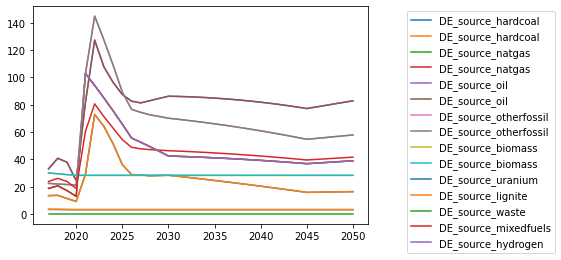

In [294]:
costs_plot = costs_fuel_real.loc[costs_fuel_real.index.str.contains("DE_")]
_ = costs_plot.T.plot()
_ = plt.legend(bbox_to_anchor=[1.1, 1])

### Include price variations within years (dispatch model)
Include monthly pattern for historical years from DESTATIS data:
* Use normalized time series: 1 is the average fuel price value for the particular year.
* For future years, prices are constant, i.e. all values are equal to 1.
* For fuels other than hardcoal, lignite, natgas and oil, constant fuel prices are used.

> _Note: Using the respective year for normalization restricts pommesdispatch simulations to be within one year!_

DESTATIS (2022): Prices. Data on energy price trends. - Long-time series from January 2005 to January 2022 -, https://www.destatis.de/EN/Themes/Economy/Prices/Publications/Downloads-Energy-Price-Trends/energy-price-trends-pdf-5619002.pdf?__blob=publicationFile, as of February 2022, accessed 25.02.2022

In [197]:
monthly_price_pattern = {
    "hardcoal": "5.1 Hard coal and lignite",
    "lignite": "5.1 Hard coal and lignite",
    "oil": "5.2 Mineral oil",
    "natgas": "5.3.1 Natural gas - indices"
}
price_timeseries = pd.DataFrame(
    index=pd.date_range(start=f"2017-01-01", end=f"2050-12-31", freq="H")
)

for energy_source, sheet in monthly_price_pattern.items():
    monthly_price_trends = pd.read_excel(
        main_path["inputs"] + sub_path["costs"] + input_file["monthly_price_trends"],
        sheet_name=sheet, skiprows=3, index_col=0, nrows=20
    )
    # Format & slice
    monthly_price_trends = monthly_price_trends.dropna(thresh=2).rename(
        columns={"Unnamed: 13": "yearly_average"}
    )
    monthly_price_trends.index = (
        monthly_price_trends.index.str.replace(" ...", "").astype(int)
    )
    monthly_price_trends = monthly_price_trends.loc[range(2017, 2022)]

    # Create normalized pattern
    monthly_price_trends = (
        monthly_price_trends.div(
            monthly_price_trends["yearly_average"], axis=0
        )
    )
    monthly_price_trends.drop(columns="yearly_average", inplace=True)

    time_series_to_concat = []

    for iter_year in monthly_price_trends.index:
        time_series = pd.DataFrame(
            index=pd.date_range(
                start=f"{iter_year}-01-01", end=f"{iter_year}-12-31", freq="MS"
            ),
            data={
                energy_source:
                    monthly_price_trends.loc[iter_year].values
            }
        )
        time_series_to_concat.append(time_series)
    
    full_time_series = pd.concat([ts for ts in time_series_to_concat])
    constant_vals = pd.DataFrame(index=pd.date_range(
        start="2022-01-01", end="2051-01-01", freq="MS"
    ), data=1, columns=[energy_source])
    full_time_series = pd.concat([full_time_series, constant_vals])
    price_timeseries[energy_source] = full_time_series.resample("H").ffill()[:-1]

C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\2087823838.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  monthly_price_trends.index.str.replace(" ...", "").astype(int)
C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\2087823838.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  monthly_price_trends.index.str.replace(" ...", "").astype(int)
C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\2087823838.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  monthly_price_trends.index.str.replace(" ...", "").astype(int)
C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\2087823838.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  monthly_price_trends.index.str.replace(" ...", "").astype(int)


In [198]:
# Add missing fuels and match with commodity sources and write to csv
price_timeseries[[
    "uranium", "biomass", "water", "waste", 
    "solarthermal", "otherRES", "mixedfuels", "otherfossil", "hydrogen"
]] = 1
price_timeseries = price_timeseries.loc[:,all_sources_commodity['technology'].values]
price_timeseries = price_timeseries.astype(np.float32).round(2)
price_timeseries.columns = all_sources_commodity.index

price_timeseries = price_timeseries.loc[price_timeseries.index.year == year]

price_timeseries.to_csv(
    main_path["outputs"] + output_file["costs_fuel_ts"] + "_" + str(year) + ".csv"
)

## Emissions costs
* Historical costs are obtained from the primary auction results at EEX.
* Projections are derived from a background document to the Ariadne Scenario report as well as a recent paper by Pietzcker et al.

Literature:
* EEX (2017-2021): Emission Spot Primary Market Auction Report 2017-2021, https://www.eex.com/en/market-data/environmental-markets/eua-primary-auction-spot-download, accessed 28.02.2022.
* Pietzcker, Robert, Knopf, Brigitte, Osorio, Sebastian, Edenhofer, Ottmar et al. (2021): Ariadne-Hintergrund. Notwendige CO2-Preise zum Erreichen des europäischen Klimaziels 2030, issued by PIK, November 2021, https://doi.org/10.48485/pik.2021.007.
* Pietzcker, Robert, Osorio, Sebastian, Rodrigues, Renato (2021): Tightening EU ETS targets in line with the European Green Deal: Impacts on the decarbonization of the EU power sector, in: Applied Energy 293 (2021), https://doi.org/10.1016/j.apenergy.2021.116914.

### Process historical EUA price data
Steps applied:
* Read in primary market auction reports, filter for non EAA and non-Polish data and slice auction price and volume
* Calculate volume-weigthed averages and store them in a DataFrame
* Derive normalized time series from auction data. The volume-weighted average of each year is used for normalization
* Interpolate linearly. Use assumption that future prices do not vary in time

In [199]:
emissions_costs_ts_to_concat = []
emissions_costs = pd.DataFrame(
    index=all_sources_commodity.index,
    columns=range(2017, 2022),
)

for iter_year in range(2017, 2022):
    emissions_costs_ts = pd.read_excel(
        main_path["inputs"] + sub_path["costs"] + input_file["emissions_costs"] + f"-{iter_year}-data.xlsx", 
        index_col=0, skiprows=5, usecols="B:V"
    )
    emissions_costs_ts = emissions_costs_ts.loc[
        (emissions_costs_ts["Contract"] != "EAA3")
        & ~(
            emissions_costs_ts["Auction Name"].isin([
                "Auction 4. Period CAP3 PL",
                'Auction 3. Period CAP2-PL',
                "Auction 3. Period PL"
            ])
        )
    ].sort_index()
    emissions_costs_ts = emissions_costs_ts[[
        "Auction Price €/tCO2", "Auction Volume tCO2"
    ]].rename(
        columns={
            "Auction Price €/tCO2": "price",
            "Auction Volume tCO2": "volume"
        }
    ).dropna(axis=0)
    # Calculate volume-weigthed average and store it as annual mean price
    wm = lambda x: np.average(x, weights=emissions_costs_ts.loc[x.index, 'volume'])
    volume_weighted_mean_price = emissions_costs_ts.apply(wm).loc["price"]
    emissions_costs[iter_year] = volume_weighted_mean_price
    
    emissions_costs_ts = emissions_costs_ts["price"].div(volume_weighted_mean_price)
    
    emissions_costs_ts_to_concat.append(emissions_costs_ts)

C:\mambaforge-data\envs\diss3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\mambaforge-data\envs\diss3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\mambaforge-data\envs\diss3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\mambaforge-data\envs\diss3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\mambaforge-data\envs\diss3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains n

In [200]:
# Convert emissions costs to real terms
emissions_costs_real = emissions_costs.copy(deep=True)
for iter_year in emissions_costs_real.columns:
    emissions_costs_real[iter_year] = emissions_costs[iter_year].div(inflation_rate ** (iter_year - 2020))

In [201]:
# Concat, add artifical elements at the beginning and end and of the time series and convert to hourly frequency
emissions_costs_ts = pd.concat([ec for ec in emissions_costs_ts_to_concat])
emissions_costs_ts.loc[pd.Timestamp("2017-01-01")] = emissions_costs_ts.iloc[0]
emissions_costs_ts = emissions_costs_ts.sort_index()
emissions_costs_ts.loc[pd.Timestamp("2022-01-01")] = emissions_costs_ts.iloc[-1]
emissions_costs_ts = emissions_costs_ts.resample("H").interpolate()[:-1]
emissions_costs_ts

constant_vals = pd.Series(index=pd.date_range(
    start="2022-01-01", end="2050-12-23", freq="H"
), data=1, name="price")
emissions_costs_ts = pd.concat([emissions_costs_ts, constant_vals]).astype(np.float32).round(3)

# Slice the values for the simulation year
emissions_costs_ts = emissions_costs_ts.loc[emissions_costs_ts.index.year == year]

emissions_costs_ts.to_csv(
    main_path["outputs"] + output_file["costs_emissions_ts"] + "_" + str(year) + ".csv"
)

### Add CO2 price projections

The following CO2 price projections are included. For the first three ones, there is a low, medium and high estimate, while for the one derived from the Pietzcker et al. paper, only the medium estimate is given:

| projection | explanation | characteristics |
| ---- | ---- | ---- |
| Fit_for_55_split (Ff55_split) | emissions split between ETS and non-ETS according to Fit for 55 package plans | low ETS prices, but high non-ETS prices until 2030 |
| reductions_in_ETS_only (red_ETS) | reductions to meeting Fit for 55 emissions targets are brought by ETS emissions only | high ETS price until 2030 |
| ESR_reduced (ESR_red) | Emissions in non-ETS (ESR: effort sharing regulation) are reduced compared to Fit for 55 goal (intermediate pathway) | medium ETS price until 2030 |
| long-term | Price pathway from paper Pietzcker et al. 2021 conform with Fit for 55 goal | low ETS prices, projection until 2050 |

Steps applied:
* Read in projected values (from Ariadne background report and paper Pietzcker et al. 2021)
* Convert to nominal terms
* Assume linear development to derive scenarios until 2030 resp. 2050 (Pietzcker et al. 2021 only)

In [202]:
emissions_costs_ariadne = pd.read_csv(
    main_path["inputs"] + sub_path["costs"] + input_file["emission_costs_projection"], 
    index_col=[0, 1], sep=";"
)
# Convert to nominal terms
emissions_costs_ariadne["nominal_term_value_2030"] = (
    emissions_costs_ariadne["real_term_value_2030"] * inflation_rate ** (2030 - 2021)
)

In [203]:
emissions_costs_projections = dict()
emissions_costs_projections_normalized = dict()
emissions_costs_projections_real = dict()

for scen in emissions_costs_ariadne.index:
    # nominal
    emissions_costs_pred = pd.DataFrame(
        index=all_sources_commodity.index,
        columns=range(2021, 2031)
    )
    emissions_costs_pred[2021] = emissions_costs[2021]
    emissions_costs_pred[2030] = emissions_costs_ariadne.at[
        scen, "nominal_term_value_2030"
    ]
    emissions_costs_pred = (
        emissions_costs_pred.astype("float64").interpolate(axis=1).round(2)[range(2022, 2031)]
    )
    emissions_costs_projections[scen] = pd.concat(
        [emissions_costs, emissions_costs_pred],
        axis=1
    ).round(2)
    
    emissions_costs_projections[scen].to_csv(
        (
            main_path["outputs"] + output_file["costs_emissions"] 
            + "_" + scen[0] + "_" + scen[1] + "_nominal_" + str(year) + ".csv"
        )
    )
    emissions_costs_projections[scen].to_excel(
        writer, sheet_name='c_emis' + "_" + scen[0] + "_" + scen[1] + '_nominal'
    )

    # Transform to time series
    emissions_costs_projections_normalized[scen] = (
        tools.transform_values_to_annual_time_series(emissions_costs_projections[scen], end_year=2030)
    )
    emissions_costs_projections_normalized[scen].to_csv(
        main_path["outputs"] + output_file["costs_emissions"] 
            + "_" + scen[0] + "_" + scen[1] + "_nominal_indexed_ts.csv"
    )

    # real
    emissions_costs_pred_real = pd.DataFrame(
        index=all_sources_commodity.index,
        columns=range(2021, 2031)
    )
    emissions_costs_pred_real[2021] = emissions_costs[2021]
    emissions_costs_pred_real[2030] = emissions_costs_ariadne.at[
        scen, "real_term_value_2030"
    ]
    emissions_costs_pred_real = (
        emissions_costs_pred_real.astype("float64").interpolate(axis=1).round(2)[range(2022, 2031)]
    )
    emissions_costs_projections_real[scen] = pd.concat(
        [emissions_costs_real, emissions_costs_pred_real],
        axis=1
    ).round(2)
    
    emissions_costs_projections_real[scen].to_csv(
        (
            main_path["outputs"] + output_file["costs_emissions"] 
            + "_" + scen[0] + "_" + scen[1] + "_real_" + str(year) + ".csv"
        )
    )
    emissions_costs_projections_real[scen].to_excel(
        writer, sheet_name='c_emis' + "_" + scen[0] + "_" + scen[1] + '_real'
    )

C:\mambaforge-data\envs\diss3\lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [204]:
emissions_costs_pietzcker = pd.read_csv(
    main_path["inputs"] + sub_path["costs"] + input_file["emission_costs_long-term_projection"], 
    index_col=0, sep=";"
)
# Convert to nominal terms
emissions_costs_pietzcker["nominal_term_value"] = (
    emissions_costs_pietzcker["real_term_value"]
    * inflation_rate ** (emissions_costs_pietzcker.index - 2021)
)

In [205]:
# nominal
emissions_costs_pred = pd.DataFrame(
    index=all_sources_commodity.index,
    columns=range(2021, 2051)
)
emissions_costs_pred[2021] = emissions_costs[2021]

for index in emissions_costs_pietzcker.index:
    emissions_costs_pred[index] = emissions_costs_pietzcker.at[
        index, "nominal_term_value"
    ]
emissions_costs_pred = (
    emissions_costs_pred.astype("float64").interpolate(axis=1).round(2)[range(2022, 2051)]
)
emissions_costs_projections["long-term"] = pd.concat(
    [emissions_costs, emissions_costs_pred],
    axis=1
).round(2)

emissions_costs_projections["long-term"].to_csv(
    main_path["outputs"] + output_file["costs_emissions"] + "_long-term_nominal_" + str(year) + ".csv"
)
emissions_costs_projections["long-term"].to_excel(
    writer, sheet_name='costs_emis_long-term_nominal'
)

# Transform to time series
emissions_costs_projections_normalized["long-term"] = (
    tools.transform_values_to_annual_time_series(emissions_costs_projections["long-term"])
)
emissions_costs_projections_normalized["long-term"].to_csv(
    main_path["outputs"] + output_file["costs_emissions"] 
        + "_long-term_nominal_indexed_ts.csv"
)

# real
emissions_costs_pred_real = pd.DataFrame(
    index=all_sources_commodity.index,
    columns=range(2021, 2051)
)
emissions_costs_pred_real[2021] = emissions_costs[2021]

for index in emissions_costs_pietzcker.index:
    emissions_costs_pred_real[index] = emissions_costs_pietzcker.at[
        index, "real_term_value"
    ]
emissions_costs_pred_real = (
    emissions_costs_pred_real.astype("float64").interpolate(axis=1).round(2)[range(2022, 2051)]
)
emissions_costs_projections_real["long-term"] = pd.concat(
    [emissions_costs_real, emissions_costs_pred_real],
    axis=1
).round(2)

emissions_costs_projections_real["long-term"].to_csv(
    main_path["outputs"] + output_file["costs_emissions"] + "_long-term_real_" + str(year) + ".csv"
)
emissions_costs_projections_real["long-term"].to_excel(
    writer, sheet_name='costs_emis_long-term_real'
)

## Investment expenses
Steps applied:
* Read in and reshape data
* Separate data for storage units which is considered in the next section.
* Inflation is not considered since
    * it is way outperformed by data insecurities and
    * data sets are all from 2020/21 and thus depict the status quo estimates.
* If study does not explicitly consider hydrogen generation, assume it to have the same costs as natural gas.

Cost assumptions for investment expenses are taken from:
* Pietzcker, Robert, Osorio, Sebastian, Rodrigues, Renato (2021): Tightening EU ETS targets in line with the European Green Deal: Impacts on the decarbonization of the EU power sector, in: Applied Energy 293 (2021), https://doi.org/10.1016/j.apenergy.2021.
* Fraunhofer ISE (2020): Appendix to the study "Wege zu einem klimaneutralen Energiesystem. Die deutsche Energiewende im Kontext gesellschaftlicher Verhaltensweisen.", https://www.ise.fraunhofer.de/de/veroeffentlichungen/studien/wege-zu-einem-klimaneutralen-energiesystem.html, accessed 08.07.2022.
* PyPSA-EUR assumptions on costs compiled from various (primary) sources: https://github.com/PyPSA/pypsa-eur/blob/master/data/costs.csv, accessed 01.07.2022.
* dieterpy input data compiled from various (primary) sources: https://gitlab.com/diw-evu/dieter_public/dieterpy_reduced/-/blob/main/input/data_input.xlsx, accessed 01.07.2022.
* A data set from the research project FlexMex, https://zenodo.org/record/5802178, including data compiled from various (primary) sources, accessed 01.07.2022.
* As well as a collection of data from various (primary) sources from the research project UNSEEN (as of 03/2021).

### Generators

In [206]:
investment_expenses_pietzcker = pd.read_excel(
    main_path["inputs"] + sub_path["assumptions"] 
    + input_file["pietzcker_technology_assumptions"],
    sheet_name="investment_expenses",
    index_col=0, header=0
).T
investment_expenses_pietzcker.rename(
    index={
        'Hard Coal CCS': 'ST_CCS_hardcoal', 
        'Lignite CCS': 'ST_CCS_lignite', 
        'Gas CC CCS': 'CC_CCS_natgas', 
        'Hydrogen FC': 'FC_hydrogen', 
        'BECCS': 'beccs',
        'Wind Onshore': 'windonshore', 
        'Wind Offshore': 'windoffshore', 
        'PV': 'solarPV',
        'CSP': 'csp',
    },
    inplace=True
)

In [207]:
generation_assumptions_pietzcker = pd.read_excel(
    main_path["inputs"] + sub_path["assumptions"] 
    + input_file["pietzcker_technology_assumptions"],
    sheet_name="generation",
    index_col=0, header=[0, 1]
)

In [208]:
pietzcker_constant_costs = generation_assumptions_pietzcker[
    [("Investment costs", "(€/kW)")]].loc[
        generation_assumptions_pietzcker[("Investment costs", "(€/kW)")].notna()
].rename(
    {
        'Nuclear': 'ST_uranium', 
        'Hard Coal': 'ST_hardcoal', 
        'Lignite': 'ST_lignite',
        'Gas CC': 'CC_natgas', 
        'Gas CT': 'GT_natgas', 
        'Oil': 'ST_oil',
        'Hydrogen CC': 'CC_hydrogen', 
        'Hydrogen CT': 'GT_hydrogen', 
        'Waste': 'ST_waste', 
        'Other gases': 'ST_otherfossil', 
        'Biomass': 'GT_biomass',
        'Hydro': 'ror'
    }
)
pietzcker_constant_costs.columns = [2020]
pietzcker_constant_costs[2050] = pietzcker_constant_costs[2020]
investment_expenses_pietzcker = pd.concat(
    [investment_expenses_pietzcker, pietzcker_constant_costs]
)
investment_expenses_pietzcker["study_title"] = "Pietzcker_2021"
investment_expenses_pietzcker.set_index("study_title", append=True, inplace=True)
investment_expenses_pietzcker.interpolate(how="linear", axis=1, inplace=True)

In [209]:
ise_generators = pd.read_excel(
    main_path["inputs"] + sub_path["assumptions"] + input_file["ise_technology_assumptions"],
    sheet_name="generation",
    index_col=[0, 1, 2], header=0,
)

investment_expenses_ise = (
    ise_generators.loc[ise_generators.index.get_level_values(1) == "Investition "]
)
investment_expenses_ise = investment_expenses_ise.reset_index(
    level=[1, 2], drop=True
).rename(index={
    "Wind Offshore ": "windoffshore",
    "Wind Onshore ": "windonshore",
    "Photovoltaik Dach Süd": "solarPV",
    "Photovoltaik Dach Ost-West": "solarPV",
    "Photovoltaik Freifläche Süd": "solarPV",
    "GuD-Kraftwerke ": "CC_natgas",
    "Gasturbine ": "GT_natgas",
    "Braunkohlekraftwerk ": "ST_lignite",
    "Steinkohlekraftwerk ": "ST_hardcoal",
    "H2-Rückverstromung (Gasturbine)": "GT_hydrogen"
})
investment_expenses_ise["study_title"] = "ISE_2020"
investment_expenses_ise.set_index("study_title", append=True, inplace=True)

In [210]:
dieterpy_conventional_data = pd.read_excel(
    main_path["inputs"] + sub_path["assumptions"] 
    + input_file["dieterpy_data"],
    sheet_name="con",
    index_col=0, header=[0, 1, 2], skiprows=2, nrows=4
).dropna(how="all")

In [211]:
# Slice investments and convert from €/MW to €/kW
dieterpy_investments = dieterpy_conventional_data.rename(index={
    "coal": "ST_hardcoal",
    "ocgt": "GT_natgas",
    "ccgt": "CC_natgas",
})[[('Overnight investment costs per MW ', '[EUR/MW]', 'oc')]].div(1000)
dieterpy_investments.columns = [2020]
for iter_year in range(2021, 2051):
    dieterpy_investments[iter_year] = dieterpy_investments[2020]
dieterpy_investments
dieterpy_investments["study_title"] = "DIETER_2021"
dieterpy_investments.set_index("study_title", append=True, inplace=True)

# Add hydrogen costs
dieterpy_investments = tools.add_hydrogen_cost_assumption(dieterpy_investments)

In [212]:
flexmex_data = pd.read_csv(
    main_path["inputs"] + sub_path["assumptions"] 
    + input_file["flexmex_data"],
    index_col=0, header=0
)
flexmex_investments = flexmex_data.loc[
    (flexmex_data["Parameter"].str.contains("Capex")) 
    & (flexmex_data["Parameter"].str.contains("EnergyConversion")) ]

In [213]:
flexmex_investments = pd.concat(
    [
        flexmex_investments,
        flexmex_investments["Parameter"].str.split("_", expand=True)
    ], axis=1)
flexmex_dict = {
    "CH4": "natgas",
    "Nuclear": "uranium",
    "H2": "hydrogen",
    "ExCCGT": "CC"
}
flexmex_investments.replace(flexmex_dict, inplace=True)
flexmex_investments.rename(columns={
    2: "final_energy",
    3: "fuel",
    4: "technology"
}, inplace=True)

flexmex_investments = flexmex_investments.loc[
    (flexmex_investments["fuel"]. isin(flexmex_dict.values()))
    & (flexmex_investments["final_energy"].isin(["Electricity", "ElectricityHeat"]))
]
flexmex_investments["new_index"] = flexmex_investments["technology"] + "_" + flexmex_investments["fuel"] 
flexmex_investments.set_index("new_index", inplace=True)
# Convert from €/MW to €/kW
flexmex_investments = flexmex_investments[["Value"]].div(1000)
flexmex_investments.columns = [2020]
for iter_year in range(2021, 2051):
    flexmex_investments[iter_year] = flexmex_investments[2020]
    
flexmex_investments["study_title"] = "FlexMex_2021"
flexmex_investments.set_index("study_title", append=True, inplace=True)

# Add hydrogen costs
flexmex_investments = tools.add_hydrogen_cost_assumption(flexmex_investments)

In [214]:
unseen_data = pd.read_csv(
    main_path["inputs"] + sub_path["assumptions"] 
    + input_file["unseen_data"],
    index_col=[0, 1], header=0, sep=";"
)
unseen_data.rename(index={
    "Solid Biomass": "GT_biomass",
    "Biogas": "GT_biomass",
    "Pumped hydro": "storage_el_phes",
    "Electrolyzers": "EL_hydrogen",
    "Fuel cells": "FC_hydrogen",
    "Open cycle gas turbines": "GT_natgas",
    "Combinded-cycle gas turbines": "CC_natgas",
    "Hard coal power plants": "ST_hardcoal",
    "Lignite power plants": "ST_lignite",
    "Lithium batteries": "storage_el_battery"
}, inplace=True)

unseen_storages_data = unseen_data.loc[
   unseen_data["Unit"].str.contains("kWh") 
]
unseen_investment_data = unseen_data.loc[
    ~unseen_data["Unit"].str.contains("kWh")
]
unseen_data_pivoted = unseen_investment_data.pivot_table(
    index=unseen_investment_data.index, columns="Year", values="Value"
)
unseen_investments = pd.DataFrame(
    index=unseen_data_pivoted.index,
    columns=range(2020, 2051),
    dtype="float64"
)
for col in unseen_data_pivoted.columns:
    unseen_investments[col] = unseen_data_pivoted[col]
unseen_investments.interpolate(how="linear", axis=1, inplace=True)
unseen_investments.index = pd.MultiIndex.from_tuples(unseen_investments.index)
unseen_investments.reset_index(level=1, inplace=True)
unseen_investments["study_title"] = "UNSEEN_" + unseen_investments["level_1"]
unseen_investments.set_index("study_title", append=True, inplace=True)
unseen_investments.drop(columns="level_1", inplace=True)
# Add hydrogen costs
unseen_investments = tools.add_hydrogen_cost_assumption(unseen_investments)

# Exclude storages for laters
unseen_investments_storages = unseen_investments.loc[
    unseen_investments.index.get_level_values(0).isin(["storage_el_phes", "storage_el_battery"])
]
unseen_investments = unseen_investments.loc[
    ~unseen_investments.index.get_level_values(0).isin(
        unseen_investments_storages.index.get_level_values(0)
    )
]

In [215]:
pypsa_eur_data = pd.read_csv(
    main_path["inputs"] + sub_path["assumptions"] 
    + input_file["pypsa_eur"],
    index_col=0, header=0, sep=","
)

In [216]:
pypsa_eur_investments = pypsa_eur_data.loc[
    pypsa_eur_data["parameter"] == "investment", ["value"]
]
generators = {
    "onwind": "windonshore",
    "offwind": "windoffshore",
    "solar": "solarPV",
    "biomass": "GT_biomass",
    "geothermal": "geothermal",
    "coal": "ST_hardcoal",
    "lignite": "ST_lignite",
    "solar-rooftop": "solarPV", 
    "solar-utility": "solarPV",
    "ror": "ror",
    "OCGT": "GT_natgas",
    "nuclear": "ST_uranium",
    "CCGT": "CC_natgas",
    "oil": "ST_oil",
    "fuel cell": "FC_hydrogen",
}
pypsa_eur_investments.rename(
    index=generators,
    inplace=True
)
pypsa_eur_investments.drop(
    index=[
        el for el in pypsa_eur_investments.index 
        if el not in generators.values()
    ],
    inplace=True
)

In [217]:
pypsa_eur_investments.columns = [2020]
for col in range(2021, 2051):
    pypsa_eur_investments[col] = pypsa_eur_investments[2020]
pypsa_eur_investments["study_title"] = "PyPSA_Eur"
pypsa_eur_investments.set_index("study_title", append=True, inplace=True)
# Add hydrogen costs
pypsa_eur_investments = tools.add_hydrogen_cost_assumption(pypsa_eur_investments)

C:\Users\koch_j0\POMMES_public\pommes-data\pommesdata\data_prep\tools.py:1119: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[(hydrogen_idx, el[1]), :] = df.loc[el].values
C:\Users\koch_j0\POMMES_public\pommes-data\pommesdata\data_prep\tools.py:1119: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[(hydrogen_idx, el[1]), :] = df.loc[el].values
C:\Users\koch_j0\POMMES_public\pommes-data\pommesdata\data_prep\tools.py:1119: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[(hydrogen_idx, el[1]), :] = df.loc[el].values


### Storages
> _Note: The distinction between the data sets is handled differently. This holds especially true for electrolyzers. Since these have similarities with transformer units in oemof.solph, we consider them as such and add them to the data set of generators._

In [218]:
storages_assumptions_pietzcker = pd.read_excel(
    main_path["inputs"] + sub_path["assumptions"] 
    + input_file["pietzcker_technology_assumptions"],
    sheet_name="storages",
    index_col=0, header=0
)

In [219]:
storages_time_dependent_pietzcker = pd.read_excel(
    main_path["inputs"] + sub_path["assumptions"] 
    + input_file["pietzcker_technology_assumptions"],
    sheet_name="storages_time-dependent",
    index_col=[0, 1], header=0
)
storages_time_dependent_pietzcker.rename(
    columns={"2050–2070": "2050"},
    inplace=True
)
storages_time_dependent_pietzcker.columns = (
    storages_time_dependent_pietzcker.columns.astype("int64")
)

In [220]:
energy_related_costs = storages_time_dependent_pietzcker.loc[
    storages_time_dependent_pietzcker.index.get_level_values(1) == "Reservoir (€/kWh)"
]
power_related_costs = storages_time_dependent_pietzcker.loc[
    storages_time_dependent_pietzcker.index.get_level_values(1) == "Power (€/kW)"
]
energy_related_costs.reset_index(level=1, drop=True, inplace=True)
power_related_costs.reset_index(level=1, drop=True, inplace=True)
power_related_costs.columns = pd.MultiIndex.from_product([
    ["power_costs"], power_related_costs.columns
])
energy_related_costs.columns = pd.MultiIndex.from_product([
    ["capacity_costs"], energy_related_costs.columns
])
storages_investment_expenses_pietzcker = pd.concat(
    [power_related_costs, energy_related_costs], 
    axis=1
)
storages_investment_expenses_pietzcker.rename(
    index={
        "Batteries": "storage_el_battery",
        "Hydrogen Electrolysis": "EL_hydrogen"
    },
    inplace=True
)
storages_investment_expenses_pietzcker["study_title"] = "Pietzcker_2021"
storages_investment_expenses_pietzcker.set_index("study_title", append=True, inplace=True)

# Correctly attribute electrolyzers
investment_expenses_pietzcker.loc[("EL_hydrogen", "Pietzcker_2021"), :] = (
    storages_investment_expenses_pietzcker.loc[(("EL_hydrogen", "Pietzcker_2021"), "power_costs")].values
)
storages_investment_expenses_pietzcker.drop(index="EL_hydrogen", inplace=True, level=0)
storages_investment_expenses_pietzcker = storages_investment_expenses_pietzcker.fillna(0)

In [221]:
ise_storages = pd.read_excel(
    main_path["inputs"] + sub_path["assumptions"] 
    + input_file["ise_technology_assumptions"],
    sheet_name="storage_transformation",
    index_col=[0, 1, 2], header=0
)
ise_storages_investment = ise_storages.loc[
    ise_storages.index.get_level_values(1) == "Investition "
]
storage_techs = {
    "Elektrolyse (MIX PEM/AEL/HTEL)": "EL_hydrogen",
    "Stationäre Batterien ": "storage_el_battery",
    "Wasserstoffspeicher & -verdichter": "storage_hydrogen",
}
ise_storages_investment.rename(
    index=storage_techs,
    inplace=True
)
ise_storages_investment = ise_storages_investment.loc[
    ise_storages_investment.index.get_level_values(0).isin(
        storage_techs.values()
    )
]

C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\1777628339.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ise_storages_investment.rename(


In [222]:
energy_related_costs = ise_storages_investment.loc[
    ise_storages_investment.index.get_level_values(2).str.contains("kWh")
]
power_related_costs = ise_storages_investment.loc[
    ~ise_storages_investment.index.get_level_values(2).str.contains("kWh")
]
energy_related_costs.reset_index(level=[1, 2], drop=True, inplace=True)
power_related_costs.reset_index(level=[1, 2], drop=True, inplace=True)
power_related_costs.columns = pd.MultiIndex.from_product([
    ["power_costs"], power_related_costs.columns
])
energy_related_costs.columns = pd.MultiIndex.from_product([
    ["capacity_costs"], energy_related_costs.columns
])
ise_storages_investment = pd.concat(
    [power_related_costs, energy_related_costs], 
    axis=1
)
ise_storages_investment["study_title"] = "ISE_2020"
ise_storages_investment.set_index("study_title", append=True, inplace=True)

# Correctly attribute electrolyzers
investment_expenses_ise.loc[("EL_hydrogen", "ISE_2020"), :] = (
    ise_storages_investment.loc[(("EL_hydrogen", "ISE_2020"), "power_costs")].values
)
ise_storages_investment.drop(index="EL_hydrogen", inplace=True, level=0)
ise_storages_investment = ise_storages_investment.fillna(0)

C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\190917365.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  investment_expenses_ise.loc[("EL_hydrogen", "ISE_2020"), :] = (
C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\190917365.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  investment_expenses_ise.loc[("EL_hydrogen", "ISE_2020"), :] = (


In [223]:
dieterpy_storages_data = pd.read_excel(
    main_path["inputs"] + sub_path["assumptions"] 
    + input_file["dieterpy_data"],
    sheet_name="sto",
    index_col=0, header=[0, 1, 2], skiprows=2, nrows=6
).dropna(how="all").dropna(how="all", axis=1)

In [224]:
# Slice investments and convert from €/MW to €/kW
dieterpy_storages_data.index = dieterpy_storages_data.index.str.split("_", expand=True)
dieterpy_storage_investments = dieterpy_storages_data.rename(index={
    "phs": "storage_el_phes",
    "liion": "storage_el_battery",
    "p2g2p": "storagel_el_p2g2p",
})[[('Overnight investment costs in energy ', '[EUR/MWh]', 'oc_energy'),
     ('Overnight investment costs in capacity', '[EUR/MW]', 'oc_power'),]].div(1000)
dieterpy_storage_investments.columns = pd.MultiIndex.from_tuples([
    ("capacity_costs", 2020),
    ("power_costs", 2020)
])
dieterpy_storage_investments[("capacity_costs", 2050)] = dieterpy_storage_investments[("capacity_costs", 2020)]
dieterpy_storage_investments[("power_costs", 2050)] = dieterpy_storage_investments[("power_costs", 2020)]
dieterpy_storage_investments = dieterpy_storage_investments.sort_index(axis=1, level=0)
dieterpy_storage_investments.index.names = ["technology", "kind"]
dieterpy_storage_investments["study_title"] = "DIETER_2021_" + dieterpy_storage_investments.index.get_level_values(1)
dieterpy_storage_investments.set_index("study_title", append=True, inplace=True)
dieterpy_storage_investments = dieterpy_storage_investments.droplevel(1)
dieterpy_storage_investments = dieterpy_storage_investments.rename(index={np.nan: "DIETER_2021"})
dieterpy_storage_investments = dieterpy_storage_investments.fillna(0)

In [225]:
flexmex_storage_investments = flexmex_data.loc[
    ((flexmex_data["Parameter"].str.contains("Storage")) 
    | (flexmex_data["Parameter"].str.contains("EnergyConversion")))
    & (flexmex_data["Parameter"].str.contains("Capex_Electricity"))
    & ~(flexmex_data["Parameter"].str.contains(r"CH4|Nuclear"))
]

In [226]:
flexmex_storage_investments = pd.concat(
    [
        flexmex_storage_investments,
        flexmex_storage_investments["Parameter"].str.split("_", expand=True)
    ], axis=1)
flexmex_storages_dict = {
    "Hydro": "storage_el_reservoir",
    "LiIonBattery": "storage_el_battery",
    "LiIonBatteryCharge": "storage_el_battery_pump",
    "LiIonBatteryDischarge": "storage_el_battery_turbine",
    "LiIonBatteryStorage": "storage_el_battery_capacity",
    "ReservoirPump": "pump",
    "ReservoirStorage": "capacity",
    "ReservoirTurbine": "turbine",
    np.nan: ""
}
flexmex_storage_investments.replace(flexmex_storages_dict, inplace=True)
flexmex_storage_investments.rename(columns={
    2: "final_energy",
    3: "fuel",
    4: "technology"
}, inplace=True)
flexmex_storage_investments["tech_fuel"] = (
    flexmex_storage_investments["technology"] + "_" + flexmex_storage_investments["fuel"]
).str.strip("_")

flexmex_storage_investments.set_index("tech_fuel", inplace=True)
flexmex_storage_investments[("capacity_costs", 2020)] = np.where(
    flexmex_storage_investments["Unit"].str.contains("h"), 
    flexmex_storage_investments["Value"],
    0
)
flexmex_storage_investments[("power_costs", 2020)] = np.where(
    ~flexmex_storage_investments["Unit"].str.contains("h"), 
    flexmex_storage_investments["Value"],
    0
)
flexmex_storage_investments[("capacity_costs", 2050)] = flexmex_storage_investments[("capacity_costs", 2020)]
flexmex_storage_investments[("power_costs", 2050)] = flexmex_storage_investments[("power_costs", 2020)]
flexmex_storage_investments = flexmex_storage_investments[[
    ("capacity_costs", 2020), ("capacity_costs", 2050), 
    ("power_costs", 2020), ("power_costs", 2050)
]]
flexmex_storage_investments.columns = pd.MultiIndex.from_tuples(flexmex_storage_investments.columns)
flexmex_storage_investments["study_title"] = "FlexMex_2021"
flexmex_storage_investments.set_index("study_title", append=True, inplace=True)

In [227]:
unseen_investments_storages.columns = pd.MultiIndex.from_product([
    ["power_costs"], unseen_investments_storages.columns
])
unseen_storages_data_pivoted = unseen_storages_data.pivot_table(
    index=unseen_storages_data.index, columns="Year", values="Value"
)
unseen_storages_data_pivoted.columns = pd.MultiIndex.from_product([
    ["capacity_costs"], unseen_storages_data_pivoted.columns
])
unseen_storages_data_pivoted.index = pd.MultiIndex.from_tuples(unseen_storages_data_pivoted.index)
unseen_storages_data_pivoted.reset_index(level=1, inplace=True)
unseen_storages_data_pivoted["study_title"] = "UNSEEN_" + unseen_storages_data_pivoted["level_1"]
unseen_storages_data_pivoted.set_index("study_title", append=True, inplace=True)
unseen_storages_data_pivoted.drop(columns="level_1", inplace=True)

unseen_investments_storages = pd.concat(
    [unseen_investments_storages, unseen_storages_data_pivoted], 
    axis=1
).fillna(0)

C:\Users\koch_j0\AppData\Local\Temp\ipykernel_15036\2527091185.py:14: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  unseen_storages_data_pivoted.drop(columns="level_1", inplace=True)


In [228]:
pypsa_eur_storages_investments = pypsa_eur_data.loc[
    pypsa_eur_data["parameter"] == "investment", ["value", "unit"]
]
storages = {
    "PHS": "storage_el_phes",
    "hydro": "storage_el_reservoir",
    "battery storage": "storage_el_battery",
}
pypsa_eur_storages_investments.rename(
    index=storages,
    inplace=True
)
pypsa_eur_storages_investments.drop(
    index=[
        el for el in pypsa_eur_storages_investments.index 
        if el not in storages.values()
    ],
    inplace=True
)
# Assume an exchange rate of 1 USD = 0.9 €
pypsa_eur_storages_investments.loc["storage_el_battery", "value"] *= 0.9 

In [229]:
pypsa_eur_storages_investments[("power_costs", 2020)] = np.where(
    ~pypsa_eur_storages_investments["unit"].str.contains("h"), 
    pypsa_eur_storages_investments["value"],
    0
)
pypsa_eur_storages_investments[("capacity_costs", 2020)] = np.where(
    pypsa_eur_storages_investments["unit"].str.contains("h"), 
    pypsa_eur_storages_investments["value"],
    0
)
pypsa_eur_storages_investments[("power_costs", 2050)] = pypsa_eur_storages_investments[("power_costs", 2020)]
pypsa_eur_storages_investments[("capacity_costs", 2050)] = pypsa_eur_storages_investments[("capacity_costs", 2020)]
pypsa_eur_storages_investments = pypsa_eur_storages_investments[[
    ("capacity_costs", 2020), ("capacity_costs", 2050), 
    ("power_costs", 2020), ("power_costs", 2050)
]]
pypsa_eur_storages_investments.columns = pd.MultiIndex.from_tuples(pypsa_eur_storages_investments.columns)
pypsa_eur_storages_investments["study_title"] = "PyPSA_Eur"
pypsa_eur_storages_investments.set_index("study_title", append=True, inplace=True)

### Combine and evaluate data sets
Steps applied:
* Iterate over data sets to create complete data sets.
* Check investment expenses estimates per technology in form of a box plot as well as by calculating statistical metrics.
* Calculate 5%, 50% and 95% estimates for investment expenses.

In [230]:
# Initialize collections
investment_expenses_comparison = pd.DataFrame(
    columns=range(2020, 2051), index=pd.MultiIndex(
        levels=[[], []], codes=[[], []]
    )
)
storages_investment_expenses_comparison = pd.DataFrame(
    columns=pd.MultiIndex.from_product([
        ["power_costs", "capacity_costs"],
        range(2020, 2051)
    ]), 
    index=pd.MultiIndex(
        levels=[[], []], codes=[[], []]
    )
)

In [231]:
investment_studies = [
    investment_expenses_pietzcker, 
    investment_expenses_ise, 
    dieterpy_investments,
    flexmex_investments, 
    unseen_investments, 
    pypsa_eur_investments
]
storage_investment_studies = [
    storages_investment_expenses_pietzcker, 
    ise_storages_investment, 
    dieterpy_storage_investments,
    unseen_investments_storages, 
    pypsa_eur_storages_investments
]

In [232]:
# Combine to overall data set - generators
for study in investment_studies:
    # Convert to nominal terms
    for iter_year in study.columns:
        study[iter_year] = study[iter_year].mul(inflation_rate ** (iter_year - 2020)).round(2)
    investment_expenses_comparison = tools.add_study_to_comparison(
        investment_expenses_comparison, 
        study
    )
# Combine to overall data set - storages
for study in storage_investment_studies:
    # Convert to nominal terms
    for col in study.columns:
        study[col] = study[col].mul(inflation_rate ** (col[1] - 2020)).round(2)
    storages_investment_expenses_comparison = tools.add_study_to_comparison(
        storages_investment_expenses_comparison, 
        study
    )

In [233]:
# Define information to be evaluated within an iteration
iterations = [
    {
        "data_set": investment_expenses_comparison, 
        "columns": list(range(2020, 2051)),
        "parameter": "investment_expenses"
    },
    {
        "data_set": storages_investment_expenses_comparison, 
        "columns": pd.MultiIndex.from_product([["power_costs"], list(range(2020, 2051))]),
        "parameter": "investment_expenses_storages_power"
    },
    {
        "data_set": storages_investment_expenses_comparison, 
         "columns": pd.MultiIndex.from_product([["capacity_costs"], list(range(2020, 2051))]),
        "parameter": "investment_expenses_storages_capacity"
    }
 ]

In [234]:
# Iterate and combine to overall data sets; create plots and calculate summary statistics
list_of_data_sets = []
for number, iteration in enumerate(iterations):
    data_sets = {}
    for idx in iterations[number]["data_set"].index.get_level_values(0).unique():
        data = iterations[number]["data_set"].loc[idx, iterations[number]["columns"]]
        if type(data.columns) == pd.MultiIndex:
            data.columns = data.columns.droplevel(0)
        if len(data) > 1:
            tools.plot_parameter_comparison(
                data=data, 
                parameter=iterations[number]["parameter"],
                category=idx,
                savefig=True,
                show=False
            )
        stats_data = tools.calculate_summary_statistics(
            data=data,
            path=main_path["outputs"],
            parameter=iterations[number]["parameter"],
            category=idx,
            save=False
        )
        data_sets[idx] = stats_data.copy()
    list_of_data_sets.append(data_sets)

C:\mambaforge-data\envs\diss3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


In [235]:
# Extract 5%, 50% and 95% estimate from summary statistics for each technology category
for number, data_sets in enumerate(list_of_data_sets):
    for estimate in ["5%", "50%", "95%"]:
        overall_data_set = tools.combine_parameter_estimates(
            col_names=list(range(2020, 2051)),
            data_sets=data_sets,
            parameter=iterations[number]["parameter"],
            estimate=estimate,
            path=main_path["outputs"],
            transform=True,
            save=True
        )

## Fixed costs
Include fixed costs assumptions for technologies

Sources evaluated (same as for investment expenses):
* Pietzcker, Robert, Osorio, Sebastian, Rodrigues, Renato (2021): Tightening EU ETS targets in line with the European Green Deal: Impacts on the decarbonization of the EU power sector, in: Applied Energy 293 (2021), https://doi.org/10.1016/j.apenergy.2021.
* Fraunhofer ISE (2020): Appendix to the study "Wege zu einem klimaneutralen Energiesystem. Die deutsche Energiewende im Kontext gesellschaftlicher Verhaltensweisen.", https://www.ise.fraunhofer.de/de/veroeffentlichungen/studien/wege-zu-einem-klimaneutralen-energiesystem.html, accessed 08.07.2022.
* PyPSA-EUR assumptions on costs compiled from various (primary) sources: https://github.com/PyPSA/pypsa-eur/blob/master/data/costs.csv, accessed 01.07.2022.
* dieterpy input data compiled from various (primary) sources: https://gitlab.com/diw-evu/dieter_public/dieterpy_reduced/-/blob/main/input/data_input.xlsx, accessed 01.07.2022.
* A data set from the research project FlexMex, https://zenodo.org/record/5802178, including data compiled from various (primary) sources, accessed 01.07.2022.
* As well as a collection of data from various (primary) sources from the research project UNSEEN (as of 03/2021).

### Generators

In [236]:
pietzcker_rename_dict = {
    'Hard Coal CCS': 'ST_CCS_hardcoal', 
    'Lignite CCS': 'ST_CCS_lignite', 
    'Gas CC': 'CC_natgas',
    'Gas CC CCS': 'CC_CCS_natgas',
    'Gas CT': 'GT_natgas',
    'Hydrogen FC': 'FC_hydrogen', 
    'BECCS': 'beccs',
    'Wind Onshore': 'windonshore', 
    'Wind Offshore': 'windoffshore', 
    'PV': 'solarPV', 
    'CSP': 'csp',
    'Nuclear': 'ST_uranium', 
    'Hard Coal': 'ST_hardcoal', 
    'Lignite': 'ST_lignite',
    'Gas CC': 'CC_natgas', 
    'Gas CT': 'GT_natgas', 
    'Oil': 'ST_oil',
    'Hydrogen CC': 'CC_hydrogen', 
    'Hydrogen CT': 'GT_hydrogen', 
    'Waste': 'ST_waste',
    'Other gases': 'ST_otherfossil', 
    'Biomass': 'GT_biomass',
    'Hydro': 'ror'
}
pietzcker_fixed_costs = tools.extract_parameter_pietzcker(
    generation_assumptions_pietzcker, ('Fixed O&M',  '(%/yr)'), pietzcker_rename_dict
)
tools.append_study_title_and_rename_column(
    pietzcker_fixed_costs, "Pietzcker_2021", "fixed_costs_percent_per_year"
)

In [237]:
ise_rename_dict = {
    "Wind Offshore ": "windoffshore",
    "Wind Onshore ": "windonshore",
    "Photovoltaik Dach Süd": "solarPV",
    "Photovoltaik Dach Ost-West": "solarPV",
    "Photovoltaik Freifläche Süd": "solarPV",
    "GuD-Kraftwerke ": "CC_natgas", 
    "Gasturbine ": "GT_natgas",
    "Braunkohlekraftwerk ": "ST_lignite",
    "Steinkohlekraftwerk ": "ST_hardcoal", 
    "H2-Rückverstromung (Gasturbine)": "GT_hydrogen"
}
fixed_costs_ise = tools.extract_parameter_ise(
    ise_generators, 'M/O-Kosten ', ise_rename_dict
)
tools.append_study_title_and_rename_column(
    fixed_costs_ise, "ISE_2020", "fixed_costs_percent_per_year"
)

In [238]:
dieterpy_fixed_costs = dieterpy_conventional_data.rename(index={
    "coal": "ST_hardcoal",
    "ocgt": "GT_natgas",
    "ccgt": "CC_natgas",
})[[('Annual fixed cost per MW', '[EUR/MW]', 'fixed_costs'),
    ('Overnight investment costs per MW ', '[EUR/MW]', 'oc')]]

dieterpy_fixed_costs["fixed_costs_percent_per_year"] = dieterpy_fixed_costs[
    ('Annual fixed cost per MW', '[EUR/MW]', 'fixed_costs')
].div(dieterpy_fixed_costs[
    ('Overnight investment costs per MW ', '[EUR/MW]', 'oc')
]).mul(100)
dieterpy_fixed_costs = dieterpy_fixed_costs[["fixed_costs_percent_per_year"]]
dieterpy_fixed_costs.columns = dieterpy_fixed_costs.columns.droplevel([1, 2])
tools.append_study_title_and_rename_column(
    dieterpy_fixed_costs, "DIETER_2021", "fixed_costs_percent_per_year"
)

dieterpy_fixed_costs = tools.add_hydrogen_cost_assumption(dieterpy_fixed_costs)

In [239]:
flexmex_fixed_costs = tools.extract_parameter_flexmex(
    flexmex_data, rename_dict=flexmex_dict, conditions=["FixOM", "EnergyConversion"], mode="generators"
)
tools.append_study_title_and_rename_column(
    flexmex_fixed_costs, "FlexMex_2021", "fixed_costs_percent_per_year"
)

flexmex_fixed_costs = tools.add_hydrogen_cost_assumption(flexmex_fixed_costs)

In [240]:
unseen_rename_dict = {
    "Solid Biomass": "GT_biomass",
    "Biogas": "GT_biomass",
    "Pumped hydro": "storage_el_phes",
    "Electrolyzers": "electrolyzer",
    "Fuel cells": "FC_hydrogen",
    "Open cycle gas turbines": "GT_natgas",
    "Combinded-cycle gas turbines": "GT_natgas",
    "Hard coal power plants": "ST_hardcoal",
    "Lignite power plants": "ST_lignite",
    "Lithium batteries": "storage_el_battery"
}

unseen_fixed_costs, unseen_fixed_costs_storages = tools.extract_parameter_unseen(
    main_path, sub_path, input_file, "unseen_fixed_costs_data", 
    unseen_rename_dict, "fixed_costs_percent_per_year"
)
# Add hydrogen costs
unseen_fixed_costs = tools.add_hydrogen_cost_assumption(unseen_fixed_costs)

In [241]:
pypsa_eur_fixed_costs = tools.extract_parameter_pypsa_eur(pypsa_eur_data, "FOM", generators)

tools.append_study_title_and_rename_column(
    pypsa_eur_fixed_costs, "PyPSA_Eur", "fixed_costs_percent_per_year"
)
# Add hydrogen costs
pypsa_eur_fixed_costs = tools.add_hydrogen_cost_assumption(pypsa_eur_fixed_costs)

C:\Users\koch_j0\POMMES_public\pommes-data\pommesdata\data_prep\tools.py:1119: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[(hydrogen_idx, el[1]), :] = df.loc[el].values
C:\Users\koch_j0\POMMES_public\pommes-data\pommesdata\data_prep\tools.py:1119: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[(hydrogen_idx, el[1]), :] = df.loc[el].values
C:\Users\koch_j0\POMMES_public\pommes-data\pommesdata\data_prep\tools.py:1119: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[(hydrogen_idx, el[1]), :] = df.loc[el].values


### Storages
> _Note: The distinction between the data sets is handled differently. This holds especially true for electrolyzers. Since these have similarities with transformer units in oemof.solph, we consider them as such and add them to the data set of generators._

In [242]:
pietzcker_storages_rename_dict = {
    'Pumped Storage': 'storage_el_phes', 
    'Batteries': 'storage_el_battery', 
    'Hydrogen electrolysis': 'electrolyzer',
}

pietzcker_storages_fixed_costs = tools.extract_parameter_pietzcker(
    storages_assumptions_pietzcker, ('Fixed O&M (%/a)'), pietzcker_storages_rename_dict
)
tools.append_study_title_and_rename_column(
    pietzcker_storages_fixed_costs, "Pietzcker_2021", "fixed_costs_percent_per_year"
)

In [243]:
ise_storages_fixed_costs = tools.extract_parameter_ise(
    ise_storages, ("M/O-Kosten "), storage_techs, slice=True
)
tools.append_study_title_and_rename_column(
    ise_storages_fixed_costs, "ISE_2020", "fixed_costs_percent_per_year"
)

In [244]:
flexmex_storage_fixed_costs = tools.extract_parameter_flexmex(
    flexmex_data, 
    rename_dict=flexmex_storages_dict, 
    conditions=["Storage", "EnergyConversion", "FixOM_Electricity", r"CH4|Nuclear"],
    mode="storages"
)
tools.append_study_title_and_rename_column(
    flexmex_storage_fixed_costs, "FlexMex_2021", "fixed_costs_percent_per_year"
)

In [245]:
# unseen fixed costs data for storages is already extracted above

In [246]:
pypsa_eur_storages_fixed_costs = tools.extract_parameter_pypsa_eur(pypsa_eur_data, "FOM", storages)

tools.append_study_title_and_rename_column(
    pypsa_eur_storages_fixed_costs, "PyPSA_Eur", "fixed_costs_percent_per_year"
)

### Combine and evaluate data sets
Steps applied:
* Define proxies for missing technology-fuel combinations.
* Iterate over data sets to create complete data sets.
* Check investment expenses estimates per technology in form of a box plot as well as by calculating statistical metrics.
* Calculate 5%, 50% and 95% estimates for investment expenses.

In [247]:
# Proxies for generators
tech_fuel_proxies = {
 'ST_biomass': 'GT_biomass',
 'ST_natgas': 'ST_hardcoal',
 'M_natgas': 'GT_natgas',
 'GT_oil': 'ST_oil',
 'CC_oil': 'CC_natgas',
 'GT_otherfossil': 'ST_oil',
 'ST_mixedfuels': 'ST_oil'
}
# Use proxies for generators and None for storages
proxies = [tech_fuel_proxies, None]

In [248]:
# Initialize collections
fixed_costs_comparison = pd.DataFrame(
    columns=["fixed_costs_percent_per_year"], index=pd.MultiIndex(
        levels=[[], []], codes=[[], []]
    )
)
storages_fixed_costs_comparison = pd.DataFrame(
    columns=["fixed_costs_percent_per_year"], index=pd.MultiIndex(
        levels=[[], []], codes=[[], []]
    )
)

In [249]:
fixed_costs_studies = [
    pietzcker_fixed_costs, 
    fixed_costs_ise, 
    dieterpy_fixed_costs,
    flexmex_fixed_costs, 
    unseen_fixed_costs, 
    pypsa_eur_fixed_costs
]
storage_fixed_costs_studies = [
    pietzcker_storages_fixed_costs,
    ise_storages_fixed_costs,
    # No fixed costs for storages in dieterpy
    flexmex_storage_fixed_costs,
    unseen_fixed_costs_storages,
    pypsa_eur_storages_fixed_costs
]

In [250]:
# Combine to overall data set - generators
for study in fixed_costs_studies:
    # Convert to nominal terms
    fixed_costs_comparison = tools.add_study_to_comparison(
        fixed_costs_comparison, 
        study
    )
# Combine to overall data set - storages
for study in storage_fixed_costs_studies:
    # Convert to nominal terms
    storages_fixed_costs_comparison = tools.add_study_to_comparison(
        storages_fixed_costs_comparison, 
        study
    )

In [251]:
# Define information to be evaluated within an iteration
iterations = [
    {
        "data_set": fixed_costs_comparison,
        "parameter": "fixed_costs"
    },
    {
        "data_set": storages_fixed_costs_comparison,
        "parameter": "fixed_costs_storages"
    }
 ]

In [252]:
# Iterate and combine to overall data sets; create plots and calculate summary statistics
list_of_data_sets = []
for number, iteration in enumerate(iterations):
    data_sets = {}
    for idx in iterations[number]["data_set"].index.get_level_values(0).unique():
        data = iterations[number]["data_set"].loc[idx, ["fixed_costs_percent_per_year"]]
        if type(data.columns) == pd.MultiIndex:
            data.columns = data.columns.droplevel(0)
        if len(data) > 1:
            tools.plot_parameter_comparison(
                data=data, 
                parameter=iterations[number]["parameter"],
                category=idx,
                savefig=True,
                show=False
            )
        stats_data = tools.calculate_summary_statistics(
            data=data,
            path=main_path["outputs"],
            parameter=iterations[number]["parameter"],
            category=idx,
            save=False
        )
        data_sets[idx] = stats_data.copy()
    list_of_data_sets.append(data_sets)

In [253]:
# Extract 5%, 50% and 95% estimate from summary statistics for each technology category
for number, data_sets in enumerate(list_of_data_sets):
    for estimate in ["5%", "50%", "95%"]:
        overall_data_set = tools.combine_parameter_estimates(
            col_names=["fixed_costs_percent_per_year"],
            data_sets=data_sets,
            parameter=iterations[number]["parameter"],
            estimate=estimate,
            path=main_path["outputs"],
            proxies=proxies[number],
            save=True
        )

## Variable operation costs
Include variable costs assumptions (variable operation and maintenace costs) for technologies

Sources evaluated (same as for investment expenses):
* Pietzcker, Robert, Osorio, Sebastian, Rodrigues, Renato (2021): Tightening EU ETS targets in line with the European Green Deal: Impacts on the decarbonization of the EU power sector, in: Applied Energy 293 (2021), https://doi.org/10.1016/j.apenergy.2021.
* PyPSA-EUR assumptions on costs compiled from various (primary) sources: https://github.com/PyPSA/pypsa-eur/blob/master/data/costs.csv, accessed 01.07.2022.
* dieterpy input data compiled from various (primary) sources: https://gitlab.com/diw-evu/dieter_public/dieterpy_reduced/-/blob/main/input/data_input.xlsx, accessed 01.07.2022.
* A data set from the research project FlexMex, https://zenodo.org/record/5802178, including data compiled from various (primary) sources, accessed 01.07.2022.
* As well as a collection of data from various (primary) sources from the research project UNSEEN (as of 03/2021).

### Generators
> _Note: ISE (2020) and dieterpy data set do not contain any variable costs for storages._

In [254]:
pietzcker_variable_costs = tools.extract_parameter_pietzcker(
    generation_assumptions_pietzcker, ('Variable O&M',  '(e/MWh)'), pietzcker_rename_dict
)
tools.append_study_title_and_rename_column(
    pietzcker_variable_costs, "Pietzcker_2021", "variable_costs"
)

In [255]:
flexmex_variable_costs = tools.extract_parameter_flexmex(
    flexmex_data, rename_dict=flexmex_dict, conditions=["VarOM", "EnergyConversion"], mode="generators"
)
# Convert from €/GWh to €/MWh
flexmex_variable_costs = flexmex_variable_costs.div(1000)
tools.append_study_title_and_rename_column(
    flexmex_variable_costs, "FlexMex_2021", "variable_costs"
)

flexmex_variable_costs = tools.add_hydrogen_cost_assumption(flexmex_variable_costs)

In [256]:
unseen_variable_costs, unseen_variable_costs_storages = tools.extract_parameter_unseen(
    main_path, sub_path, input_file, "unseen_variable_costs_data", 
    unseen_rename_dict, "variable_costs"
)
# Include conversion from €/kWh to €/MWh
unseen_variable_costs = unseen_variable_costs.mul(1000)
unseen_variable_costs_storages = unseen_variable_costs_storages.mul(1000)
# Add hydrogen costs
unseen_variable_costs = tools.add_hydrogen_cost_assumption(unseen_variable_costs)

In [257]:
pypsa_eur_variable_costs = tools.extract_parameter_pypsa_eur(pypsa_eur_data, "FOM", generators)

tools.append_study_title_and_rename_column(
    pypsa_eur_variable_costs, "PyPSA_Eur", "variable_costs"
)
# Add hydrogen costs
pypsa_eur_variable_costs = tools.add_hydrogen_cost_assumption(pypsa_eur_variable_costs)

C:\Users\koch_j0\POMMES_public\pommes-data\pommesdata\data_prep\tools.py:1119: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[(hydrogen_idx, el[1]), :] = df.loc[el].values
C:\Users\koch_j0\POMMES_public\pommes-data\pommesdata\data_prep\tools.py:1119: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[(hydrogen_idx, el[1]), :] = df.loc[el].values
C:\Users\koch_j0\POMMES_public\pommes-data\pommesdata\data_prep\tools.py:1119: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[(hydrogen_idx, el[1]), :] = df.loc[el].values


### Storages
> _Note: ISE (2020), dieterpy and PyPSA-Eur data set do not contain any variable costs for storages._

In [258]:
pietzcker_storages_variable_costs = tools.extract_parameter_pietzcker(
    storages_assumptions_pietzcker, ('Variable O&M (€/MWh)'), pietzcker_storages_rename_dict
)
tools.append_study_title_and_rename_column(
    pietzcker_storages_variable_costs, "Pietzcker_2021", "variable_costs"
)

In [259]:
flexmex_storage_variable_costs = tools.extract_parameter_flexmex(
    flexmex_data, 
    rename_dict=flexmex_storages_dict, 
    conditions=["Storage", "EnergyConversion", "VarOM_Electricity", r"CH4|Nuclear|Solar|Wind"],
    mode="storages"
)

In [260]:
flexmex_storage_variable_costs = tools.extract_parameter_flexmex(
    flexmex_data, 
    rename_dict=flexmex_storages_dict, 
    conditions=["Storage", "EnergyConversion", "VarOM_Electricity", r"CH4|Nuclear|Solar|Wind"],
    mode="storages"
)
tools.append_study_title_and_rename_column(
    flexmex_storage_variable_costs, "FlexMex_2021", "variable_costs"
)

# Convert from €/GWh to €/kWh and tidy up
flexmex_storage_variable_costs = flexmex_storage_variable_costs.div(1000)
flexmex_storage_variable_costs.rename(index={
    'storage_el_reservoir_Reservoir': 'storage_el_reservoir'
 }, inplace=True)

In [261]:
# unseen variable costs data for storages is already extracted above

### Combine and evaluate data sets
Steps applied:
* Iterate over data sets to create complete data sets.
* Check investment expenses estimates per technology in form of a box plot as well as by calculating statistical metrics.
* Calculate 5%, 50% and 95% estimates for investment expenses.

In [262]:
# Initialize collections
variable_costs_comparison = pd.DataFrame(
    columns=range(2020, 2051), index=pd.MultiIndex(
        levels=[[], []], codes=[[], []]
    )
)
storages_variable_costs_comparison = pd.DataFrame(
    columns=range(2020, 2051), index=pd.MultiIndex(
        levels=[[], []], codes=[[], []]
    )
)

In [263]:
variable_costs_studies = [
    pietzcker_variable_costs,
    # No variable costs in ISE 2020
    # No variable costs in dieterpy
    flexmex_variable_costs, 
    unseen_variable_costs, 
    pypsa_eur_variable_costs
]
storage_variable_costs_studies = [
    pietzcker_storages_variable_costs,
    # No variable costs for storages in ISE 2020
    # No variable costs for storages in dieterpy
    flexmex_storage_variable_costs,
    unseen_variable_costs_storages,
    # No variable costs for storages in PyPSA-Eur
]

In [264]:
# Combine to overall data set - generators
for study in variable_costs_studies:
    # Convert to nominal terms
    for iter_year in range(2020, 2051):
        study[iter_year] = study["variable_costs"] * inflation_rate ** (iter_year - 2020)
    study = study.drop(columns=["variable_costs"]).round(2)
    variable_costs_comparison = tools.add_study_to_comparison(
        variable_costs_comparison, 
        study
    )

# Combine to overall data set - storages
for study in storage_variable_costs_studies:
    # Convert to nominal terms
    for iter_year in range(2020, 2051):
        study[iter_year] = study["variable_costs"] * inflation_rate ** (iter_year - 2020)
    study = study.drop(columns=["variable_costs"]).round(2)
    storages_variable_costs_comparison = tools.add_study_to_comparison(
        storages_variable_costs_comparison, 
        study
    )

In [265]:
# Define information to be evaluated within an iteration
iterations = [
    {
        "data_set": variable_costs_comparison,
        "columns": list(range(2020, 2051)),
        "parameter": "variable_costs"
    },
    {
        "data_set": storages_variable_costs_comparison,
        "columns": list(range(2020, 2051)),
        "parameter": "variable_costs_storages"
    }
 ]

In [266]:
# Iterate and combine to overall data sets; create plots and calculate summary statistics
list_of_data_sets = []
for number, iteration in enumerate(iterations):
    data_sets = {}
    for idx in iterations[number]["data_set"].index.get_level_values(0).unique():
        data = iterations[number]["data_set"].loc[idx, iterations[number]["columns"]]
        if type(data.columns) == pd.MultiIndex:
            data.columns = data.columns.droplevel(0)
        if len(data) > 1:
            tools.plot_parameter_comparison(
                data=data, 
                parameter=iterations[number]["parameter"],
                category=idx,
                savefig=True,
                show=False
            )
        stats_data = tools.calculate_summary_statistics(
            data=data,
            path=main_path["outputs"],
            parameter=iterations[number]["parameter"],
            category=idx,
            save=False
        )
        data_sets[idx] = stats_data.copy()
    list_of_data_sets.append(data_sets)

C:\mambaforge-data\envs\diss3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\mambaforge-data\envs\diss3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\mambaforge-data\envs\diss3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


In [267]:
# Extract 5%, 50% and 95% estimate from summary statistics for each technology category
for number, data_sets in enumerate(list_of_data_sets):
    for estimate in ["5%", "50%", "95%"]:
        overall_data_set = tools.combine_parameter_estimates(
            col_names=range(2020, 2051),
            data_sets=data_sets,
            parameter=iterations[number]["parameter"],
            estimate=estimate,
            path=main_path["outputs"],
            transform=True,
            proxies=proxies[number],
            save=True
        )

## Weighted average cost of capital (WACC) and interest rates
Introduce weighted average cost of capital, either on a technology-specific basis (`wacc_mode = "technology_specific"`) or spread among all technologies (`wacc_mode = "unique"`)

Steps applied:
* Check for `wacc_mode`
* For `wacc_mode == "technology_specific"`, read in empirical data
* Fill data gaps:
    * Hydrogen is assumed to be 150% the WACC of natgas.
    * storage_el_battery is assigned a WACC of 3%.
* For `wacc_mode == "unique"`, overwrite data and spread a WACC of 5% for all technologies.
* Original idea: Use literature values for hurdle rates to derive trends for WACC until 2030 (and keep constant from there on).
* Use a constant rate of 2 % as interest rate which equals to the European inflation target.

Sources:
* Polzin, Friedemann; Sanders, Mark; Steffen, Bjarne; Egli, Florian; Schmidt, Tobias S.; Karkatsoulis, Panagiotis; Fragkos, Panagiotis; Paroussos, Leonidas (2021): The effect of differentiating costs of capital by country and technology on the European energy transition, in: Climatic Change 167 (2021). https://doi.org/10.1007/s10584-021-03163-4
* NERA (2015): NERA (2015) ‘Electricity Generation Costs and Hurdle Rates Lot 1: Hurdle Rates update for
Generation Technologies Prepared for the Department of Energy and Climate Change
(DECC)’, (July). Available at: www.nera.com.

In [337]:
wacc = pd.read_csv(
    main_path["inputs"] + sub_path["costs"] + input_file["wacc"], 
    sep=";", decimal=".", index_col=0
)
wacc.rename(
    index={
        "hydro": "storage_el_reservoir",
        "coal-fired plant": "ST_hardcoal",
        "gas plant": "GT_natgas",
        "nuclear plant": "ST_uranium"
    }, columns={
        "wacc in %": "wacc in p.u."
    }, inplace=True)
# Fill data gaps
wacc.loc["GT_hydrogen"] = wacc.loc["GT_natgas"] * 1.5
wacc.loc["ST_lignite"] = wacc.loc["ST_hardcoal"]
wacc.loc["storage_el_phes"] = wacc.loc["storage_el_reservoir"]
wacc.loc["storage_el_battery"] = 3
wacc = wacc.div(100)
  
if wacc_mode == "technology_specific":
    # Data has already been compiled
    pass

elif wacc_mode == "unique":
    wacc["wacc in p.u."] = 0.05
    
else:
    raise ValueError(f"'wacc_mode' {wacc_mode} not implemented.")

wacc.to_csv(
    main_path["outputs"] + output_file["wacc"] + ".csv"
)

In [338]:
# Process hurdle rates (not used)
hurdle_rates_2015 = pd.read_excel(
    main_path["inputs"] + sub_path["assumptions"] + input_file["hurdle_rates"], 
    sheet_name="2015", index_col=0, usecols="A:D"
)
hurdle_rates_2030 = pd.read_excel(
    main_path["inputs"] + sub_path["assumptions"] + input_file["hurdle_rates"], 
    sheet_name="2030", index_col=0, usecols="A:D"
)
hurdle_rates_2030 = hurdle_rates_2030.div(
    hurdle_rates_2015["reference point"], axis=0
)
hurdle_rates_2015 = hurdle_rates_2015.div(
    hurdle_rates_2015["reference point"], axis=0
)
wacc_factors = {}
for col in hurdle_rates_2030.columns:
    wacc_factors[col] = pd.DataFrame(columns=range(2015, 2051), dtype="float64")
    wacc_factors[col][2015] = hurdle_rates_2015[col]
    wacc_factors[col][2030] = hurdle_rates_2030[col]
    wacc_factors[col][2050] = hurdle_rates_2030[col]
    wacc_factors[col] = wacc_factors[col].interpolate(axis=1)

In [341]:
interest_rate = pd.DataFrame(data=0.02, columns=["interest_rate"], index=["value"])
interest_rate.to_csv(
    main_path["outputs"] + output_file["interest_rate"] + ".csv"
)

# Tidy up and save all DataFrames into one Excel file

In [269]:
# Do some garbage collection
try:
    del (X, X_pred, Y, average_fossil_price_trend, average_fossil_price_trend_real,
         buses, buses_df, constant_vals, conversion_factors_to_MWh_th,
         costs_fuel, costs_fuel_real, costs_opex, costs_opex_real, 
         emissions_costs, emissions_costs_real, emissions_costs_ariadne, emissions_costs_pietzcker, 
         emissions_costs_pred, emissions_costs_pred_real, 
         emissions_costs_projections, emissions_costs_projections_real, emissions_costs_ts, 
         emissions_costs_ts_to_concat, energy_carrier, energy_source,
         f, fuel, fuel_real, fuel_costs_assumptions, fuel_pred, fuel_pred_real,
         fuel_price_projections, fuel_price_projections_real, 
         fuel_prices, fuel_prices_real, fuel_scens, fuel_regression,
         fuels_dict, fuels_for_prediction, fuels_units, fuels_with_constant_costs,
         full_time_series, index, iter_year,
         monthly_price_pattern, monthly_price_trends, 
         opex, opex_real, opex_pred, opex_pred_real, opex_storages_nominal, opex_storages_real, 
         prediction_horizon, price_prediction, price_timeseries, projection,
         scen, sheet, sources_commodity, storages_el,
         transportation_costs_assumptions, time_series, time_series_to_concat,
         volume_weighted_mean_price,
         weo_fuel_price_paths, weo_fuel_price_paths_nominal, weo_prices, weo_scenarios,
        )
except:
    pass

In [270]:
# Close the Pandas Excel writer and output the Excel file.
#writer.save()
#writer.close()